### Historical Student Retention Factors
##### **Author:** Ruth Clayton

##### **Description:**
Comparative analysis of historical factors influencing fall-to-fall retention among undergraduate, graduate, returning, and entering students.

This project was completed as part of the Master of Science in Data Science and Analytics program at the University of Oklahoma.

A synthetic dataset is used to replicate the original institutional data, ensuring privacy while maintaining realistic patterns for analysis.



# Libraries

In [ ]:
%pip install dnamite

In [ ]:
#### Libraries ####
# Standard libraries
import os
import re
import warnings
from collections import Counter

# Data manipulation and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Scikit-learn
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    recall_score,
    ConfusionMatrixDisplay,
    auc
)
from sklearn.model_selection import (
    ParameterSampler,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Other libraries
from dnamite.models import DNAMiteBinaryClassifier
from joblib import Parallel, delayed
import joblib
from scipy.stats import mannwhitneyu


# Functions

In [ ]:
#### Functions ####


# Function to combine some of the smaller and more specialized programs
def recode_program(name):
    # check if input is a string
    if not isinstance(name, str):
        return name
    # create a pattern mapping
    pattern_map = {
        # combine mathematics preactuary and mathematics
        r"Mathematics": "Mathematics",
        # combine elementary ed programs
        r"Elementary Education|Eng Lang Teach Gbl Class": "Elementary Education",
        # combine music programs
        r"Music Arts|Music Performance": "Music",
        # add specialized secondary education programs into the larger program category
        r"Music Education|Art Education": "Secondary Education",
    }
    # explore each pattern in the pattern map to compare to the program name
    for pattern, replacement in pattern_map.items():
        # use the re.search function to search the program name for a match to the pattern map
        if re.search(pattern, name):
            # if there is a match, return the replacement value from the pattern map
            return replacement
    # fall back to the original program name if no match is found
    return name


# Function to truncate labels for graphing
def truncate_label(label, max_len=18):
    # check to see if the label is a string and if the string is greater than the
    # max length passed to the function
    if isinstance(label, str) and len(label) > max_len:
        # truncate label to the maximum length minus 3 characters and add ellipsis
        return label[: max_len - 3] + "..."
    # if the label is okay as is, return as is
    return label


# Function to filter the sub-datasets based on what columns are relevant
def filter_relevant_columns(data, level, entering):
    # copy the input data
    df_filtered = data.copy()
    # check the values of level and entering and filtering appropiately
    if level == "Undergraduate":
        df_filtered = df_filtered.drop(
            columns=["term_cum_gpa_ug", "attended_oru_ug"], errors="ignore"
        )
    if level == "Graduate":
        df_filtered = df_filtered.drop(
            columns=[
                "high_school_grad_month",
                "high_school_grad_year",
                "started_pave",
                "pell_grant_recipient",
                "hs_gpa",
                "family_income_category_in_aidy",
            ],
            errors="ignore",
        )
    if entering == "Entering":
        df_filtered = df_filtered.drop(
            columns=["credit_hour_velocity", "term_cum_gpa_same_level"], errors="ignore"
        )
    return df_filtered


# Function to drop any constant columns
def drop_constant_columns(df):
    # identify constant columns
    constant_cols = [col for col in df.columns if df[col].nunique(dropna=False) == 1]
    # drop the constant columns
    return df.drop(columns=constant_cols), constant_cols


# Function to output summary statistics for each group and each column in the dataset
def summarize_dataset(df):
    # list to store results
    summary = []
    # loop through each column
    for col in df.columns:
        # put the column data in a new variable so that the original isn't disturbed
        # and so that we don't have to call the dataframe each time col is referenced
        col_data = df[col]
        # count number of NA values
        missing_count = col_data.isna().sum()
        # calculate percent missingness
        missing_pct = (missing_count / len(col_data)) * 100
        # count the number of unique, non-NA values
        nunique = col_data.nunique(dropna=True)

        # Determine type
        # if number of unique values is 2, binary
        if nunique == 2:
            col_type = "Binary"
        # if the values are numeric
        elif pd.api.types.is_numeric_dtype(col_data):
            col_type = "Numeric"
        # anything else, i.e. categorical, dates, etc.
        else:
            col_type = "Other"

        # Skip binary columns with no missing data
        if col_type == "Binary" and missing_count == 0:
            continue

        # Build summary
        if col_type == "Numeric" and nunique > 2:
            summary.append(
                {
                    "Variable": col,
                    "Type": col_type,
                    "Missing Count": missing_count,
                    "Missing %": missing_pct,
                    "Min": col_data.min(),
                    "Max": col_data.max(),
                    "Mean": col_data.mean(),
                    "Median": col_data.median(),
                    "Std Dev": col_data.std(),
                }
            )
        else:
            summary.append(
                {
                    "Variable": col,
                    "Type": col_type,
                    "Missing Count": missing_count,
                    "Missing %": missing_pct,
                    "Min": None,
                    "Max": None,
                    "Mean": None,
                    "Median": None,
                    "Std Dev": None,
                }
            )
    return pd.DataFrame(summary)


# Function to truncate general text
def truncate(text, max_len=25):
    return text if len(text) <= max_len else text[: max_len - 3] + "..."


def make_truncated_labels(columns, max_len=18):
    truncated = [truncate(c, max_len) for c in columns]
    # Disambiguate duplicates
    counts = {}
    final_labels = []
    for label in truncated:
        if label not in counts:
            counts[label] = 1
            final_labels.append(label)
        else:
            counts[label] += 1
            final_labels.append(f"{label}_{counts[label]}")
    return final_labels


# Function to reduce categories in categorical variables
def reduce_categories(
    # a DataFrame
    df,
    # the categorical columns of the dataset
    cat_cols,
    # the minimum number of values to keep a category
    min_count=100,
    # the maximum number of top categories to keep
    top_n=5,
):
    # loop through all categorical columns
    for col in cat_cols:
        # count the number of items per category
        value_counts = df[col].value_counts()
        # get the top N categories by frequency
        top_categories = value_counts.nlargest(top_n).index
        # keep only the top N categories that also meet the min_count
        valid_categories = [
            cat for cat in top_categories if value_counts[cat] >= min_count
        ]
        # replace all others with 'Other'
        df[col] = df[col].where(df[col].isin(valid_categories), other="Other")

    return df

# Function convert variable names to Title Case for labeling graphs
def prettify(text):
    return re.sub(r"_", " ", text).title()


# Function to clean text to be safe for file names
def clean_filename(text):
    return re.sub(r"[^\w\-_.]", "_", text)

# Function to determine if a variable is binary
def is_binary_variable(series):
    return series.dropna().nunique() == 2



# Plotting Functions

#### Giant Faceted Retention Plots

In [ ]:
# Function to create plots for all variables by retention
def plot_mixed_giant_facets(
    groups,
    target="retained_to_oru",
    output_dir="/content/drive/MyDrive/giant_plots",
    max_categories=8,
    vars_per_plot=9,
):
    """
    Parameters:
      groups - a dict of pandas dataframes
      output_dir - directory to save plots to
      max_categories - the maximum number of categories to plot on each subplot
      vars_per_plot - the number of rows for the facet plot
    """

    # make the folder for the plots
    os.makedirs(output_dir, exist_ok=True)

    # set the seaborn global style
    sns.set(style="whitegrid")

    # initialize a variable to hold the combined data
    combined_rows = []

    # loop through each dataset
    for key, df in groups.items():
        # store the key from the Python dict
        level, entering = key
        # create a shortened version of level
        level_short = (
            "UG" if level == "Undergraduate" else "GR" if level == "Graduate" else level
        )
        # create a shortened version of entering
        entering_short = (
            "E"
            if entering == "Entering"
            else "R" if entering == "Returning" else entering
        )
        # create a shortened name for the plots
        pretty_group_name = f"{level_short} - {entering_short}"
        # filter the columns
        df = filter_relevant_columns(df, level, entering)
        # drop the id, levl, and entering columns so we don't plot
        df = df.drop(columns=["new_id", "levl", "entering"], errors="ignore")
        # make sure the target is in the dataset
        if target not in df.columns:
            continue
        # drop any rows that have missing target
        df = df.dropna(subset=[target]).copy()
        # create a new column to label the dataset
        df["Group"] = pretty_group_name
        # add the dataset to the combined rows
        combined_rows.append(df)
    # check that the dataset exists
    if not combined_rows:
        print("No valid data found.")
        return
    # combine a list of DataFrames (combined_rows) into a single DataFrame, resetting the index
    combined_df = pd.concat(combined_rows, ignore_index=True)

    # initialize dictionaries/lists to store variable types and valid column names
    col_types = {}
    valid_cols = []

    # loop through each column
    for col in combined_df.columns:
        # skip columns that are 'Group' or the target variable
        if col in ["Group", target]:
            continue
        # drop missing values for the current column
        series = combined_df[col].dropna()
        # skip if the column has no non-missing values
        if series.empty:
            continue
        # classify variable for plots: 'point' for binary/categorical, 'box' for numeric
        col_types[col] = (
            "point"
            if is_binary_variable(series) or not pd.api.types.is_numeric_dtype(series)
            else "box"
        )
        # Add valid column to the list
        valid_cols.append(col)
    # separate columns into point (categorical/binary) and box (numeric) types
    point_vars = [col for col in valid_cols if col_types[col] == "point"]
    box_vars = [col for col in valid_cols if col_types[col] == "box"]
    # Chunk the variables for manageable facet plot sizes
    point_chunks = [
        point_vars[i : i + vars_per_plot]
        for i in range(0, len(point_vars), vars_per_plot)
    ]
    box_chunks = [
        box_vars[i : i + vars_per_plot] for i in range(0, len(box_vars), vars_per_plot)
    ]

    # ➤ POINT PLOTS
    for i, chunk in enumerate(point_chunks):
        point_rows = []
        # Original column names and their truncated labels for plotting
        orig_names = [c for c in chunk if c]
        labels = make_truncated_labels(orig_names)
        label_map = dict(zip(orig_names, labels))
        # Process each variable in the current chunk
        for col in chunk:
            # Extract relevant columns and drop rows with missing values
            df_subset = combined_df[["Group", target, col]].copy()
            df_subset = df_subset[df_subset[col].notna() & df_subset[target].notna()]
            # Determine if variable is binary
            is_binary = is_binary_variable(df_subset[col])
            # If not binary, group rare categories into 'Other'
            if not is_binary:
                top_cats = df_subset[col].value_counts().nlargest(max_categories).index
                df_subset[col] = df_subset[col].where(
                    df_subset[col].isin(top_cats), "Other"
                )
            # group by group and variable value, compute retention rate
            summary = (
                df_subset.groupby(["Group", col])[target]
                .mean()
                .reset_index(name="RetentionRate")
                .assign(Variable=label_map[col])
            )

            # Rename variable column and truncate category labels
            summary.rename(columns={col: "Value"}, inplace=True)
            summary["Value"] = summary["Value"].astype(str).apply(truncate_label)

            # Store the processed summary
            point_rows.append(summary)

        # If any summaries exist, create the point plot
        if point_rows:
            point_df = pd.concat(point_rows, ignore_index=True)
            point_df["Variable"] = pd.Categorical(
                point_df["Variable"], categories=labels, ordered=True
            )
            # Create a faceted point plot using seaborn
            g = sns.catplot(
                data=point_df,
                x="RetentionRate",
                y="Value",
                row="Variable",
                col="Group",
                kind="point",
                sharex=True,
                sharey=False,
                height=4.5,
                aspect=2,
            )
            g.set_titles(row_template="{row_name}", col_template="{col_name}", size=18)
            g.set_axis_labels("Retention Rate", "", size=16)

            # Adjust tick label size for better readability
            for ax in g.axes.flat:
                ax.tick_params(labelsize=14)

            # Set x-axis range to [0, 1] and add title
            g.set(xlim=(0, 1))
            plt.subplots_adjust(top=0.9)
            plt.suptitle(
                f"Categorical/Binary Variables - Retention Rate (Part {i + 1})",
                fontsize=15,
            )

            # Save the plot to a file
            filepath = os.path.join(output_dir, f"facet_part_{i + 1}_pointplot.png")
            plt.savefig(filepath, dpi=300)
            plt.close()

    # ➤ BOX PLOTS
    for i, chunk in enumerate(box_chunks):
        box_rows = []

        # Original column names and their truncated labels for plotting
        orig_names = [c for c in chunk if c]
        labels = make_truncated_labels(orig_names)
        label_map = dict(zip(orig_names, labels))

        # Process each variable in the chunk
        for col in chunk:
            # Extract relevant columns and drop rows with missing values
            df_subset = combined_df[["Group", target, col]].copy()
            df_subset = df_subset[df_subset[col].notna() & df_subset[target].notna()]
            # Prepare for boxplot: add label and rename column to 'Value'
            melted = df_subset.assign(Variable=label_map[col]).rename(
                columns={col: "Value"}
            )
            box_rows.append(melted)

        # If any data exists, create the boxplot
        if box_rows:
            box_df = pd.concat(box_rows, ignore_index=True)
            box_df["Variable"] = pd.Categorical(
                box_df["Variable"], categories=labels, ordered=True
            )

            # Create a faceted box plot using seaborn
            g = sns.catplot(
                data=box_df,
                x=target,
                y="Value",
                row="Variable",
                col="Group",
                kind="box",
                sharey=False,
                sharex=True,
                height=4.5,
                aspect=2,
            )
            g.set_titles(row_template="{row_name}", col_template="{col_name}", size=18)
            g.set_axis_labels(target.replace("_", " ").title(), "", size=16)

            # Adjust tick label size for better readability
            for ax in g.axes.flat:
                ax.tick_params(labelsize=14)

            plt.subplots_adjust(top=0.9)
            plt.suptitle(
                f"Numeric Variables - Distribution by Retention (Part {i + 1})",
                fontsize=15,
            )

            # Save the plot to a file
            filepath = os.path.join(output_dir, f"facet_part_{i + 1}_boxplot.png")
            plt.savefig(filepath, dpi=300)
            plt.close()
    # Final print statement indicating where plots were saved
    print(f"Mixed facet plots saved to '{output_dir}/'")

#### Histograms

In [ ]:
# Function to plot individual histograms or bar plots for each variable in the dataset groups
def plot_individual_variable_distributions(
    groups,  # Dictionary with (level, entering) as keys and DataFrames as values
    output_dir="/content/drive/MyDrive/individual_variable_plots",  # Where to save plots
    max_categories=15,  # Max number of categories to display before grouping into 'Other'
):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Set seaborn style for clean-looking plots
    sns.set(style="whitegrid")

    # Iterate over each group (e.g., Undergraduate/Graduate × Entering/Returning)
    for (level, entering), df in groups.items():
        # Create short codes for group identifiers
        level_short = (
            "UG" if level == "Undergraduate" else "GR" if level == "Graduate" else level
        )
        entering_short = (
            "E" if entering == "Entering" else "R" if entering == "Returning" else entering
        )
        group_prefix = f"{level_short}_{entering_short}"  # e.g., UG_E or GR_R

        # Loop through each column/feature in the DataFrame
        for col in df.columns:
            # Skip ID and group-identifying columns
            if col in ["new_id", "levl", "entering"]:
                continue

            # Drop missing values for the current variable
            series = df[col].dropna()
            if series.empty:
                continue  # Skip if the column has no valid data

            # Set up the figure
            fig, ax = plt.subplots(figsize=(8, 5))

            # Plot a histogram for numeric variables
            if pd.api.types.is_numeric_dtype(series):
                sns.histplot(series, kde=True, ax=ax)  # Include KDE (density line)
                ax.set_title(f"{prettify(col)} - {level} {entering} (Histogram)")
                ax.set_xlabel(prettify(col))

            # Plot a bar chart for categorical variables
            else:
                counts = series.value_counts()

                # If there are too many categories, group infrequent ones as 'Other'
                if len(counts) > max_categories:
                    top_cats = counts.nlargest(max_categories).index
                    series = series.where(series.isin(top_cats), "Other")
                    counts = series.value_counts()

                # Create a horizontal bar plot
                sns.countplot(y=series, order=counts.index, ax=ax)
                ax.set_title(f"{prettify(col)} - {level} {entering} (Bar Plot)")
                ax.set_xlabel("Count")
                ax.set_ylabel(prettify(col))

            # Generate filename and full file path for saving the plot
            filename = f"{group_prefix}_{clean_filename(col)}.png"
            filepath = os.path.join(output_dir, filename)

            # Adjust layout and show/save the figure
            plt.tight_layout()
            plt.savefig(filepath, dpi=300)  # Save to disk
            plt.show()           # Show the plot
            plt.close()          # Close the figure to free memory

#### Individual Retention Plots

In [ ]:
def plot_individual_retention_plots(
    groups,
    target="retained_to_oru",
    output_dir="/content/drive/MyDrive/individual_retention_plots",
    max_categories=8,
):
    os.makedirs(output_dir, exist_ok=True)
    sns.set(style="whitegrid")

    for (level, entering), df in groups.items():
        level_short = "UG" if level == "Undergraduate" else "GR" if level == "Graduate" else level
        entering_short = "E" if entering == "Entering" else "R" if entering == "Returning" else entering
        group_label = f"{level_short} - {entering_short}"
        group_prefix = f"{level_short}_{entering_short}"

        df = df.copy()
        df = df.drop(columns=["new_id", "levl", "entering"], errors="ignore")

        if target not in df.columns:
            continue
        df = df.dropna(subset=[target])

        for col in df.columns:
            if col == target or col == "Group":
                continue

            series = df[col].dropna()
            if series.empty:
                continue

            fig, ax = plt.subplots(figsize=(8, 5))
            title = f"{col.replace('_', ' ').title()} by Retention\n({group_label})"
            filename = f"{group_prefix}_{clean_filename(col)}.png"
            filepath = os.path.join(output_dir, filename)

            if is_binary_variable(series) or not pd.api.types.is_numeric_dtype(series):
                # Treat as categorical/binary variable
                df_subset = df[[col, target]].dropna()
                top_cats = df_subset[col].value_counts().nlargest(max_categories).index
                df_subset[col] = df_subset[col].where(df_subset[col].isin(top_cats), "Other")

                summary = (
                    df_subset.groupby(col)[target]
                    .mean()
                    .reset_index(name="RetentionRate")
                    .sort_values("RetentionRate", ascending=False)
                )
                sns.pointplot(data=summary, x="RetentionRate", y=col, ax=ax)
                ax.set_xlim(0, 1)
                ax.set_xlabel("Retention Rate")
                ax.set_ylabel("")
            else:
                # Numeric variable
                sns.boxplot(data=df, x=target, y=col, ax=ax)
                ax.set_xlabel(target.replace("_", " ").title())
                ax.set_ylabel(col.replace("_", " ").title())

            ax.set_title(title)
            plt.tight_layout()
            plt.savefig(filepath, dpi=300)
            plt.close()

    print(f"Individual retention plots saved to '{output_dir}/'")

# Obtain Data

In [ ]:
#### Load Data #####
# read in the synthetic data
data = pd.read_csv("Synthetic Sample Student Data.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'synthetic_student_data_grouped_small.csv'

# Initial Data Preparation

In [ ]:
#### Initial Data Preparation ####

# Convert the column names to all lowercase for convenience
data.columns = data.columns.str.lower()

# For the nation of citizenship column, set values of 'UNKNOWN' to NA so they can be imputed
data.loc[data['nation_of_citizenship'] == 'UNKNOWN', 'nation_of_citizenship'] = np.nan

## Clean the program column ##

# Add in program name 'Certificate' for students with level CD (which is certificate)
# for rows where classification = 'CD' and program is missing, add program = 'Certificate'
data.loc[(data['classification'] == 'CD') & (data['program'].isnull()), 'program'] = 'Certificate'

# Strip the '(Online)' string values from the program column to reduce noise
data.loc[data['program'].str.contains('Online', na = False), 'program'] = data['program'].str.replace('Online', '')

# Clean the 'program' column by removing specializations and extra text
# Step-by-step:
# 1. data.loc[:, 'program'] selects all rows in the 'program' column.
# 2. str.split('-') splits each string at the '-' character (e.g., "Art - Art Education" → ["Art", "Art Education"]).
# 3. str[0] keeps only the first part before the dash (e.g., "Art").
# 4. str.replace(r'\([^)]*\)', '') removes any text inside parentheses, including the parentheses themselves (e.g., "IT (Online)" → "IT").
# 5. str.strip() removes leading and trailing whitespace (e.g., " Engineering " → "Engineering").
data.loc[:, 'program'] = data['program'].str.split('-').str[0].str.replace(r'\([^)]*\)', '', regex=True).str.strip()

# Combine some of the similar and smaller programs
# call the recode_program function
data['program'] = data['program'].apply(recode_program)

# drop the id column entirely
data.drop(columns=['new_id'], inplace=True)

In the case of the data columns related to scholarship offers, the values are missing but not at random. If the values are missing, then there was no offer of scholarships made to the students for the fall. Imputation may be an inappropiate strategy in this case because the missing offer dates add information to the model. But in the same vein, the rows with missing offer dates also have $0 of scholarships in the term, so adding a binary indicator of the missingness may be adding noise to the model.

Since graduate students' previous institution undergraduate GPA is unavailable--due to being stored in a separate data system, the variable term_cum_gpa_ug is really an indicator of whether the student ever took undergraduate classes at ORU. Let's transform that variable into a binary flag, which also elimates the large percentage of missing data.

In [ ]:
# transform term_cum_gpa_ug to a binary flag indicating if the student had any undergraduate GPA hours
data['term_cum_gpa_ug'] = data['term_cum_gpa_ug'].notnull().astype(int)
# rename the column
data.rename(columns={'term_cum_gpa_ug': 'attended_oru_ug'}, inplace=True)


# Exploratory Data Analysis

## Row Counts by Student Demographic

In [ ]:
## Row Counts by Group ##
# print out the totals for the testing and training data sets
# Create the two subsets
pre_2024 = data[data['census_year'].between(2017, 2023)]
only_2024 = data[data['census_year'] == 2024]

# Count records per group for each subset
pre_counts = (
    pre_2024
    .groupby(['levl', 'entering'])
    .size()
    .to_frame(name='2017–2023')
)

post_counts = (
    only_2024
    .groupby(['levl', 'entering'])
    .size()
    .to_frame(name='2024')
)

# Join them together
final_counts = pre_counts.join(post_counts, how='outer').fillna(0).astype(int)

# Optional: sort rows
final_counts = final_counts.sort_index()

print(final_counts, "\n")

# print out the number of columns in the data set
print("Number of columns:", data.shape[1], "\n")

                         2017–2023  2024
levl          entering                  
Graduate      Entering        1511   316
              Returning       2895   600
Undergraduate Entering        7173  1256
              Returning      14833  2234 

Number of columns: 36 



## Missing Values by Student Demographic and Column

In [ ]:
## Missing Values ##
# Split the data into the four groups for missing values summary: UG Entering, UG Returning, Grad Entering, Grad Returning
# .groupby groups the data by levl and by entering (so a full cross between the two columns' unique values)
# tuple() converts the output to a python tuple
# dict() converts the tuple to a dictionary, which has key values corresponding to levl and entering groupings
groups = dict(tuple(data.groupby(["levl", "entering"])))

# Print out columns with missing values and number and % of missing
print("Missing Values Summary (Before Imputation):\n")
for key, sub in groups.items():
    level, entering = key
    # filter to only relevant columns
    sub = filter_relevant_columns(sub, level, entering)
    # printing out the keys for the group summary
    print(f"Group {key}:")
    # calculate the total rows per slice of data
    total_rows = len(sub)
    # count the number of missing values in the column
    missing_counts = sub.isnull().sum()
    # calculate the missing percentage for the column
    missing_pct = (missing_counts / total_rows * 100).round(1)
    # summarize the values in a data frame
    summary = pd.DataFrame({"Missing Count": missing_counts, "Missing %": missing_pct})
    # print the values
    print(summary)
    # print a separation line
    print("-" * 40)

Missing Values Summary (Before Imputation):

Group ('Graduate', 'Entering'):
                              Missing Count  Missing %
census_year                               0        0.0
first_offer                             800       43.8
last_offer                              800       43.8
weighted_offer                          800       43.8
advantage                                 0        0.0
entering                                  0        0.0
attended_oru_ug                           0        0.0
transfer_hours                            0        0.0
admit_term                                0        0.0
credit_hrs                                0        0.0
classification                            0        0.0
program                                   0        0.0
nation_of_citizenship                    30        1.6
levl                                      0        0.0
campus                                    0        0.0
admit_code                                2

## Box Plots & Point Plots of Features to Retention

#### Giant Plots

In [ ]:
plot_mixed_giant_facets(groups)

Mixed facet plots saved to '/content/drive/MyDrive/giant_plots/'


#### Individual Plots

In [ ]:
plot_individual_retention_plots(groups)

Individual retention plots saved to '/content/drive/MyDrive/individual_retention_plots/'


## Summary Statistics for Numeric Columns

In [ ]:
# calculate summary stats
# list to store the summary stats
all_summaries = []
# columns to drop from the summary stats
cols_to_drop = ['new_id', 'census_year', 'levl', 'entering']

# loop through each dataset
for key, sub in groups.items():
    level, entering = key
    # drop the columns not needed for summary stats
    sub = sub.drop(columns=[col for col in cols_to_drop if col in sub.columns])
    # filter the columns
    filtered = filter_relevant_columns(sub, level, entering)
    # run the summary over the filtered sub dataset
    summary = summarize_dataset(filtered)
    # add a column for the level
    summary['Level'] = level
    # add a column for entering status
    summary['Entering Status'] = entering
    # append the summary to the list
    all_summaries.append(summary)

# combine the items in the list into one pandas DataFrame
combined_summary = pd.concat(all_summaries, ignore_index=True)
combined_summary

Variable     Type  Missing Count  Missing %  \
0                      first_offer  Numeric            800  43.787630   
1                       last_offer  Numeric            800  43.787630   
2                   weighted_offer  Numeric            800  43.787630   
3                   transfer_hours  Numeric              0   0.000000   
4                       admit_term  Numeric              0   0.000000   
..                             ...      ...            ...        ...   
78                       residency    Other            207   1.212867   
79    total_student_loan_in_season  Numeric              0   0.000000   
80  family_income_category_in_aidy    Other           4488  26.296361   
81    total_scholarships_in_season  Numeric              0   0.000000   
82                          hs_gpa  Numeric           2964  17.366848   

          Min        Max           Mean     Median      Std Dev  \
0       -6.30      12.70      -1.027069      -0.80     1.693741   
1       -6.30      12.80      -0.021227      -0.20     2.181255   
2       -6.00      13.00      -0.559883      -1.00     1.713684   
3        0.00      47.50       0.714559       0.00     3.805037   
4   201730.00  202431.00  202131.752053  202130.00   225.199068   
..        ...        ...            ...        ...          ...   
78        NaN        NaN            NaN        NaN          NaN   
79       0.00   12500.00    2273.595301    2750.00  2221.551860   
80        NaN        NaN            NaN        NaN          NaN   
81       0.00   45535.00   10087.472224   11002.00  6276.996532   
82       0.66       5.59       3.528125       3.68     0.559496   

            Level Entering Status  
0        Graduate        Entering  
1        Graduate        Entering  
2        Graduate        Entering  
3        Graduate        Entering  
4        Graduate        Entering  
..            ...             ...  
78  Undergraduate       Returning  
79  Undergraduate       Returning  
80  Undergraduate       Returning  
81  Undergraduate       Returning  
82  Undergraduate       Returning  

[83 rows x 11 columns]

## Histograms & Bar Plots of Variable Distributions

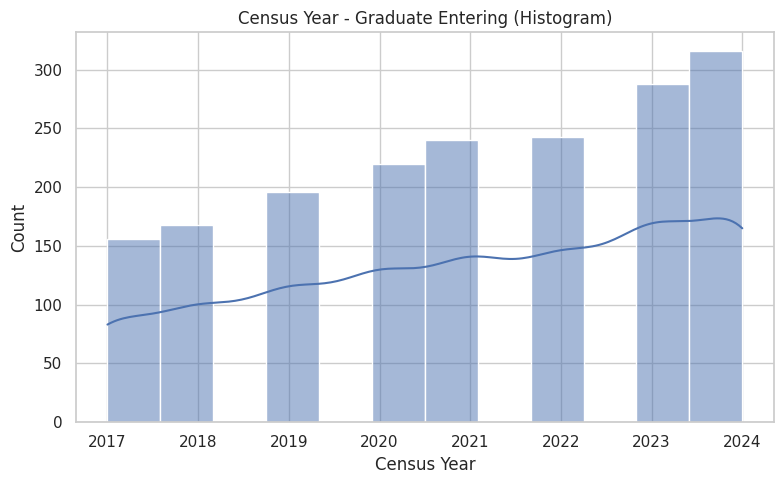

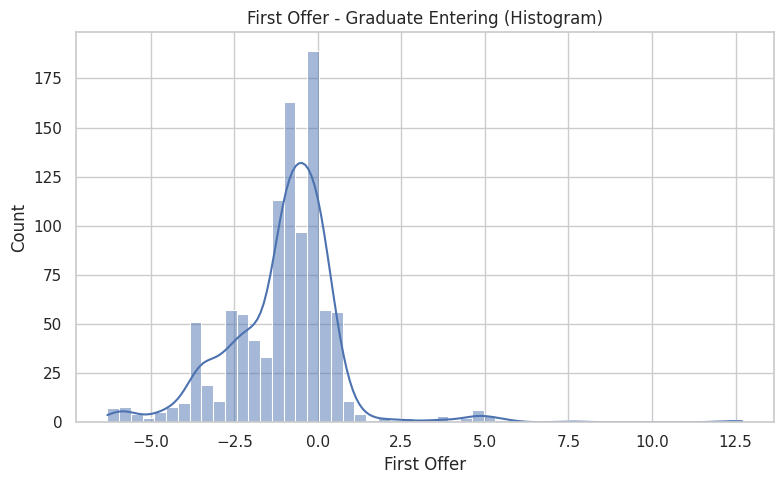

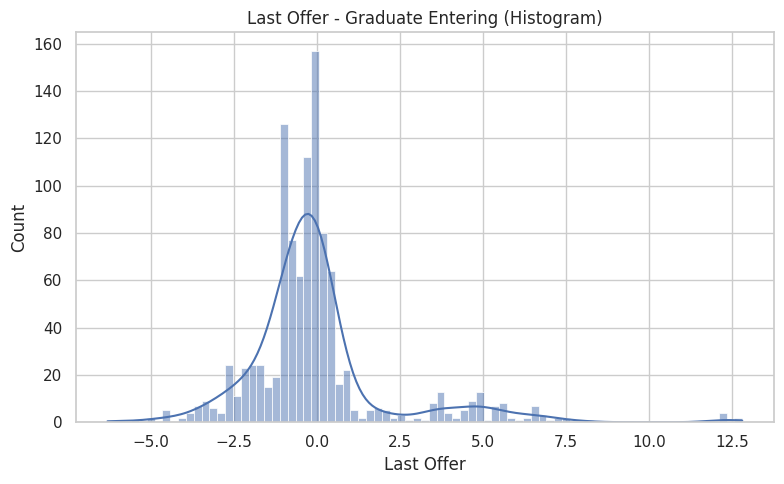

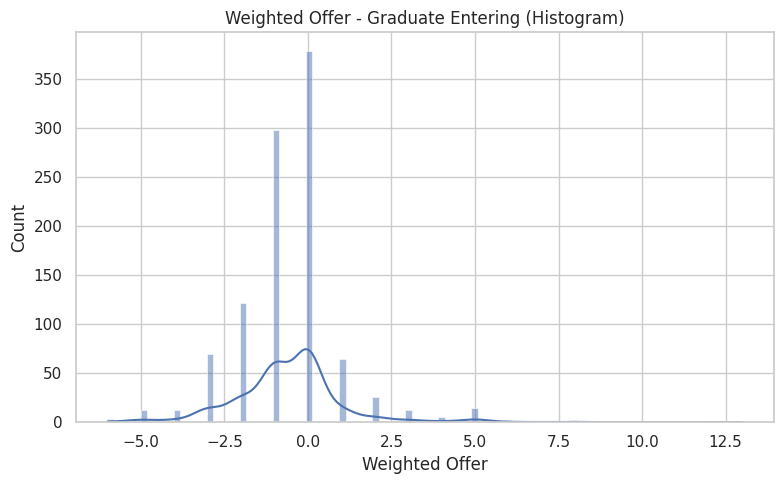

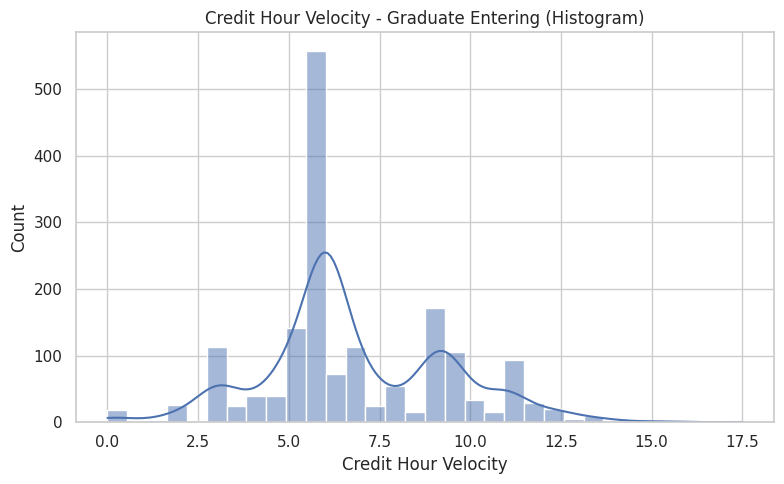

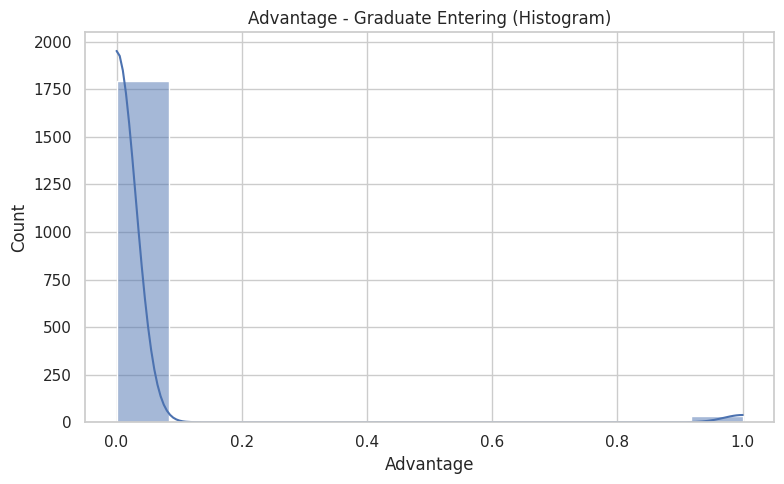

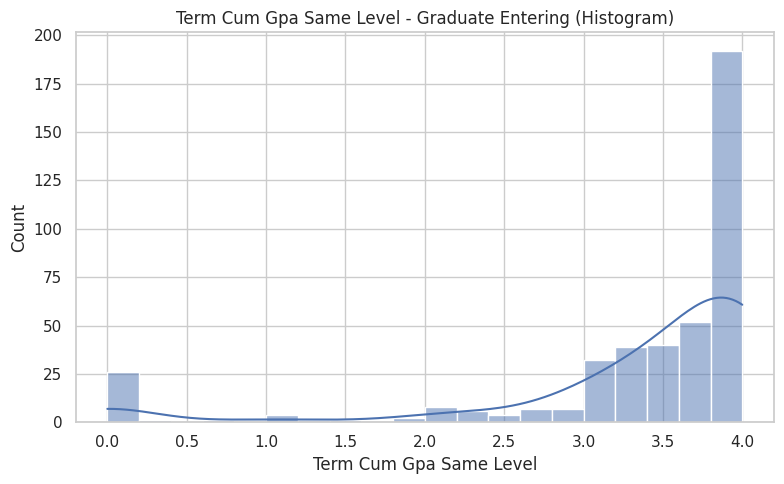

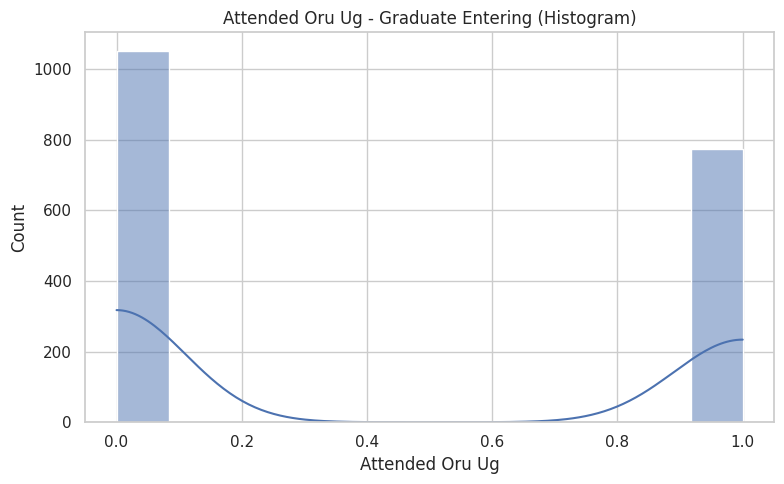

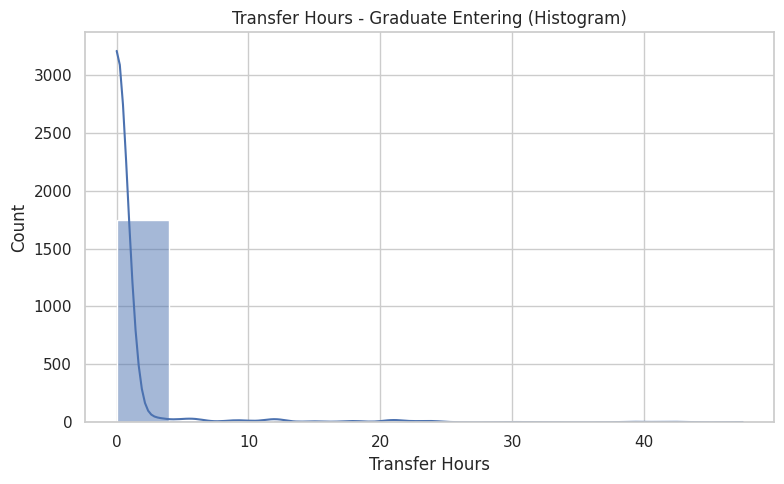

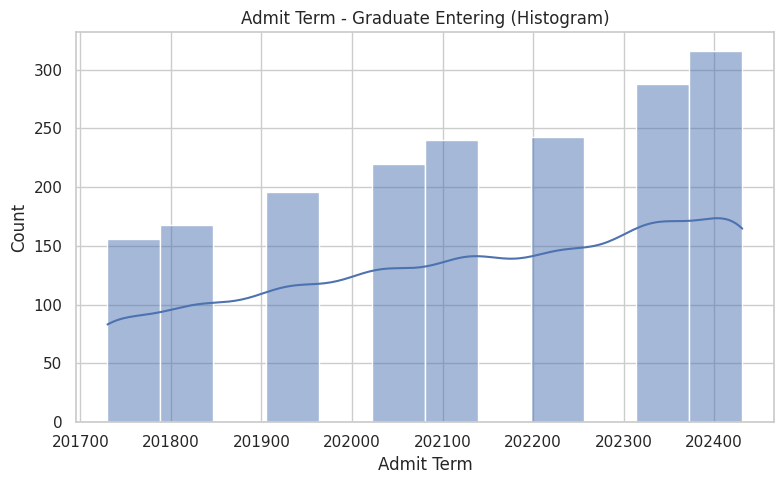

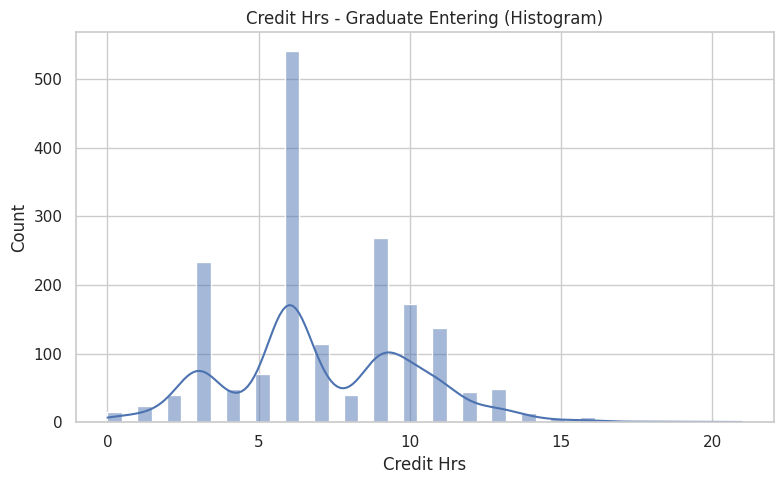

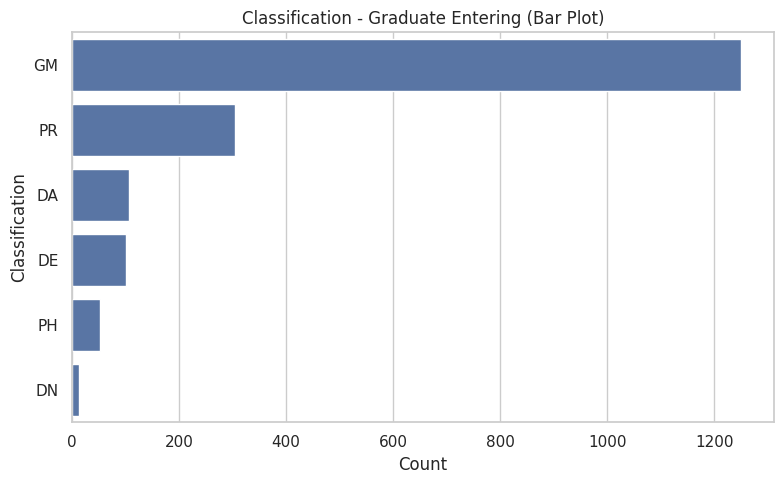

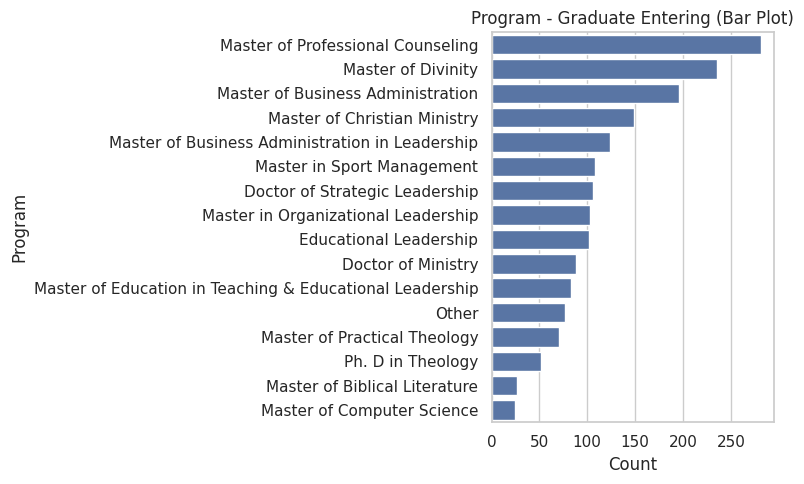

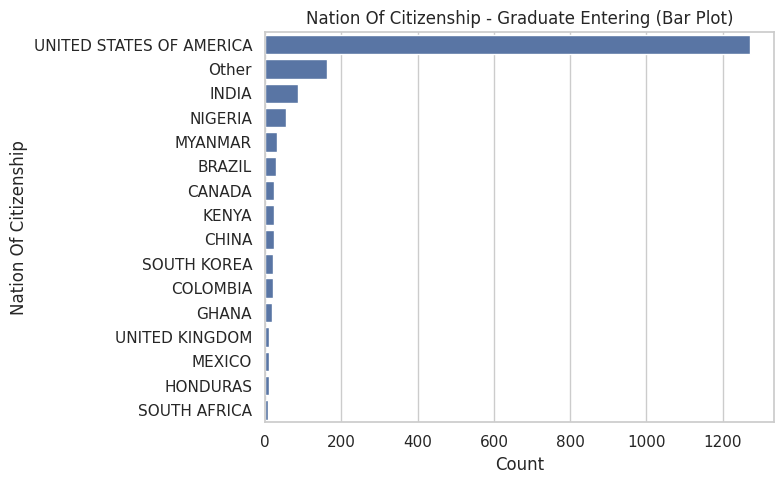

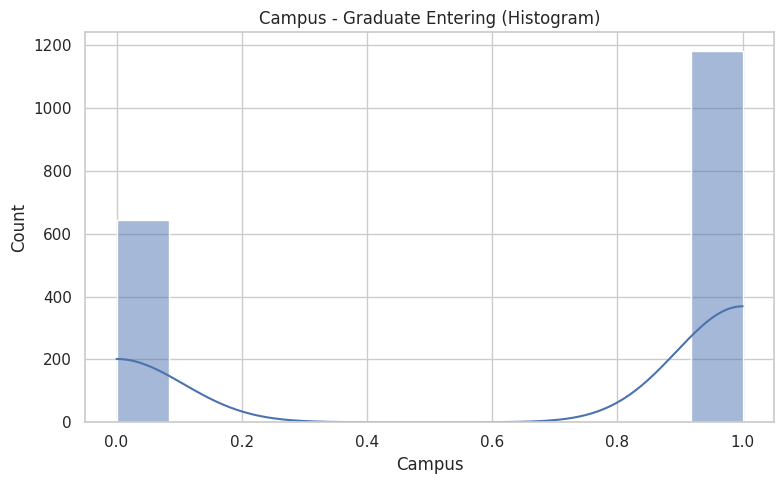

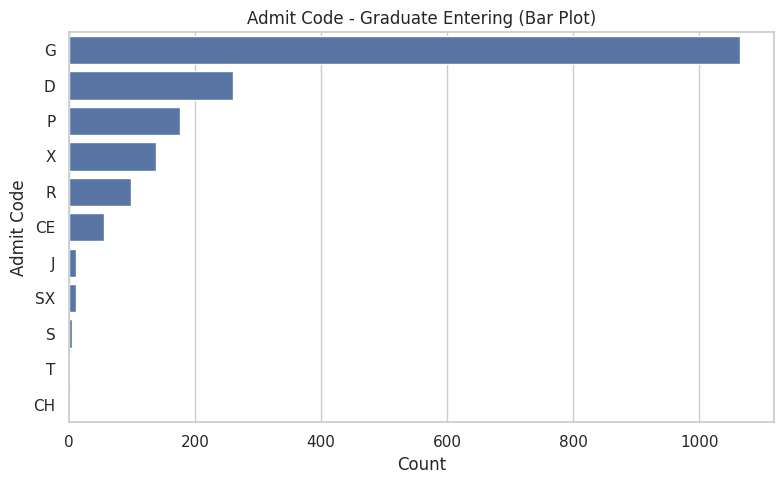

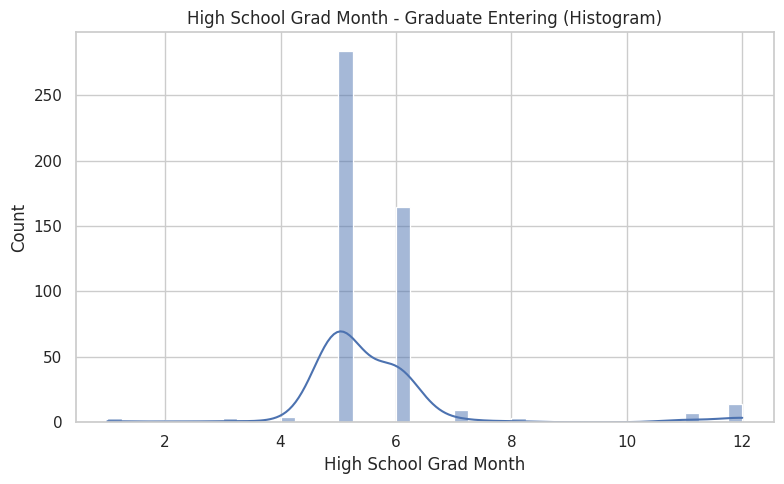

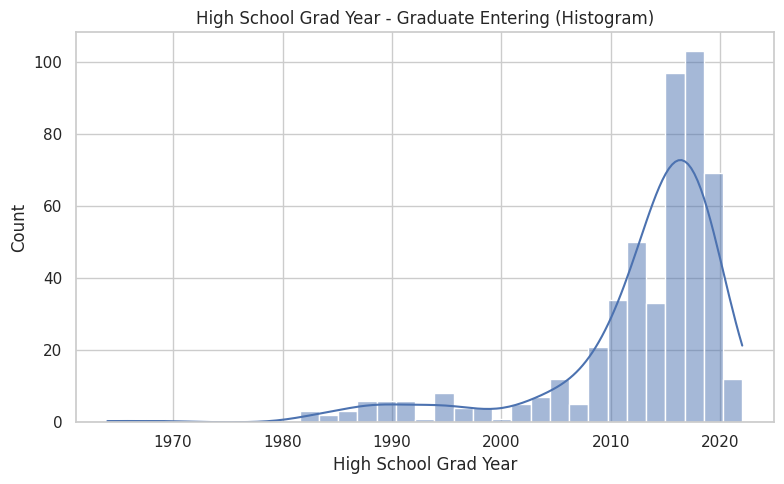

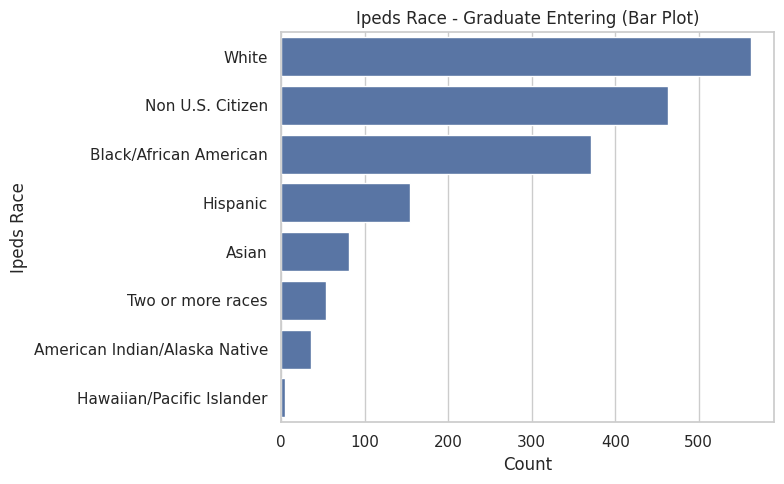

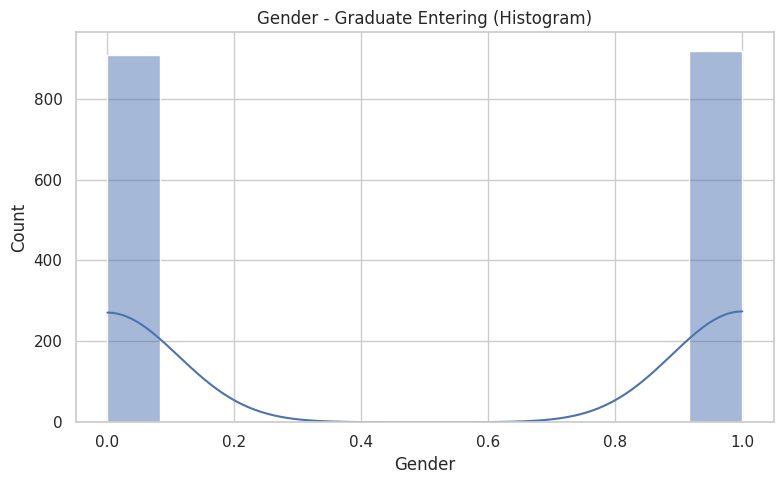

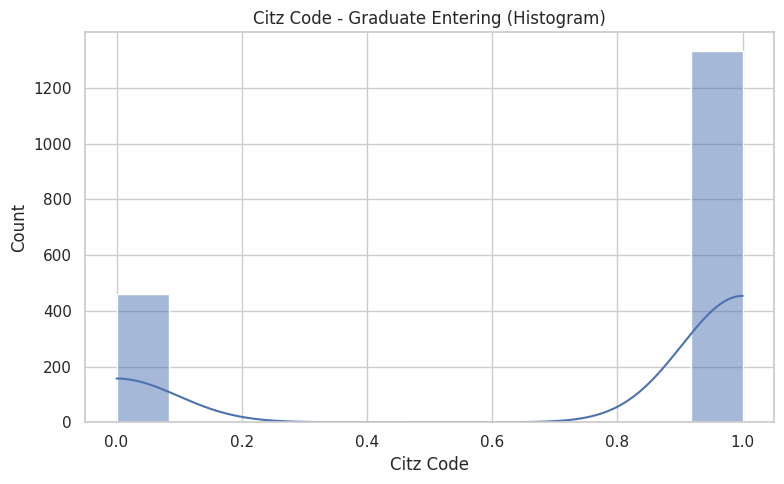

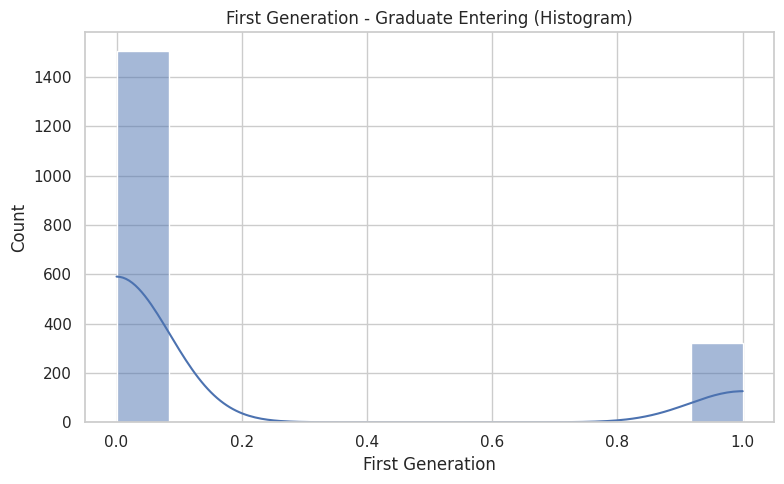

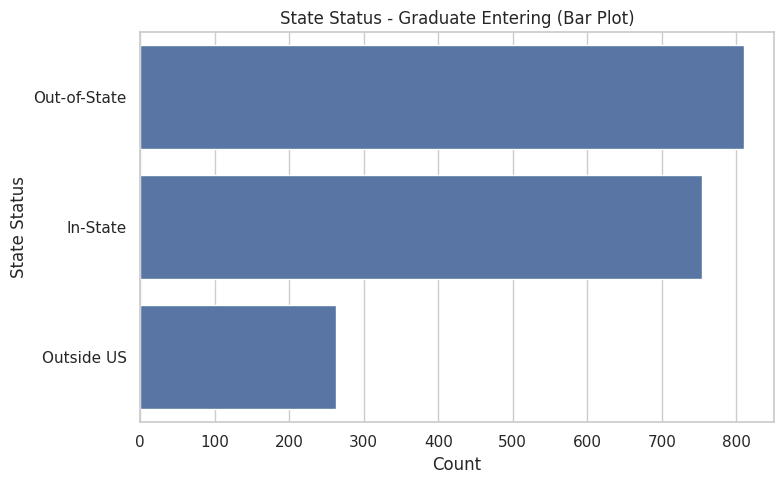

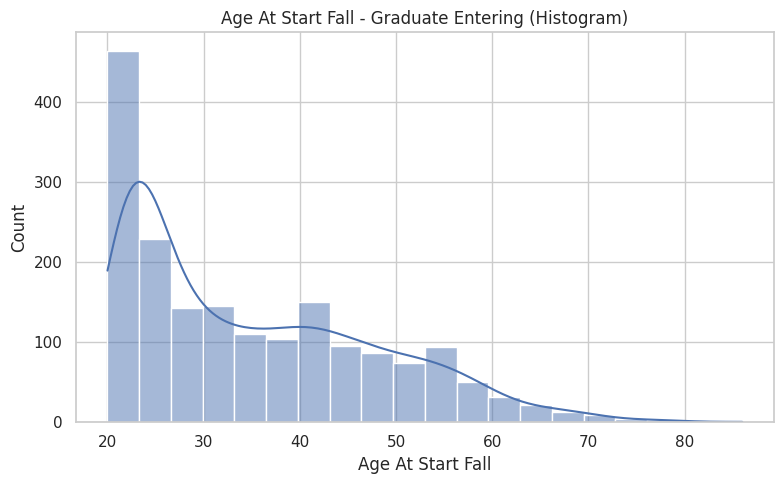

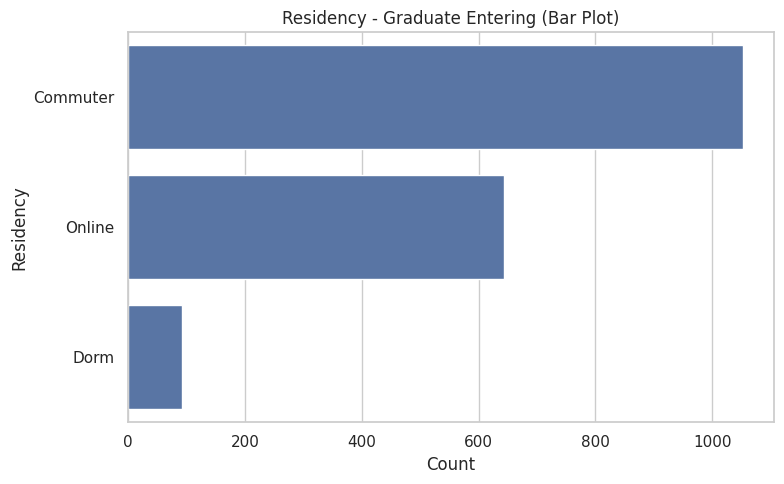

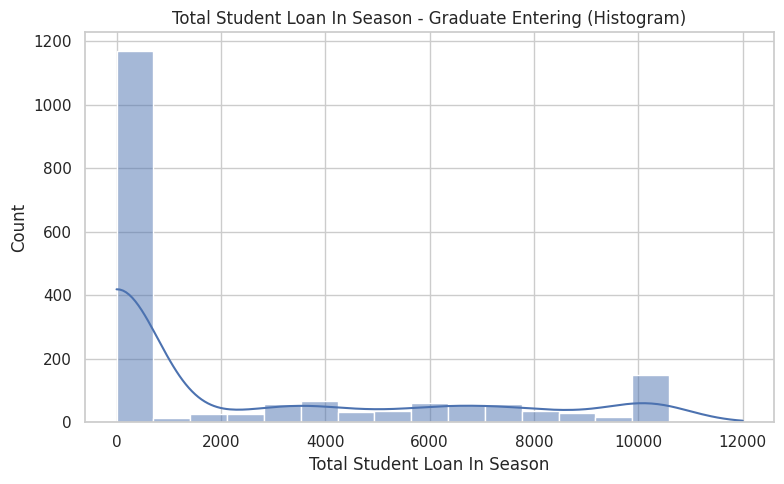

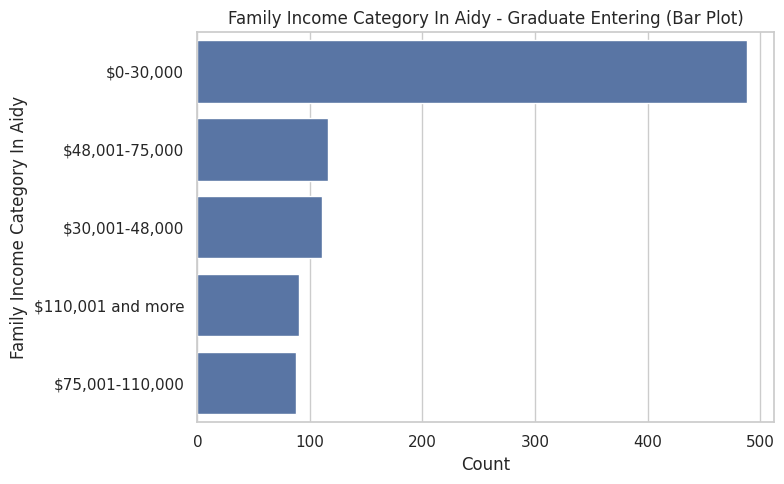

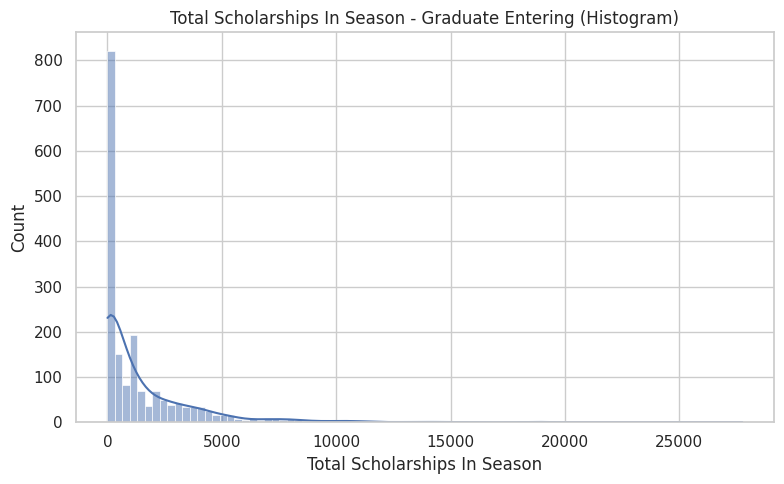

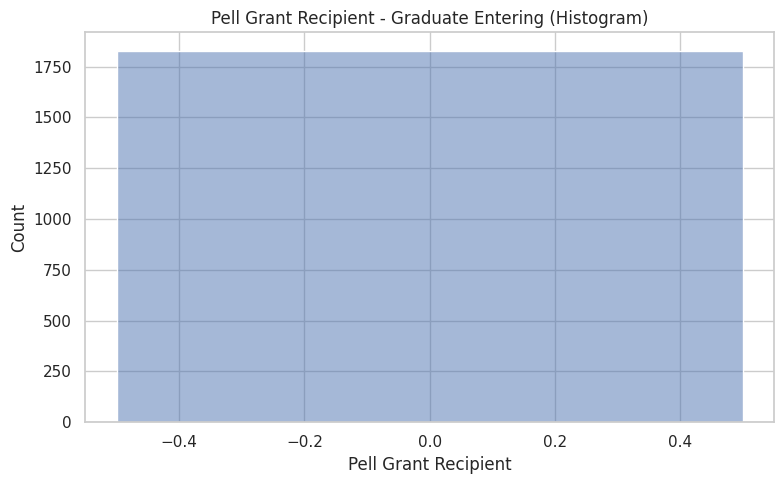

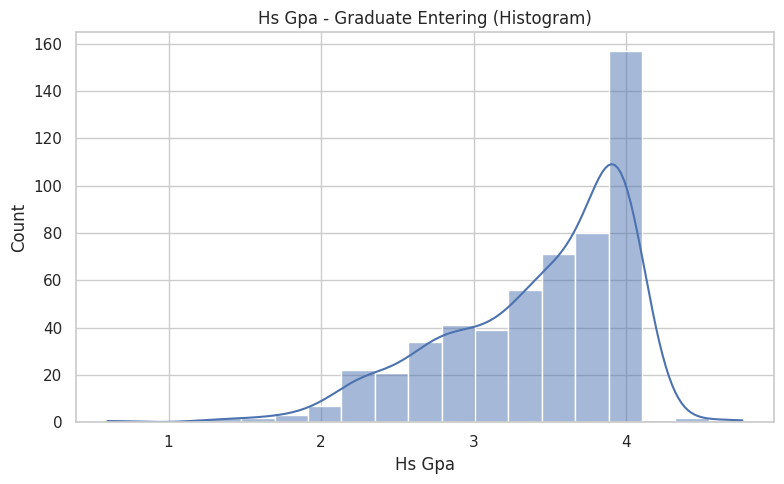

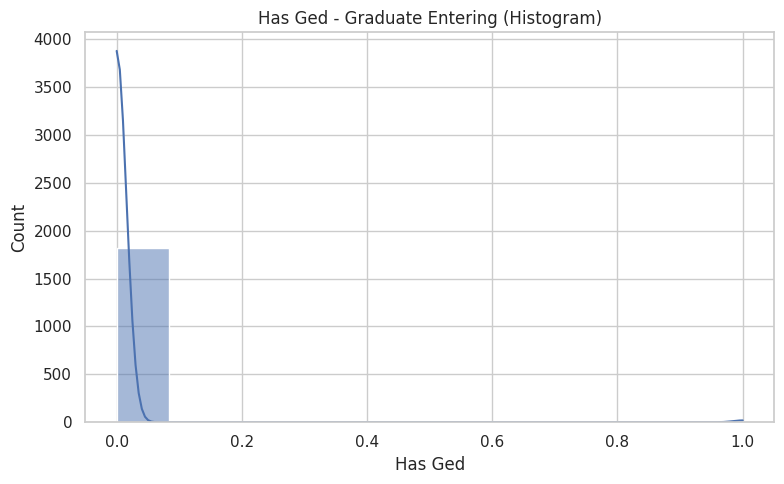

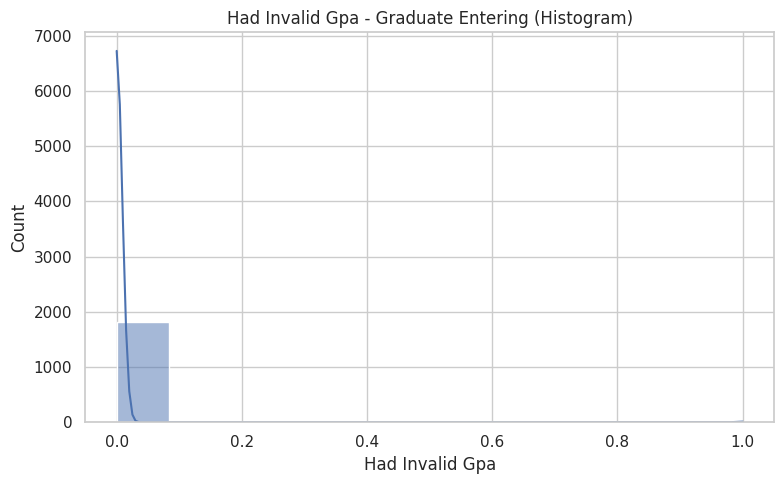

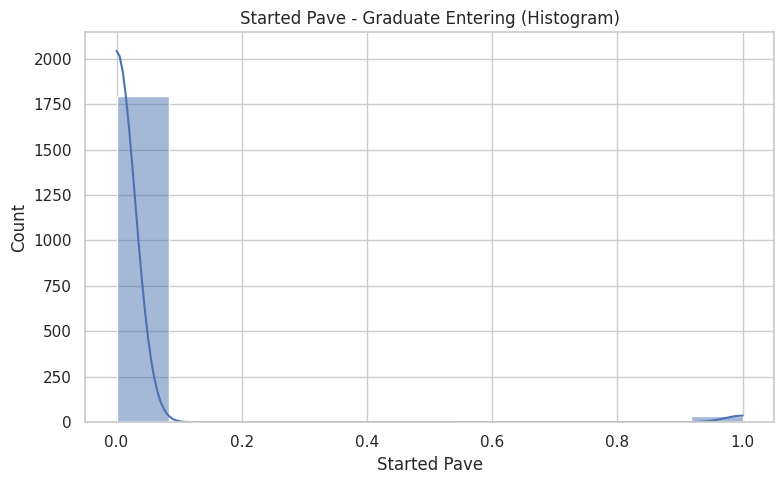

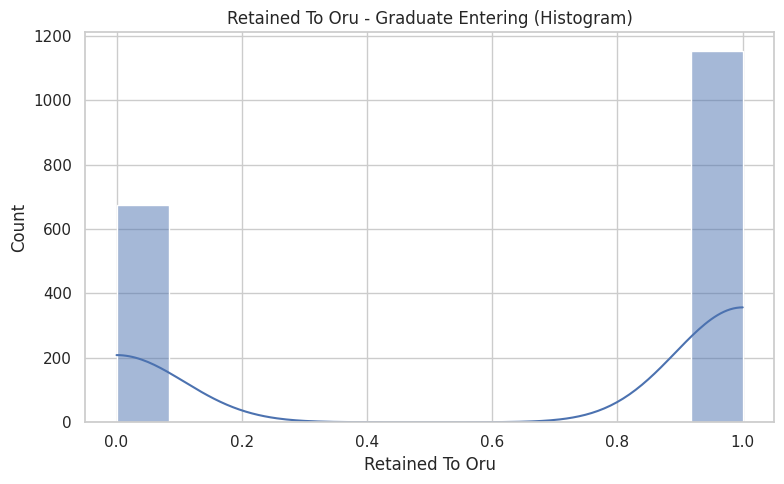

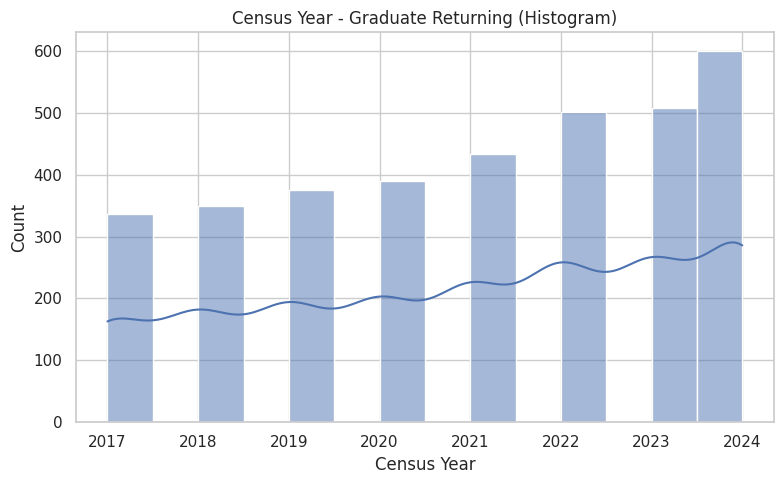

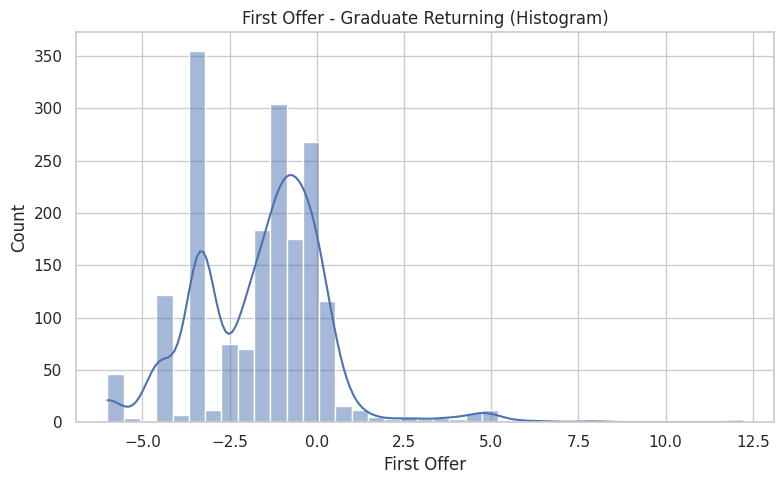

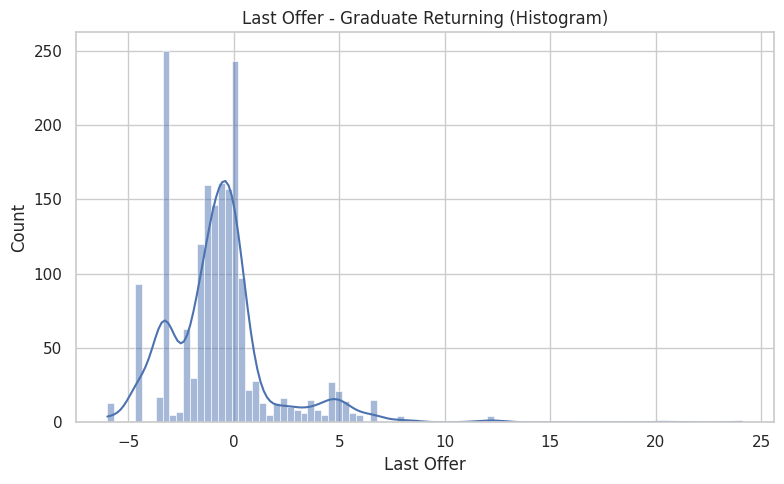

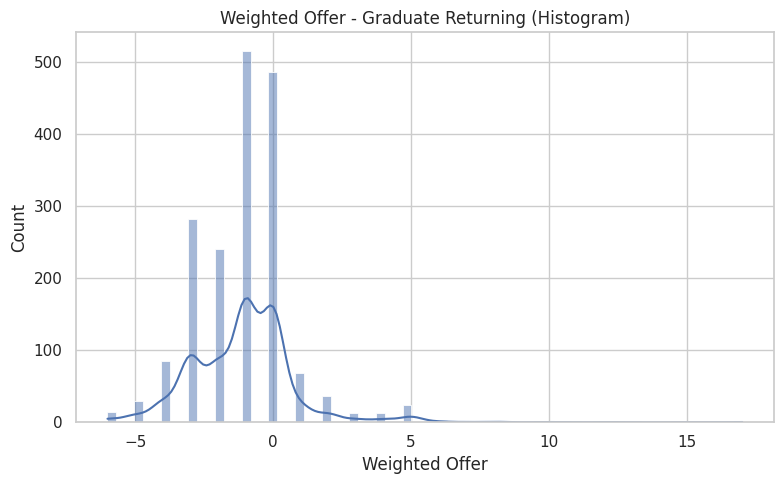

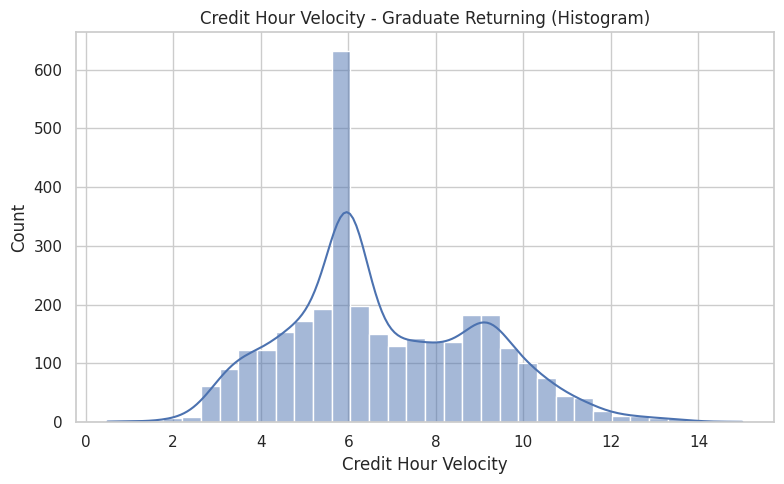

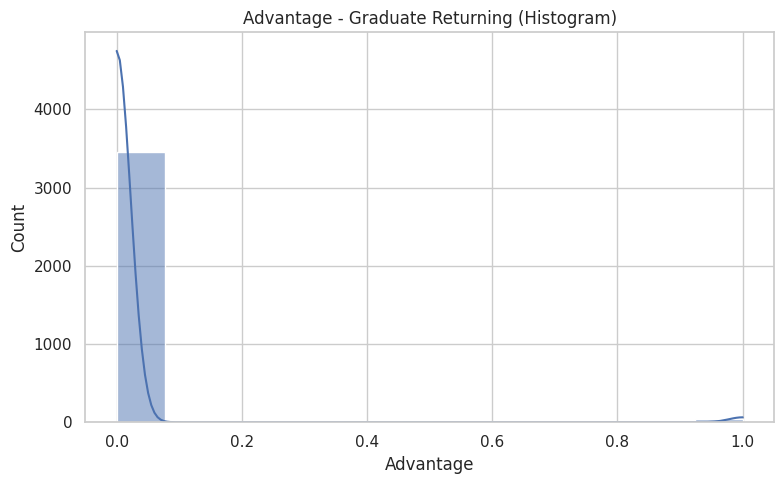

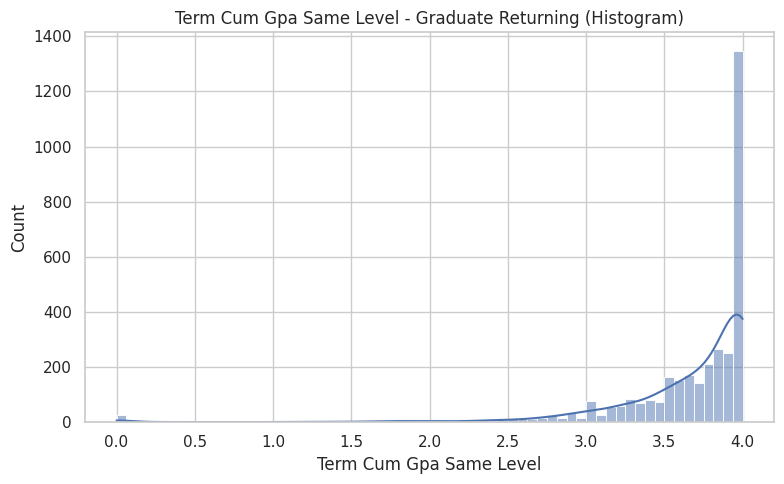

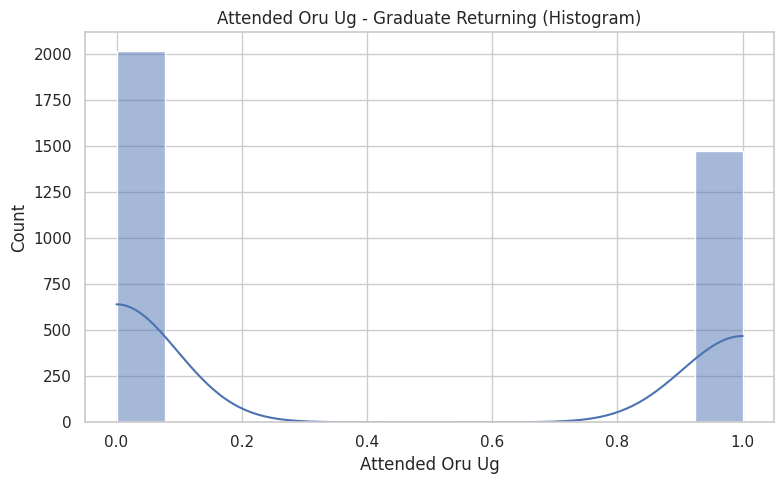

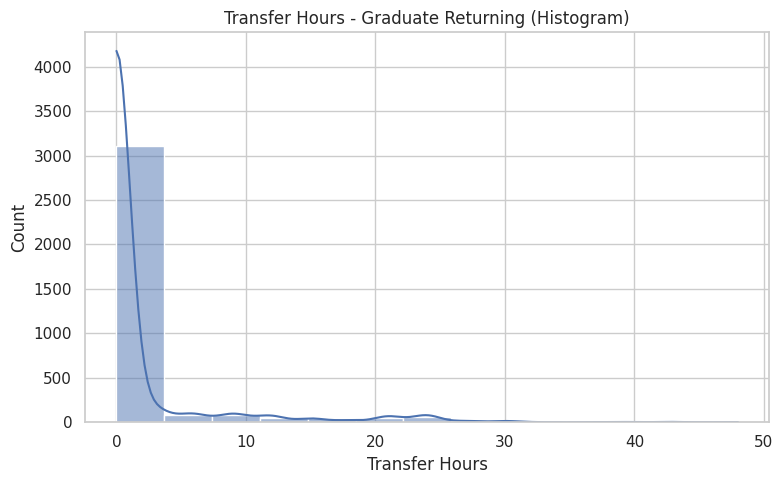

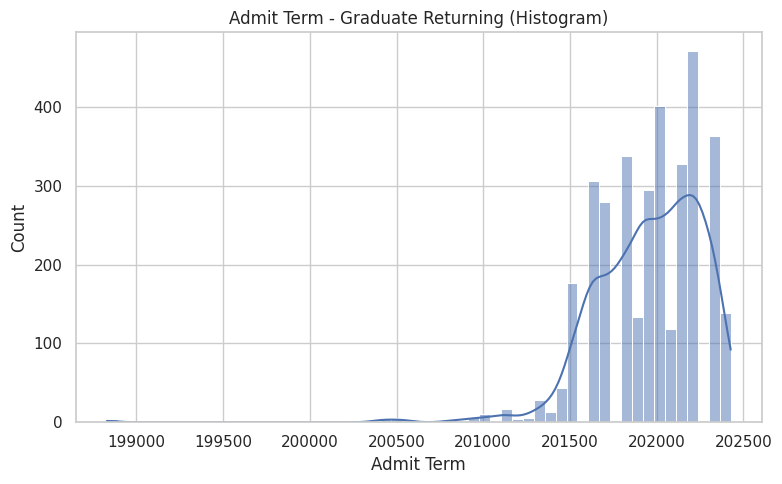

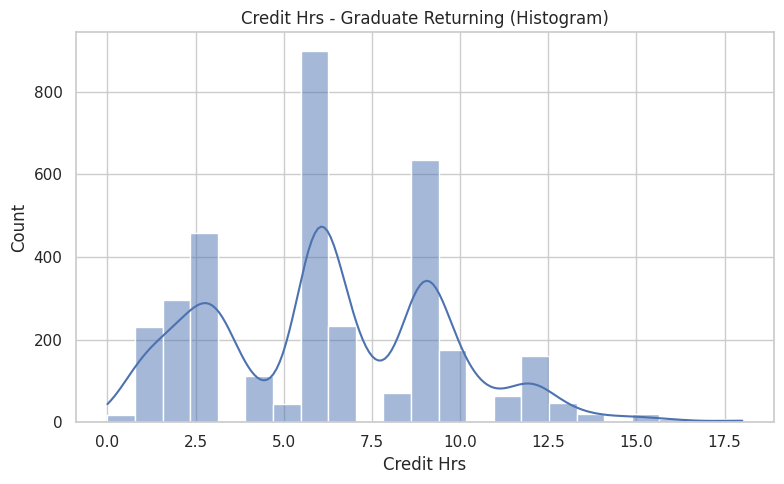

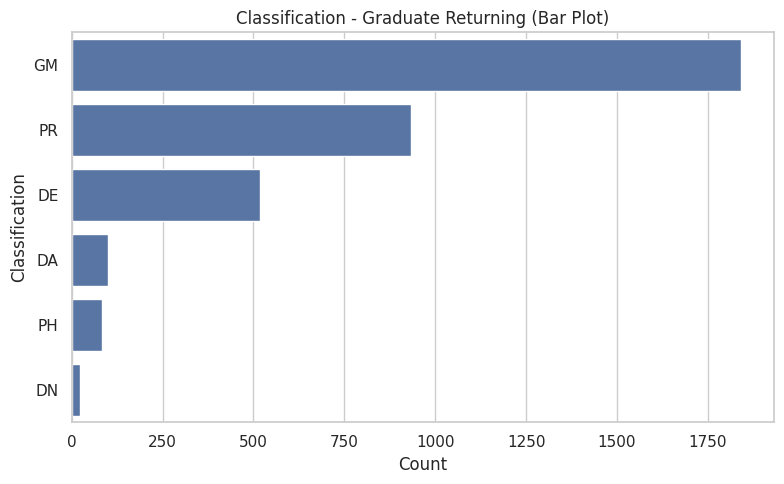

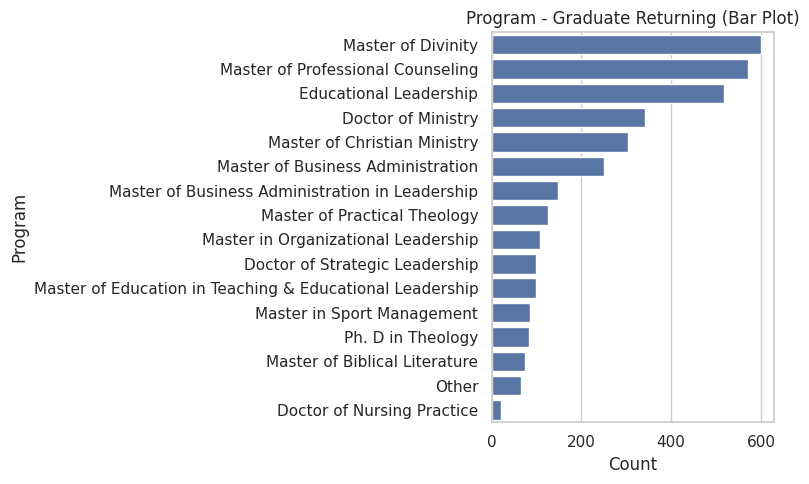

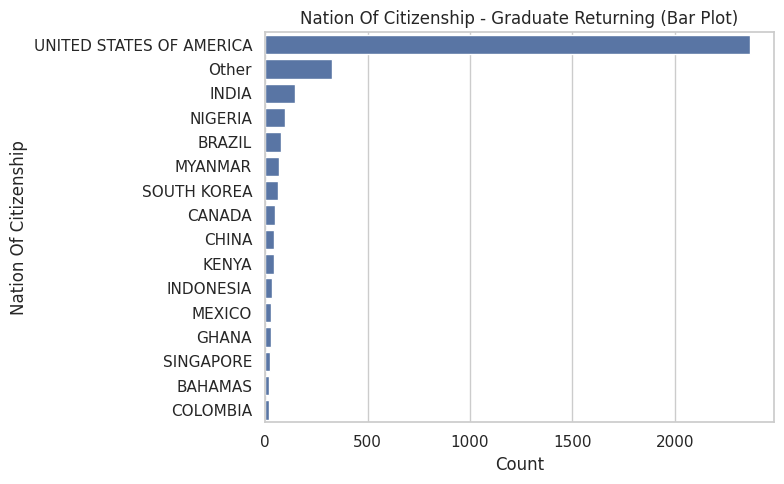

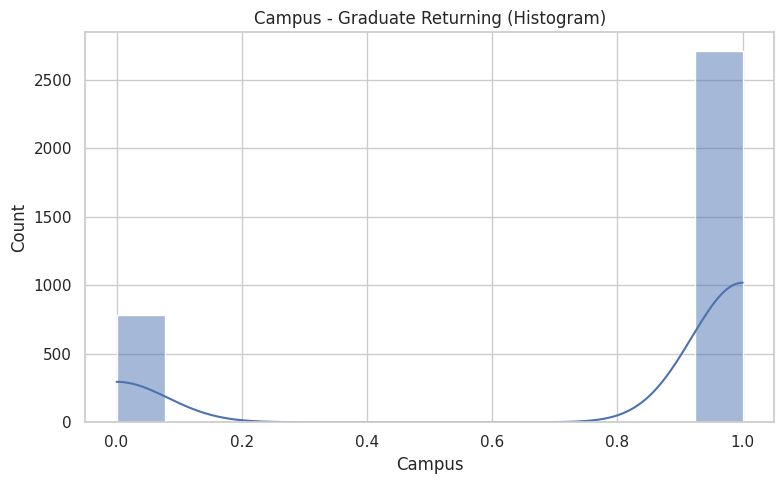

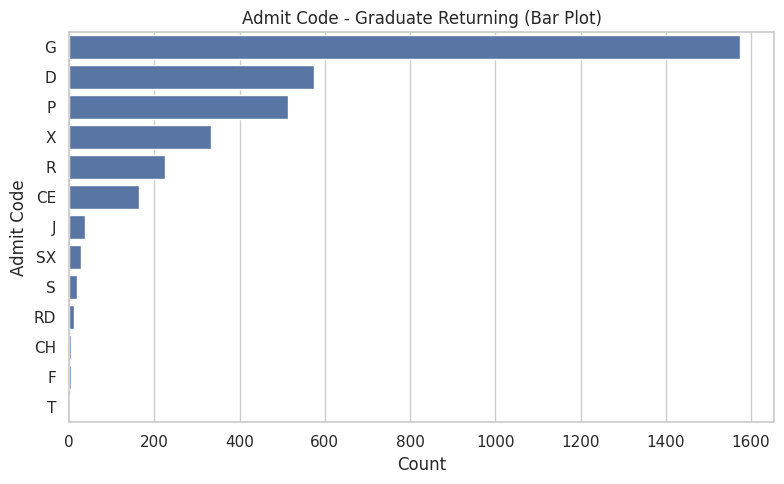

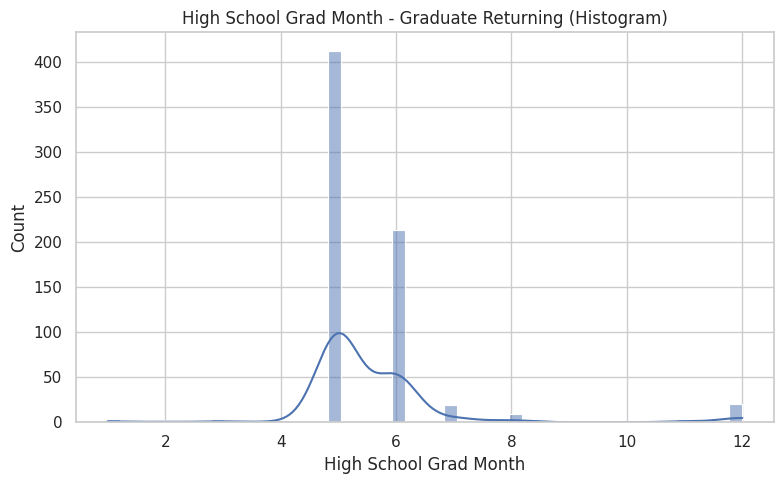

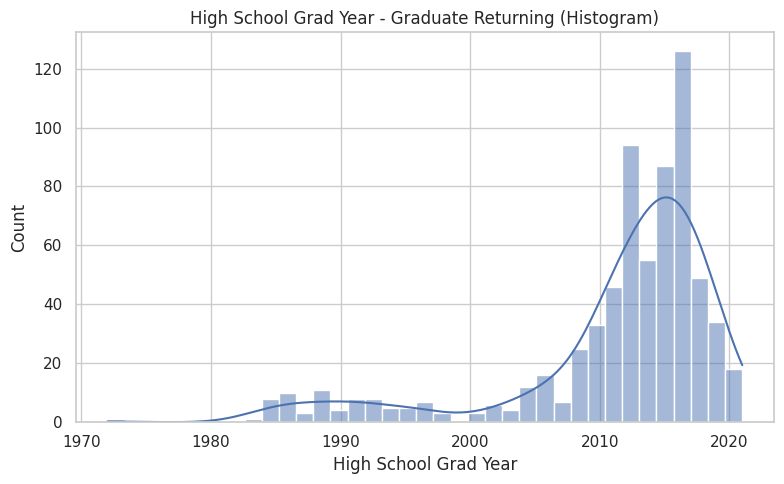

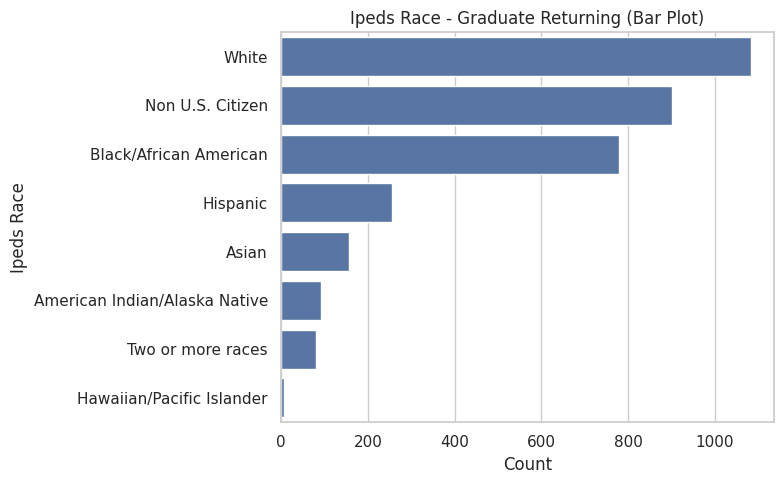

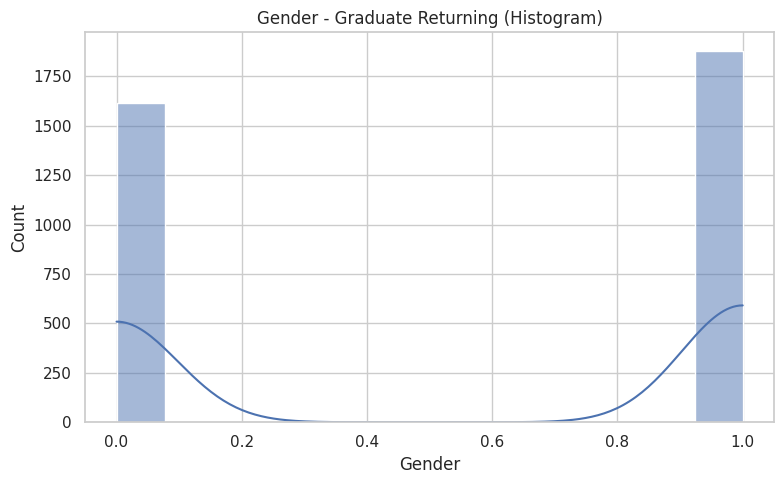

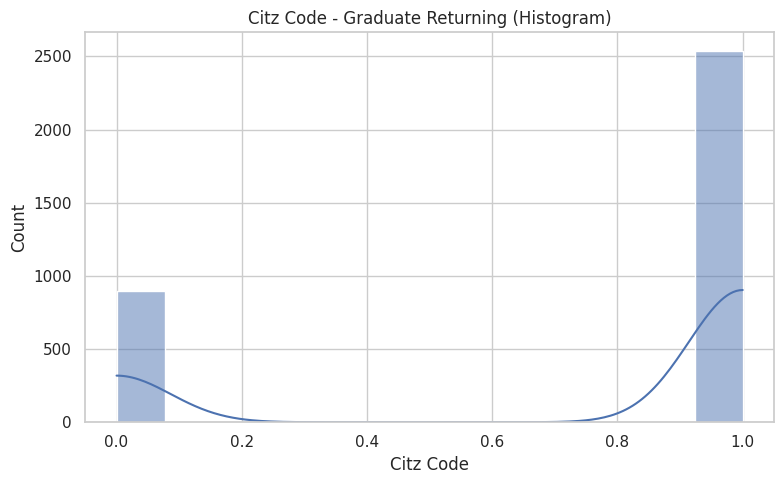

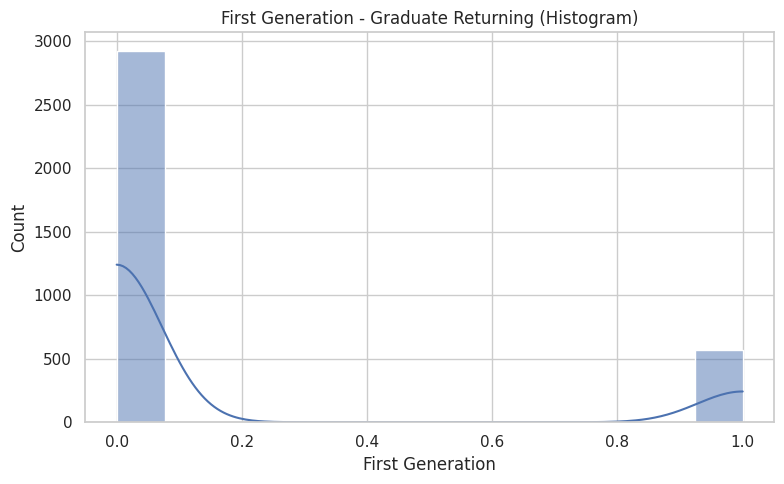

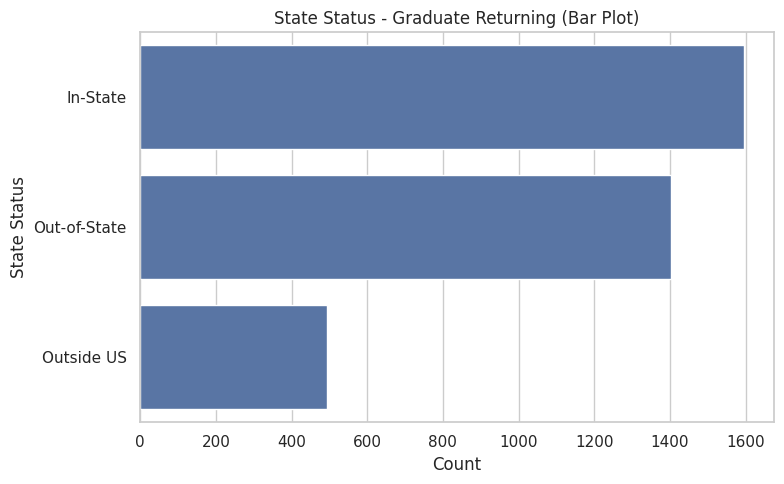

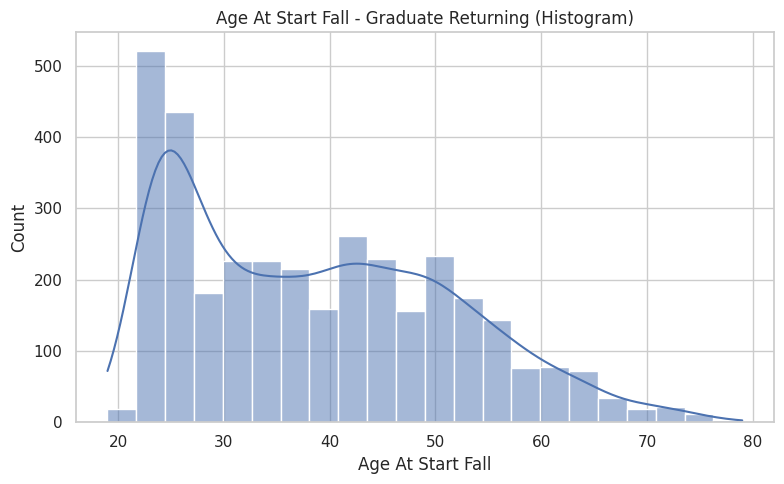

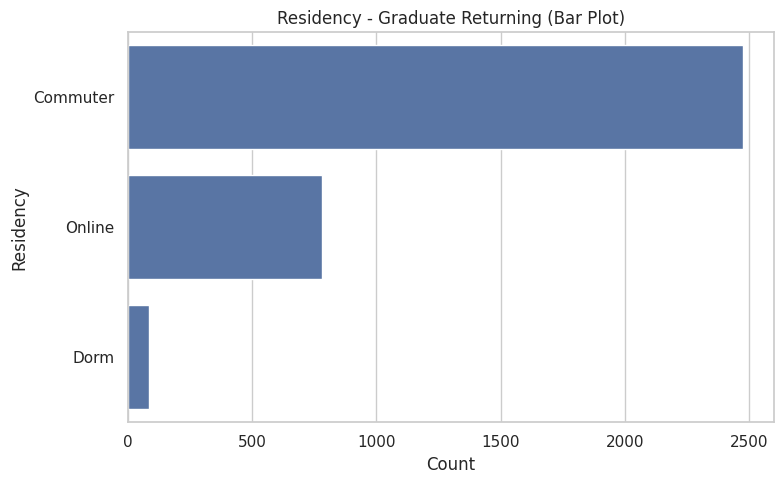

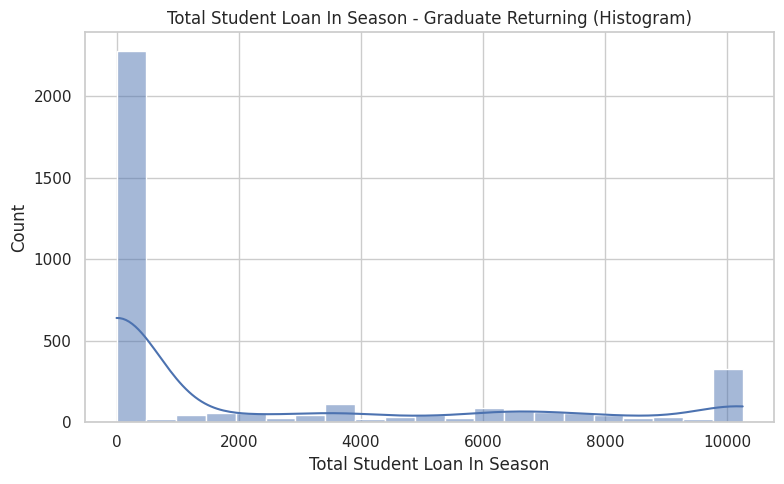

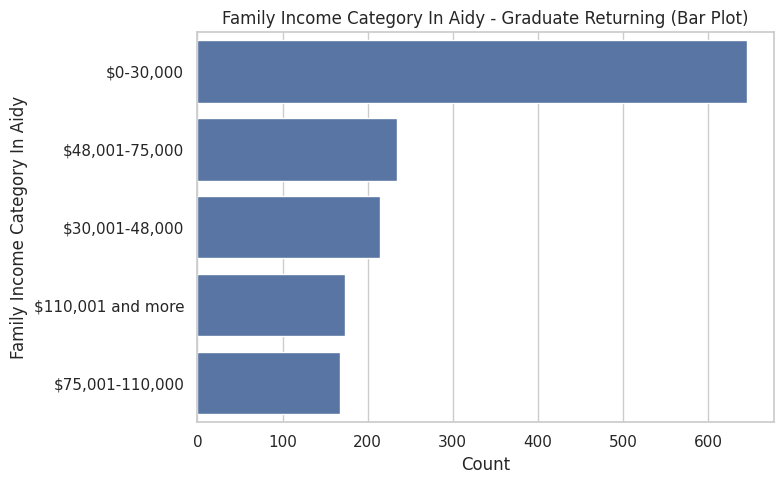

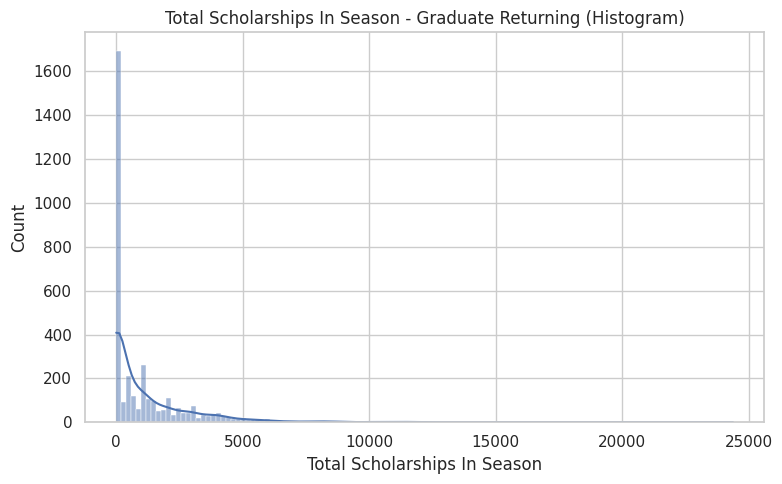

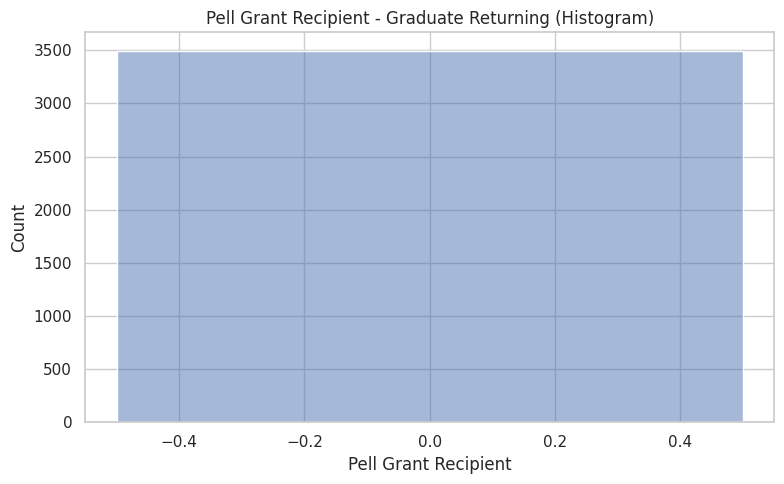

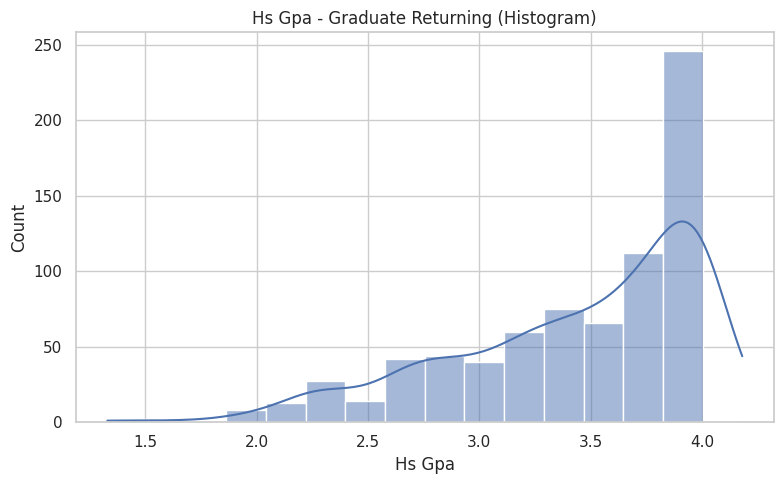

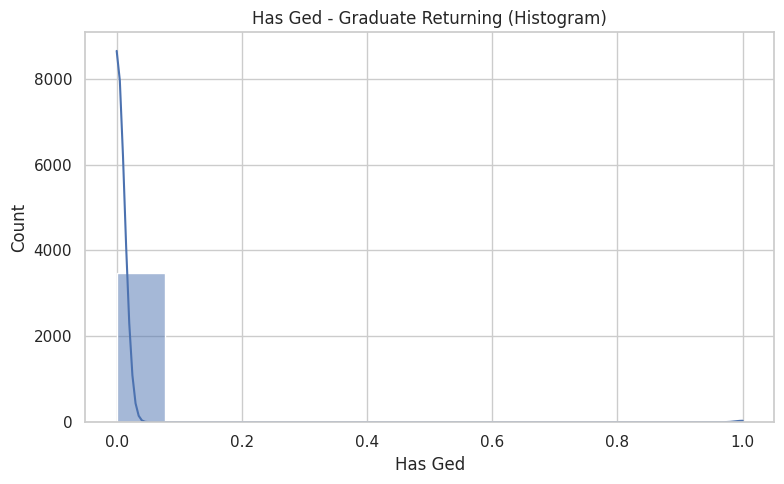

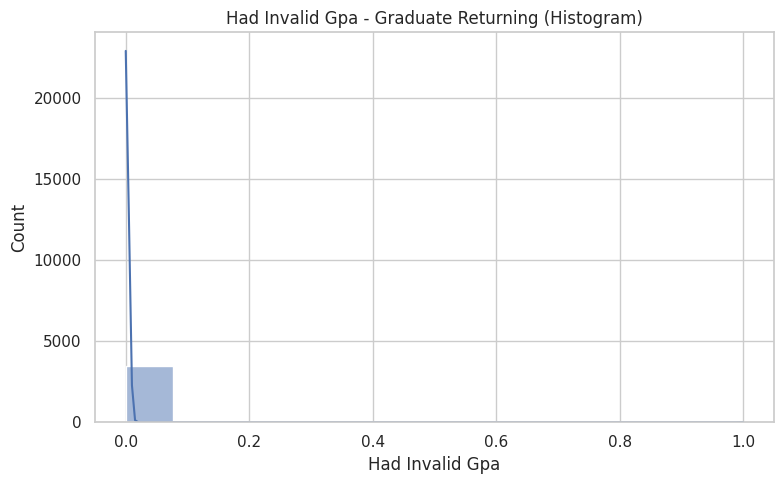

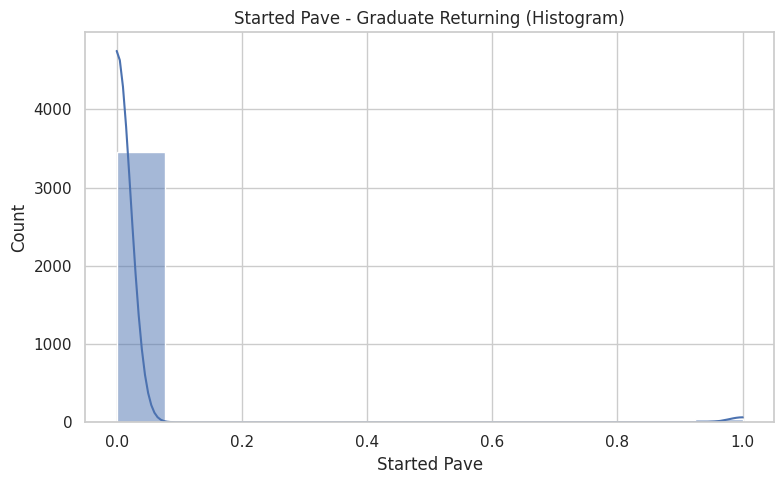

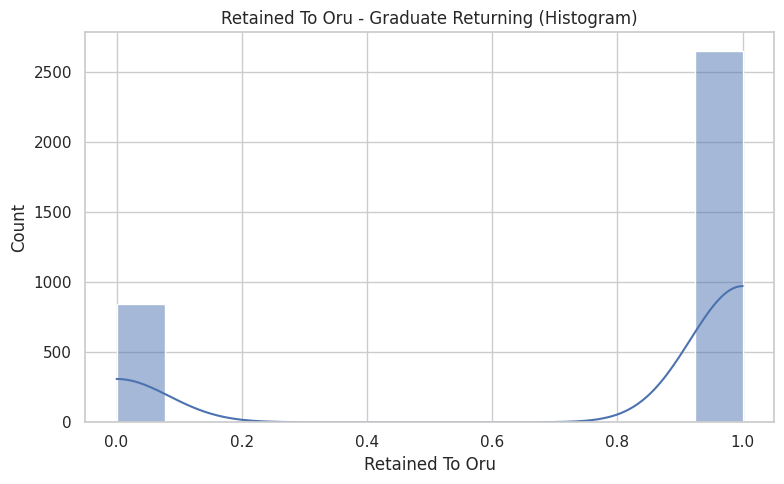

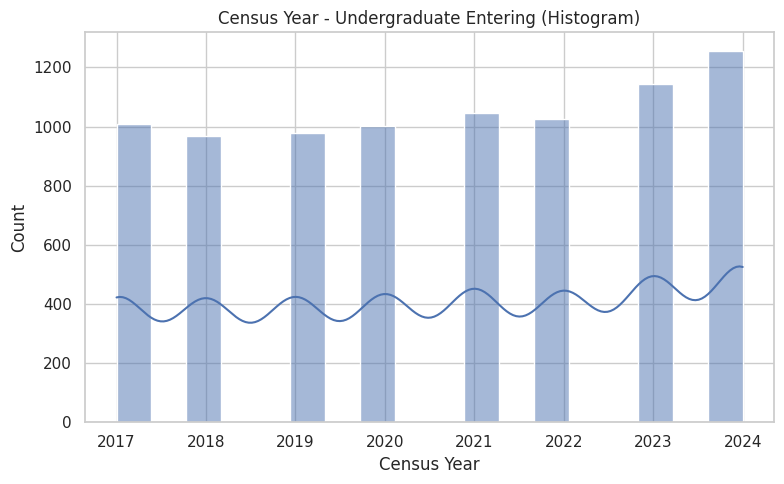

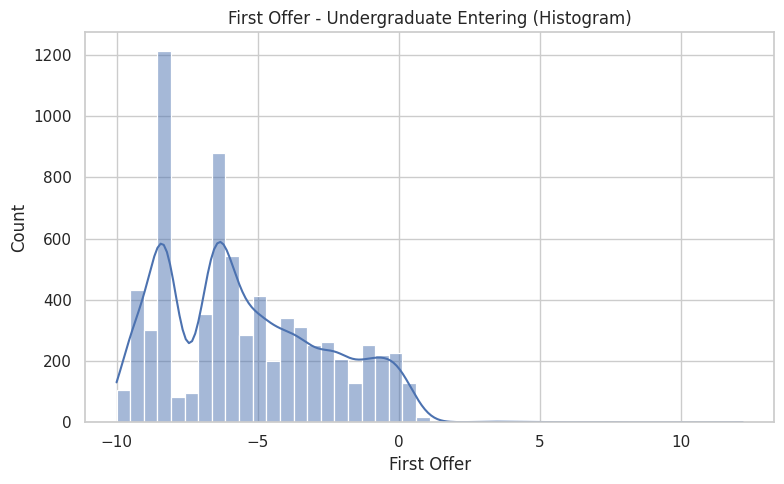

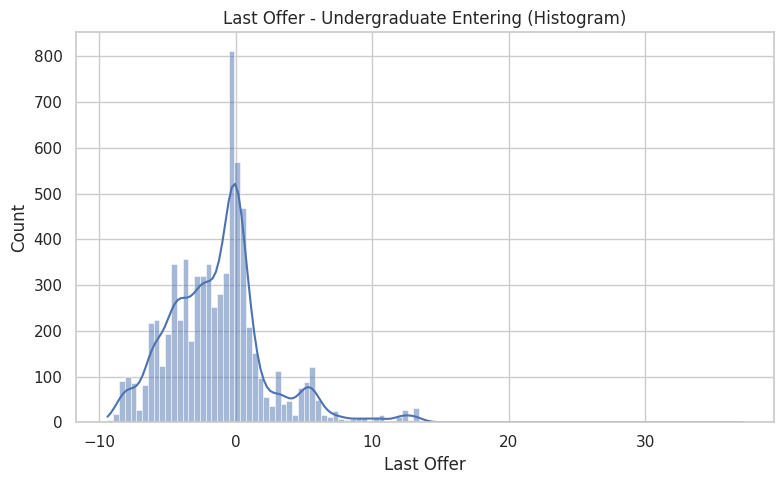

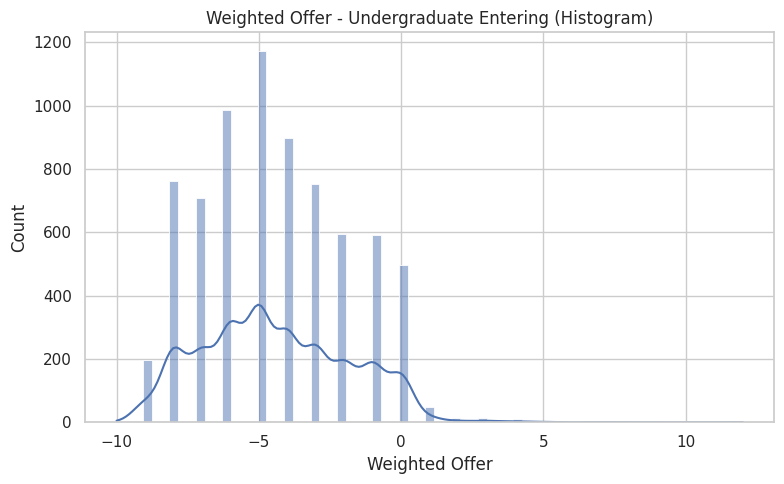

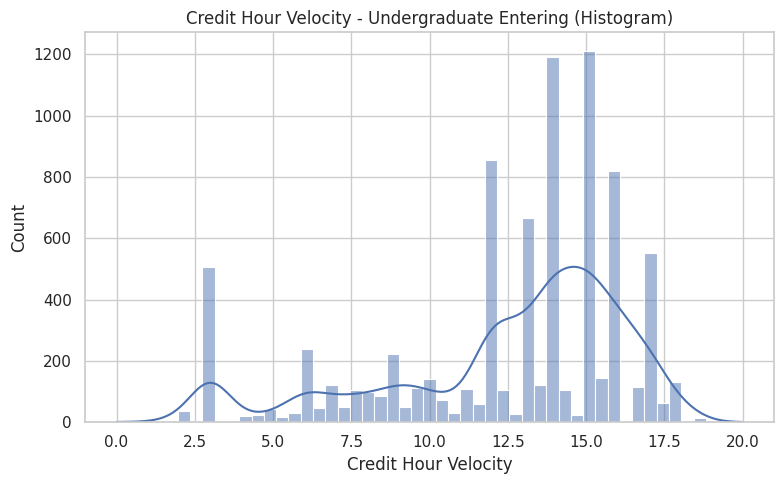

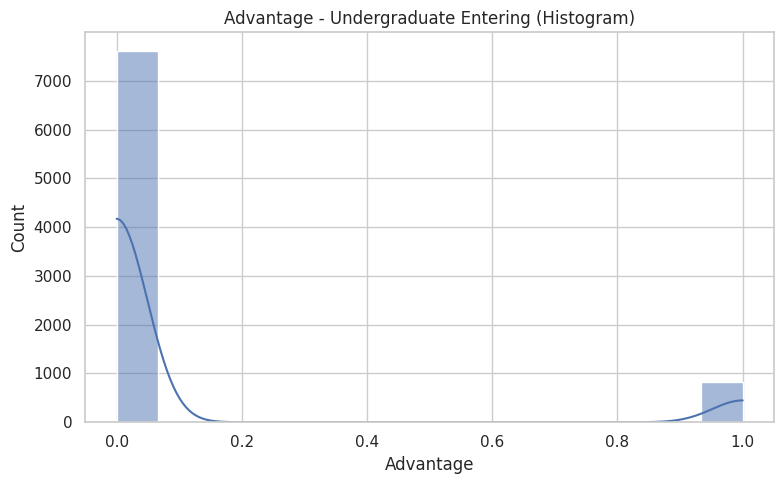

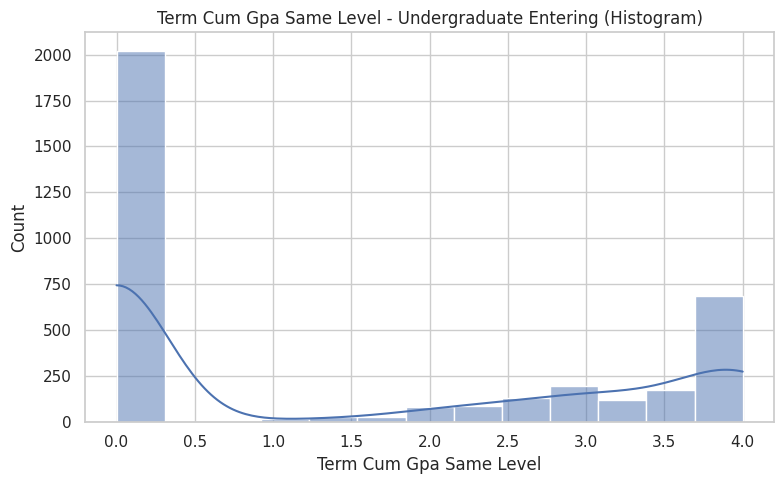

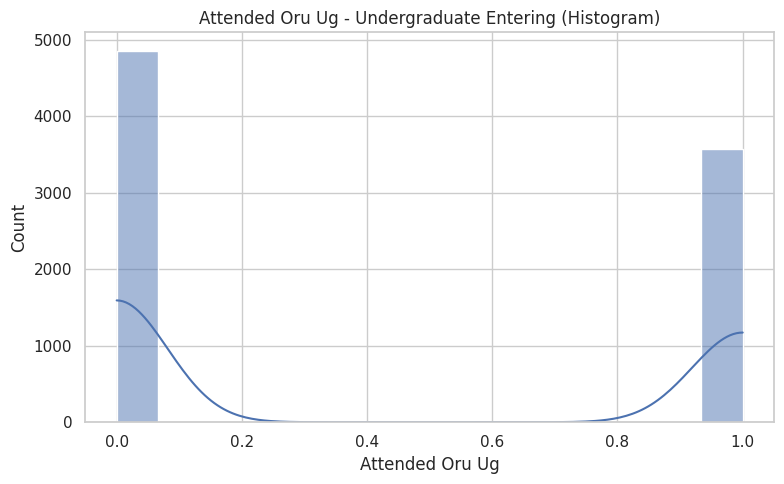

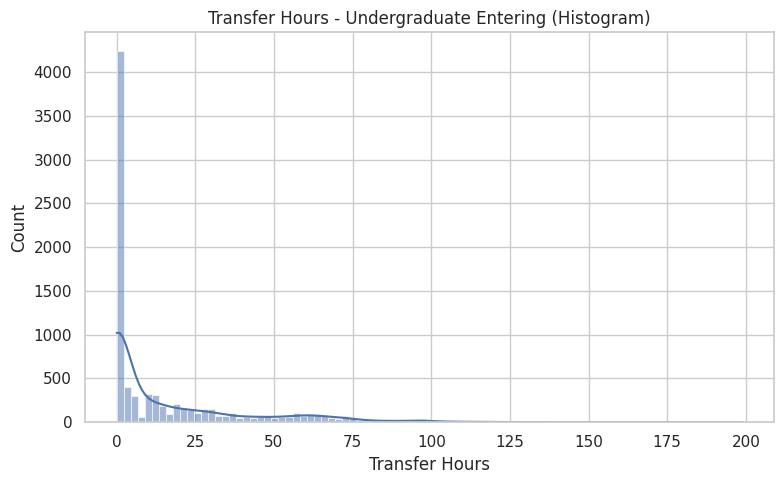

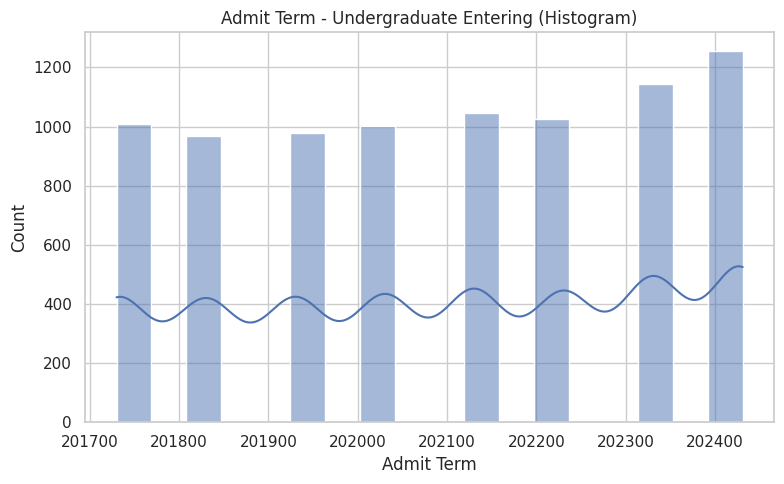

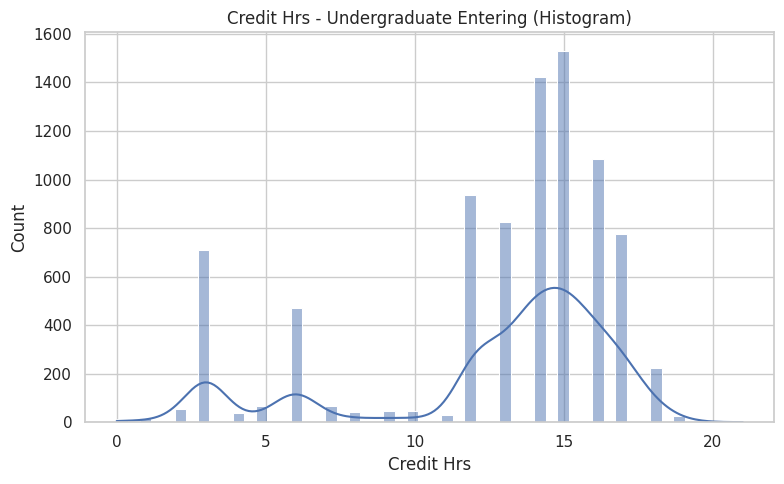

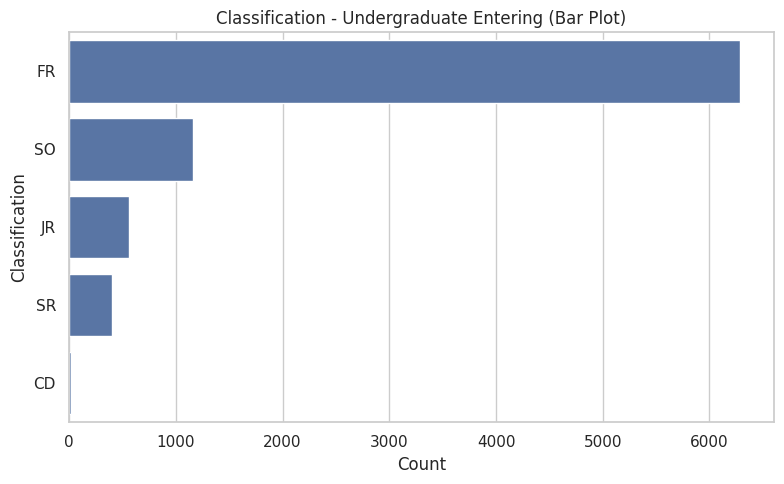

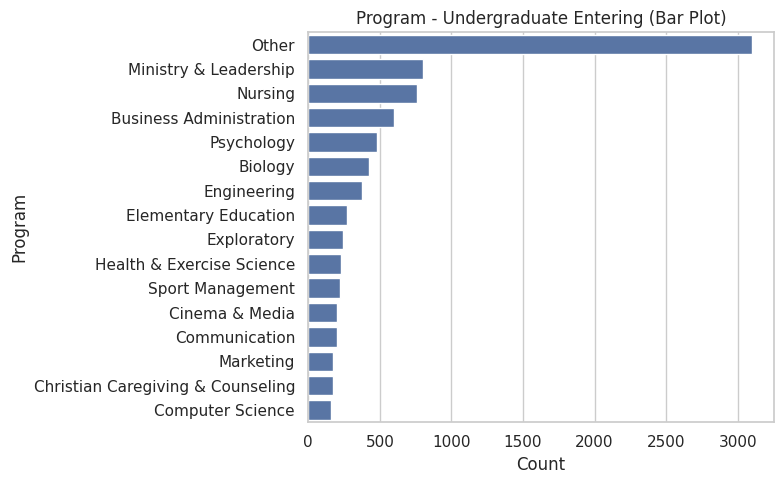

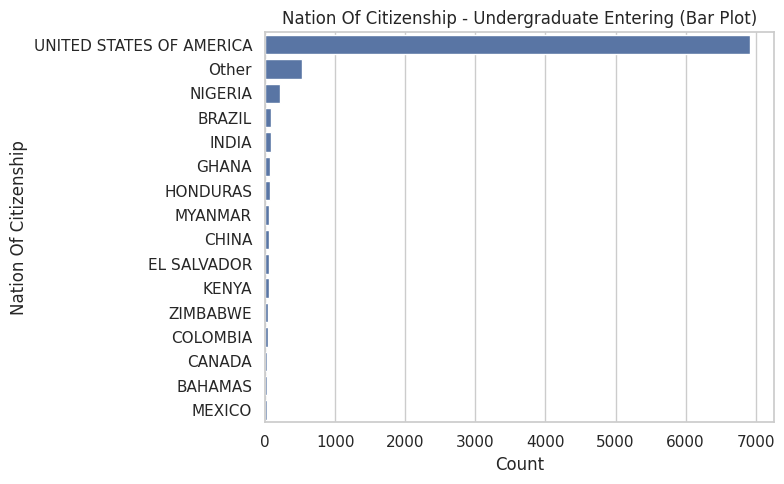

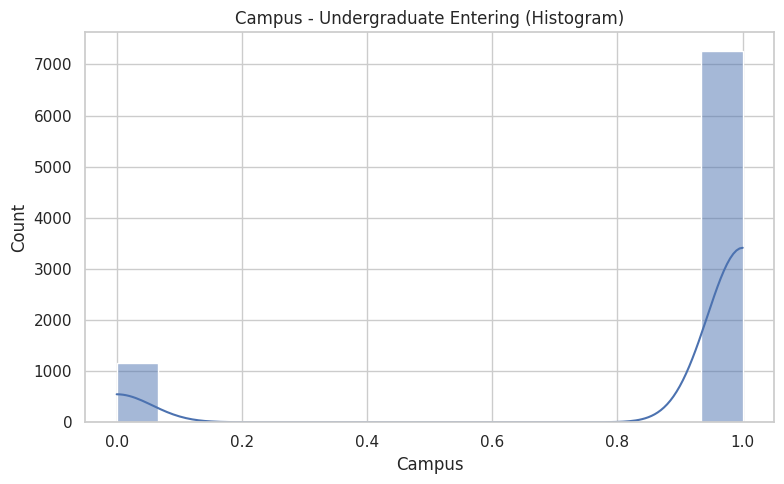

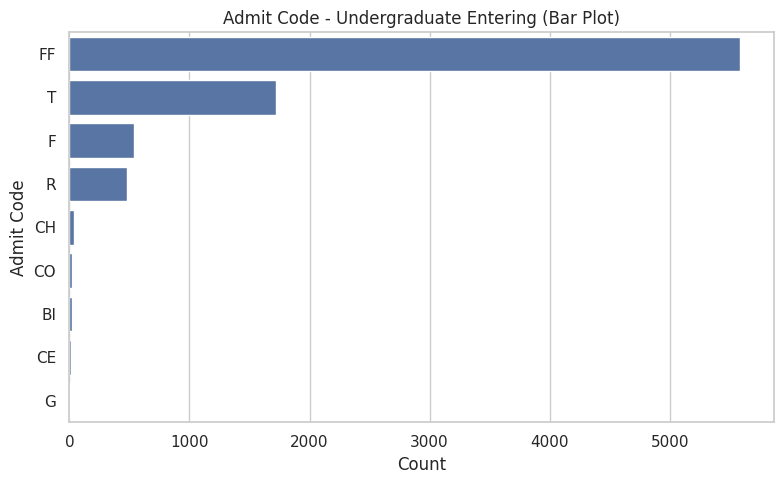

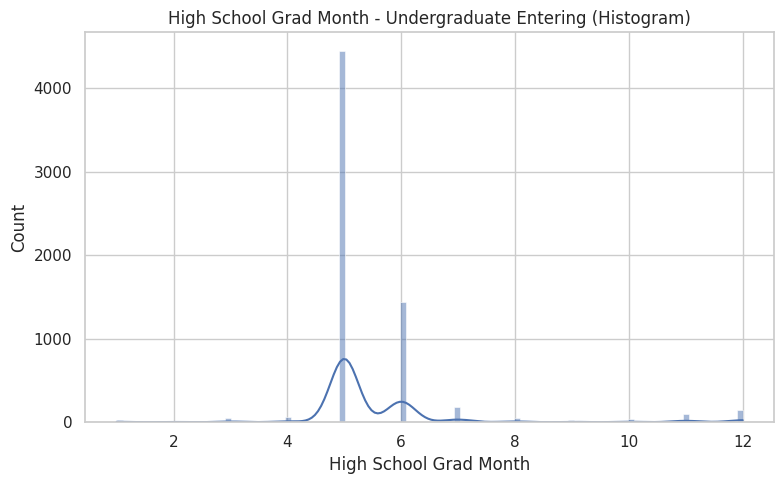

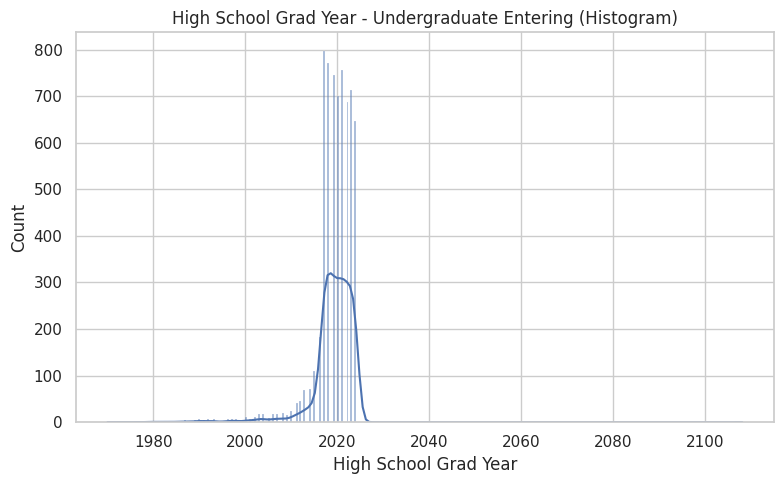

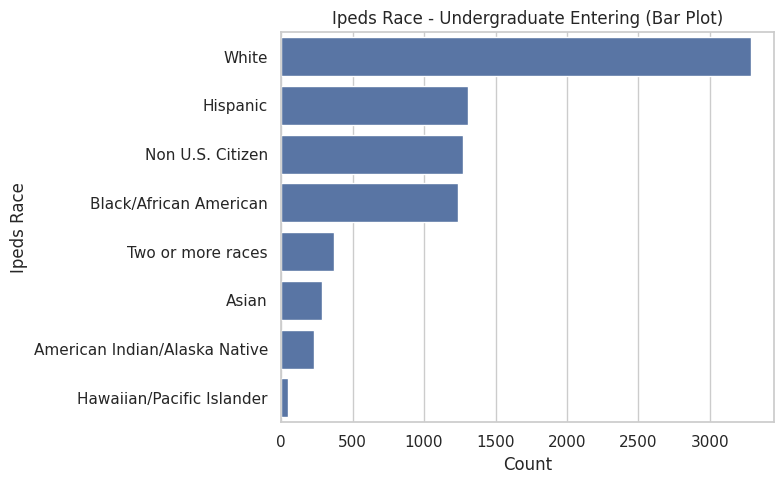

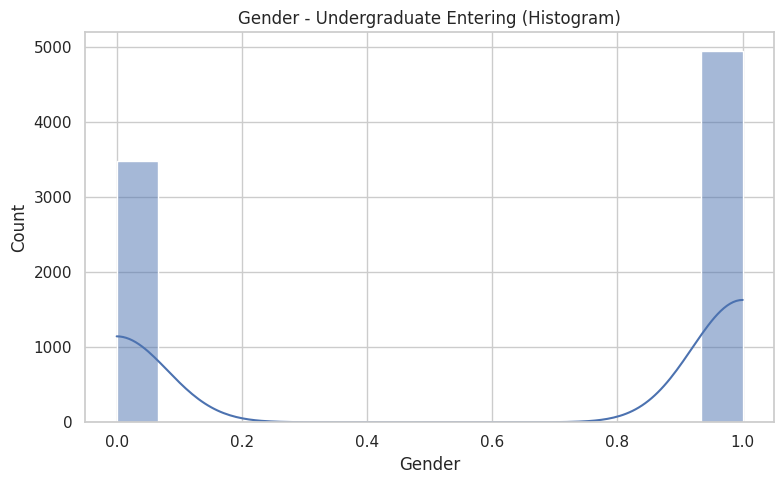

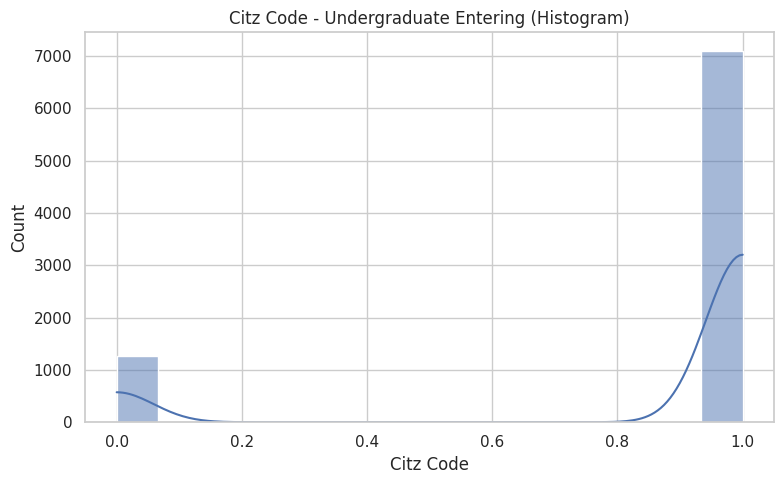

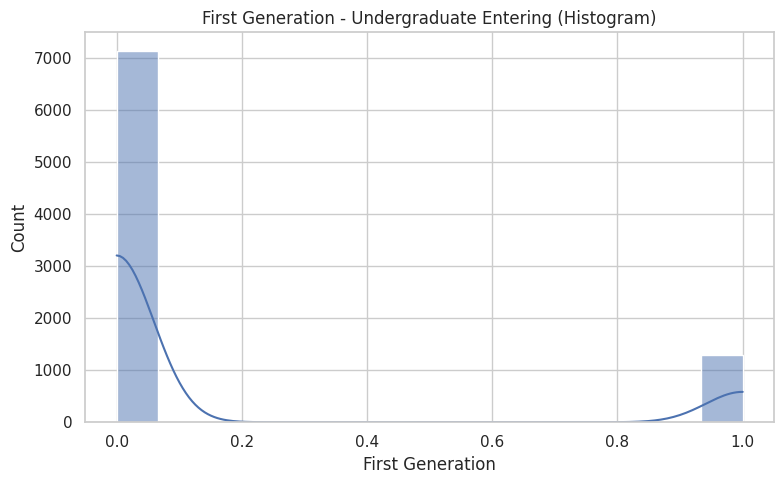

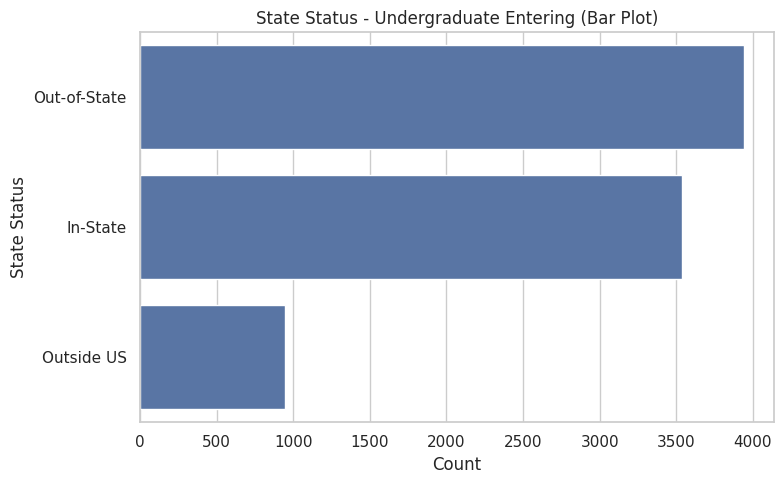

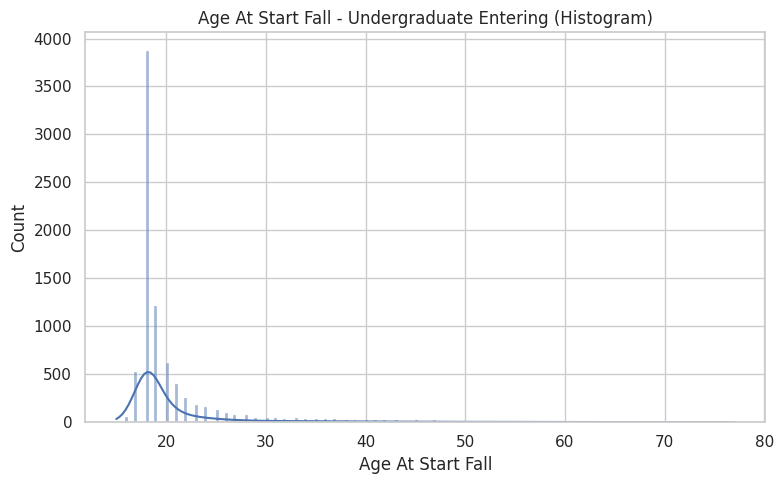

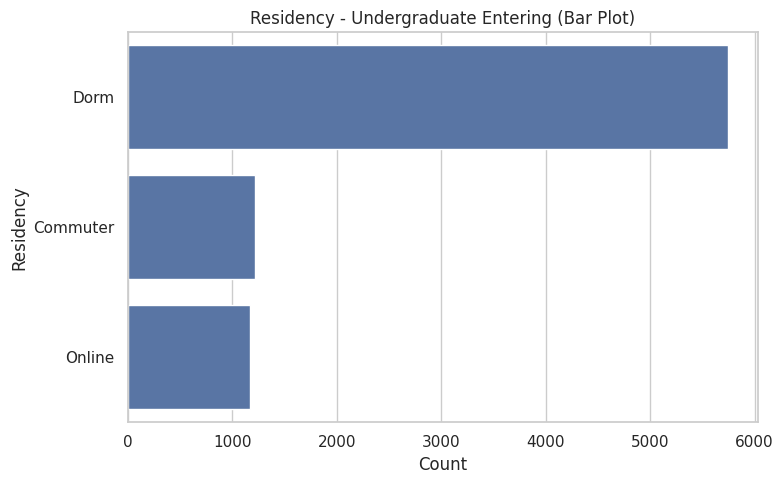

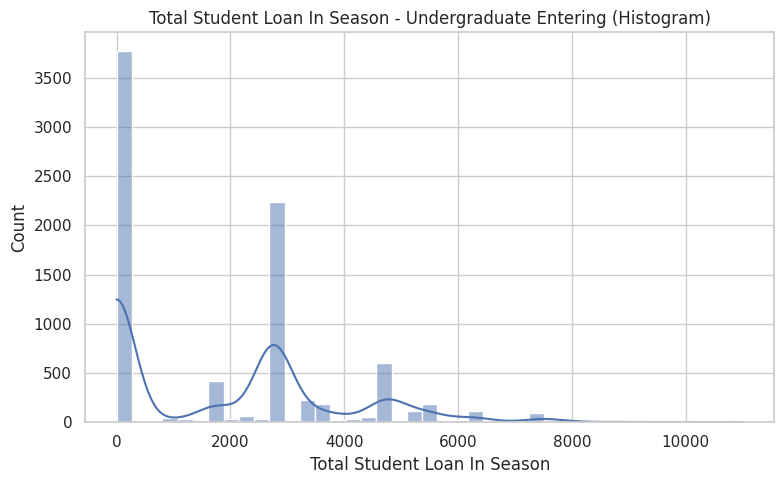

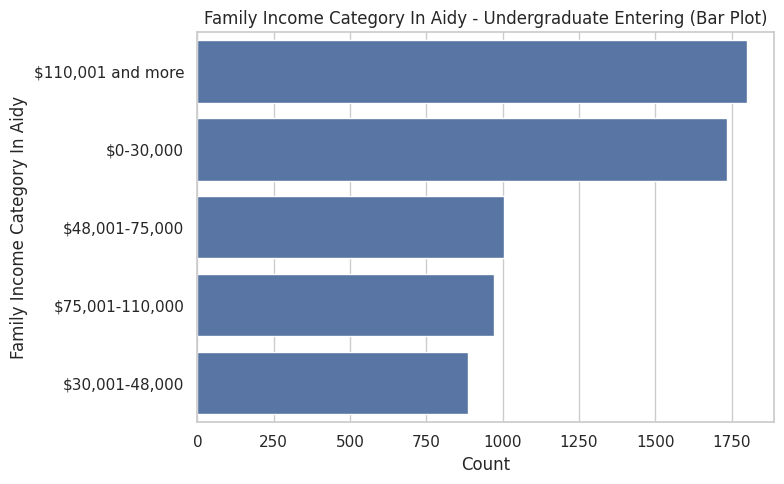

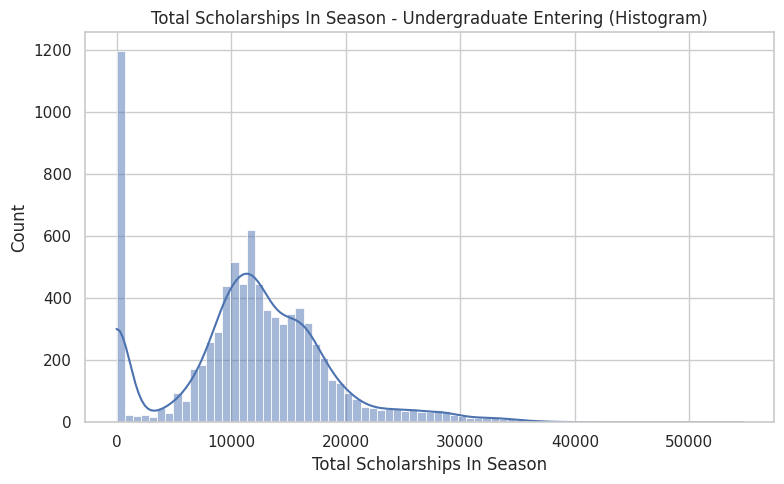

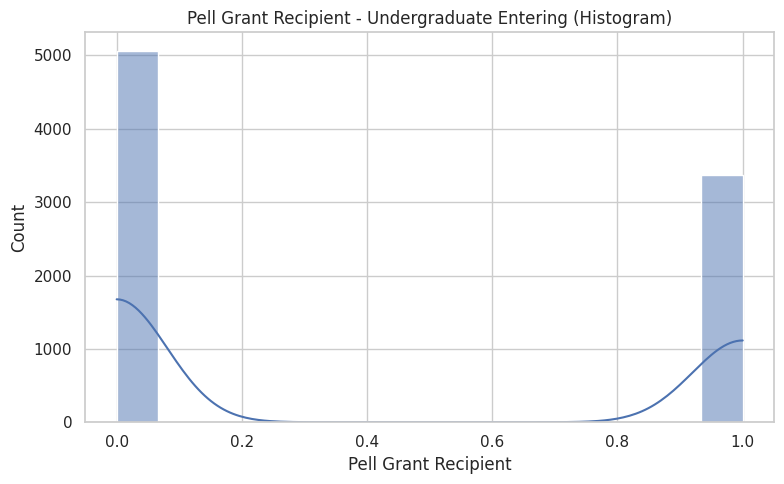

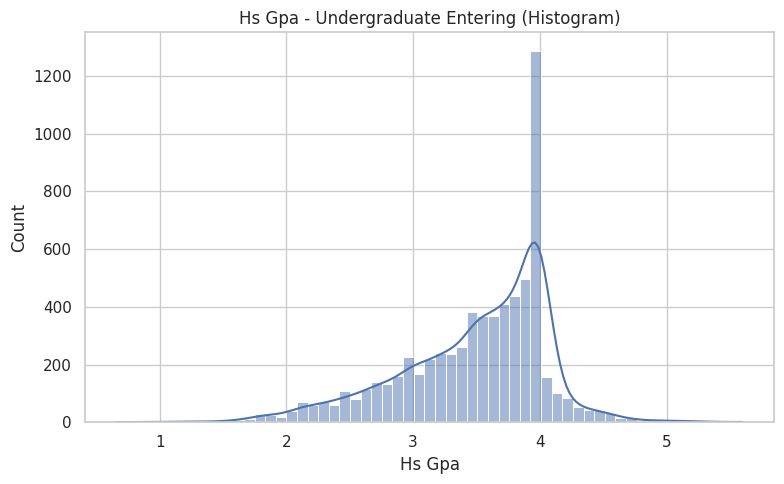

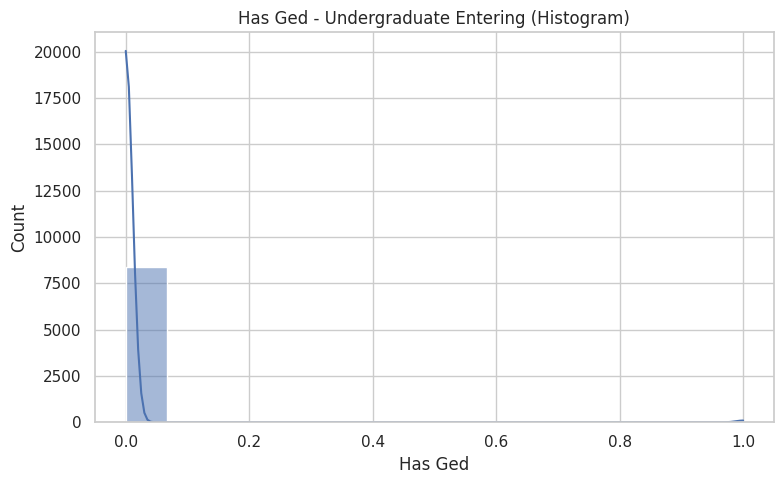

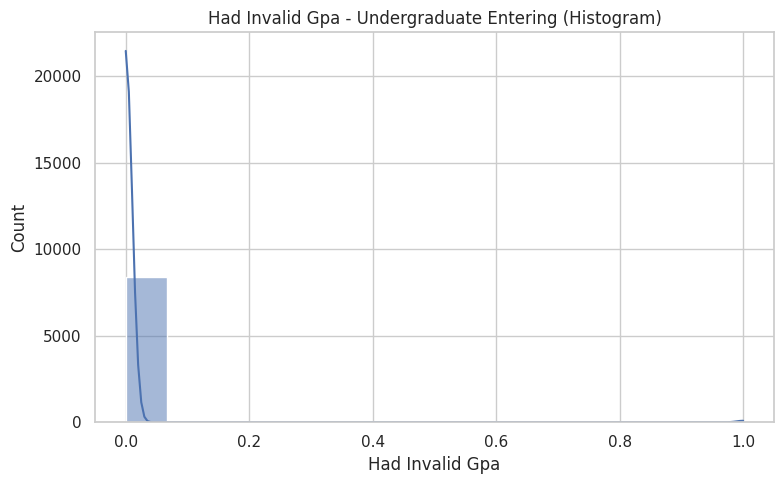

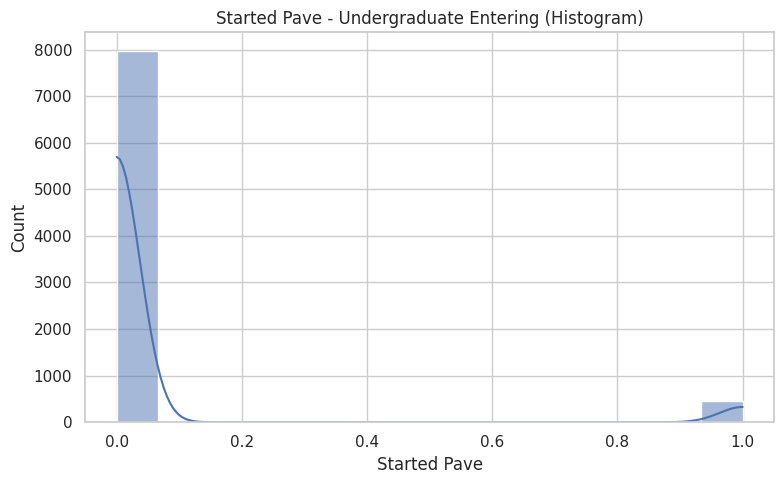

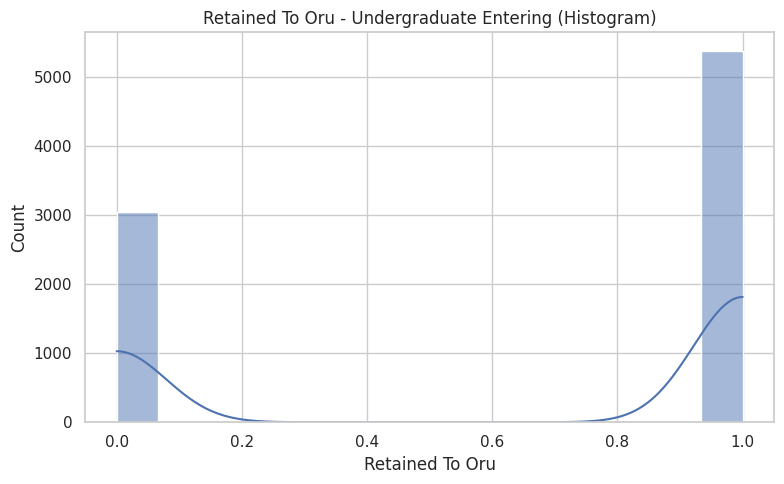

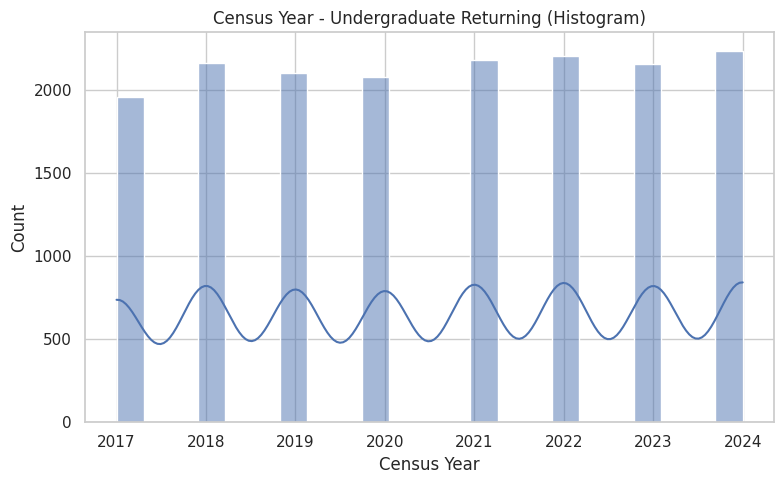

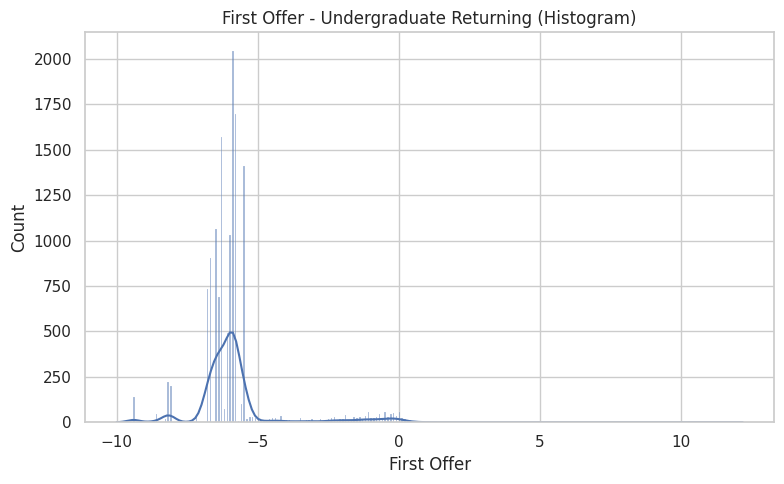

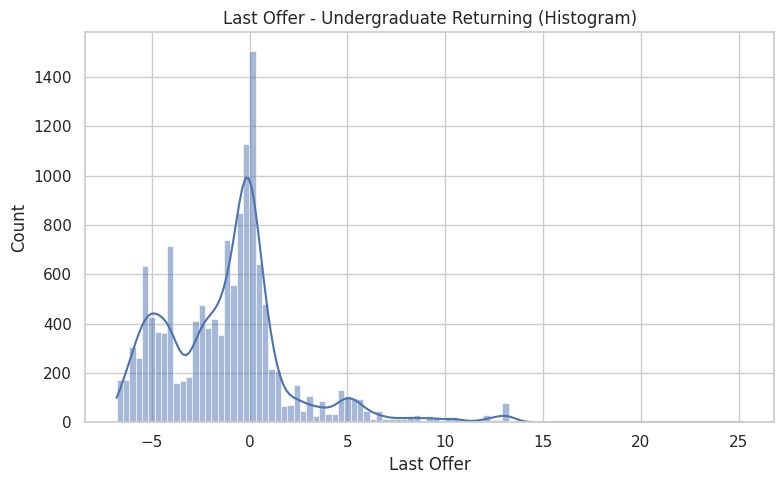

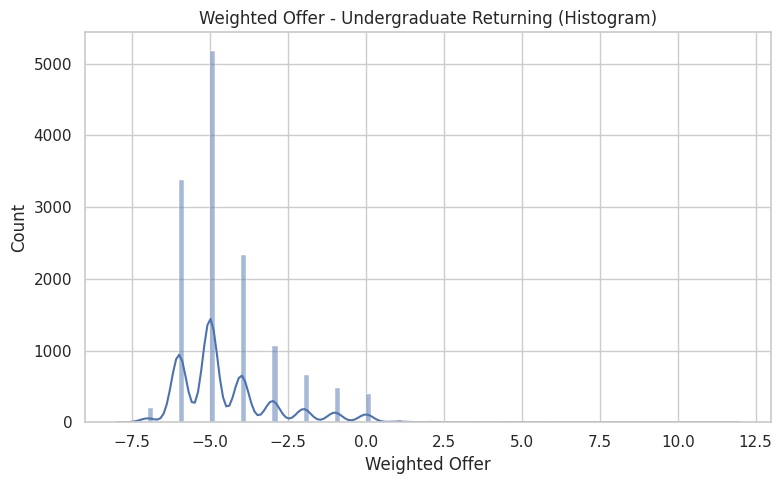

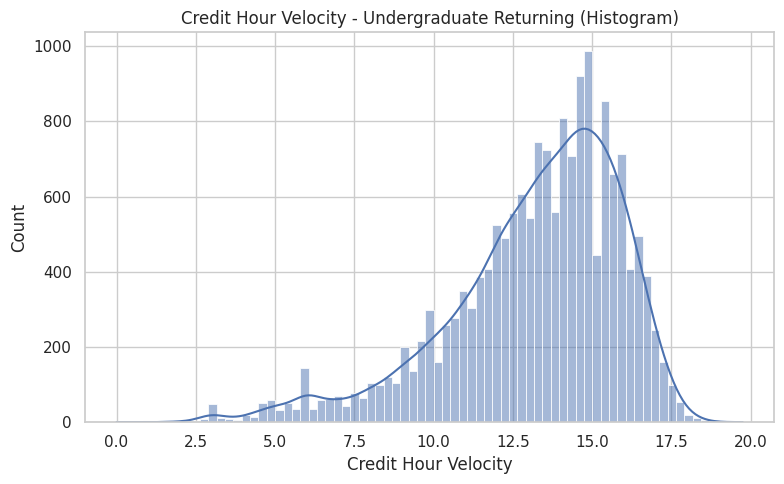

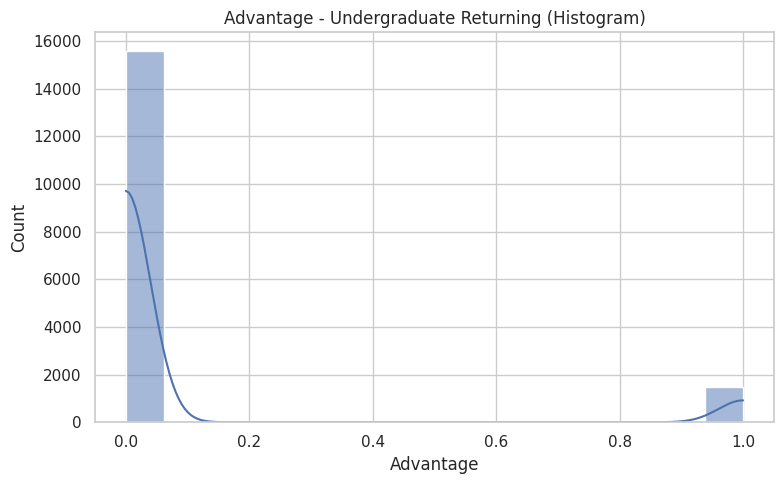

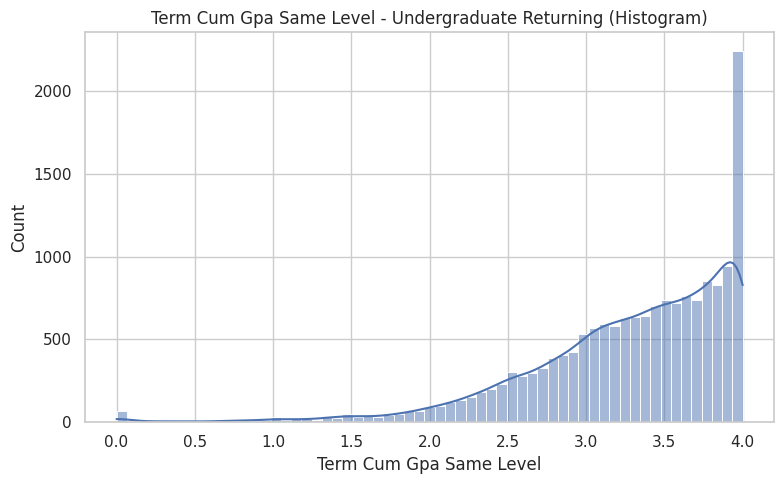

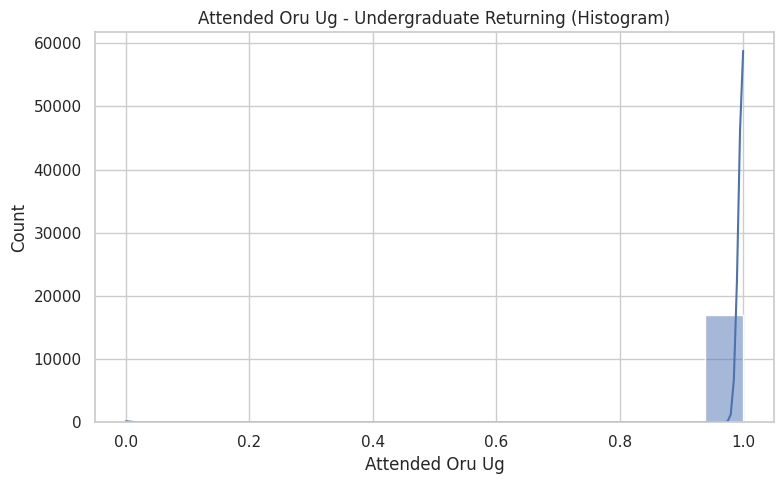

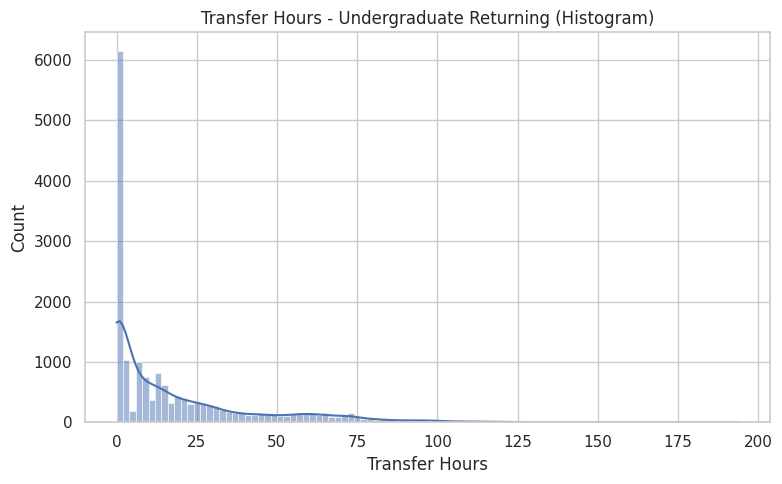

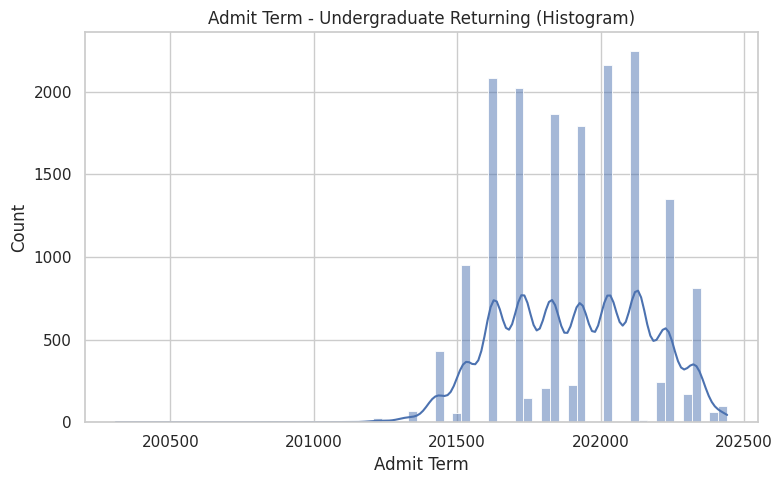

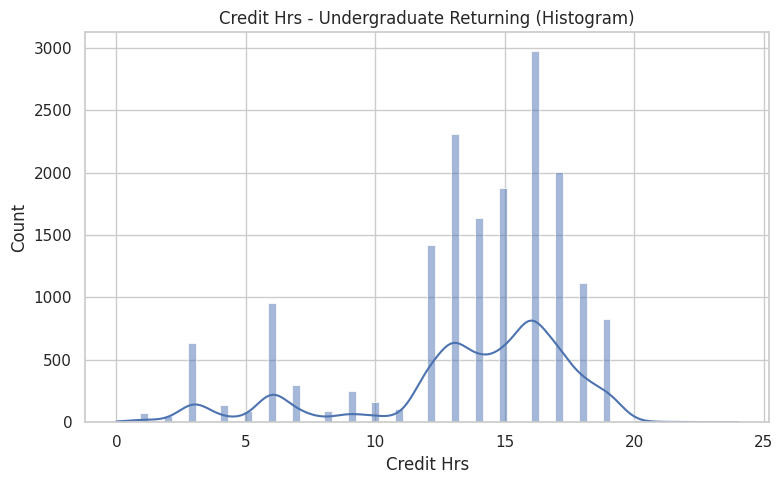

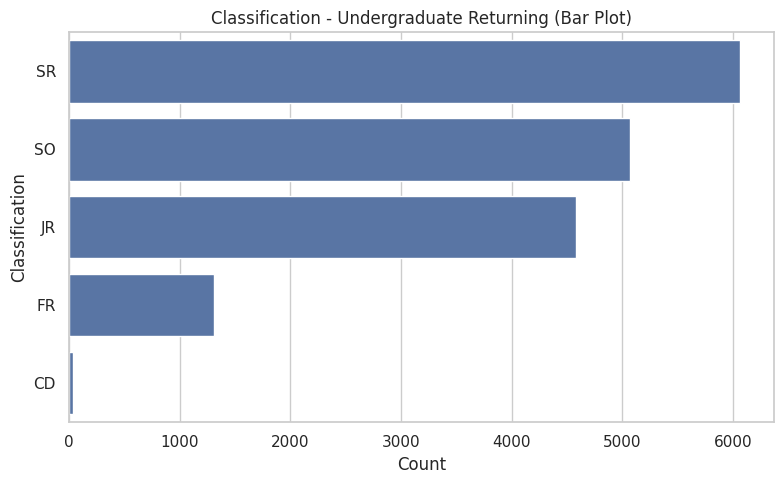

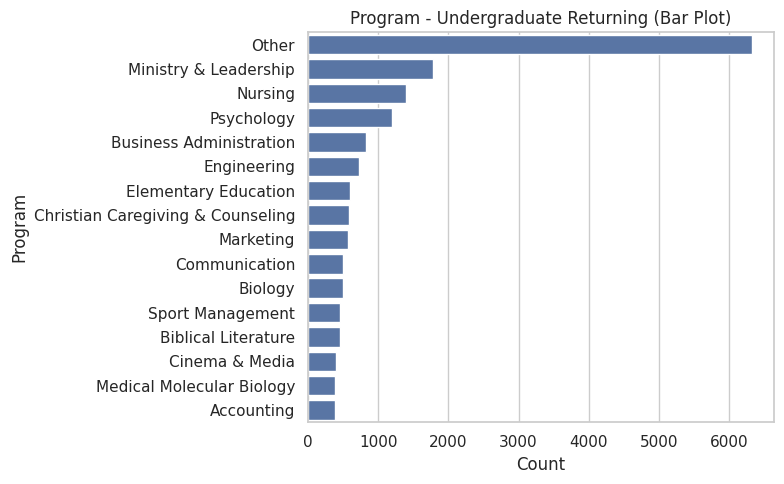

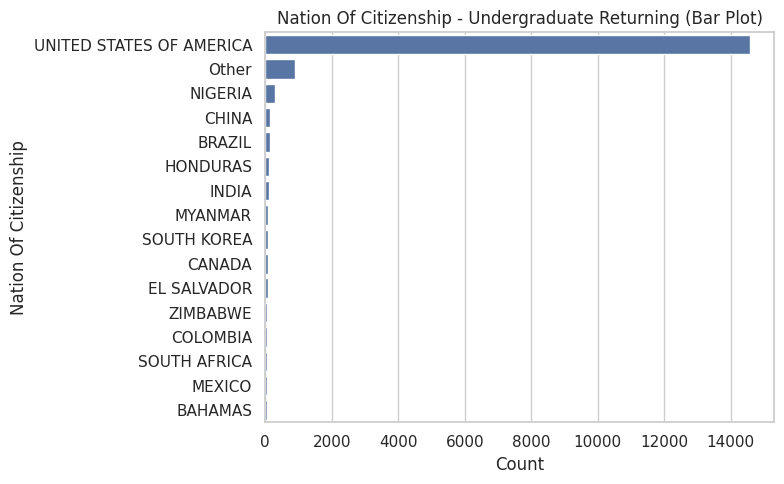

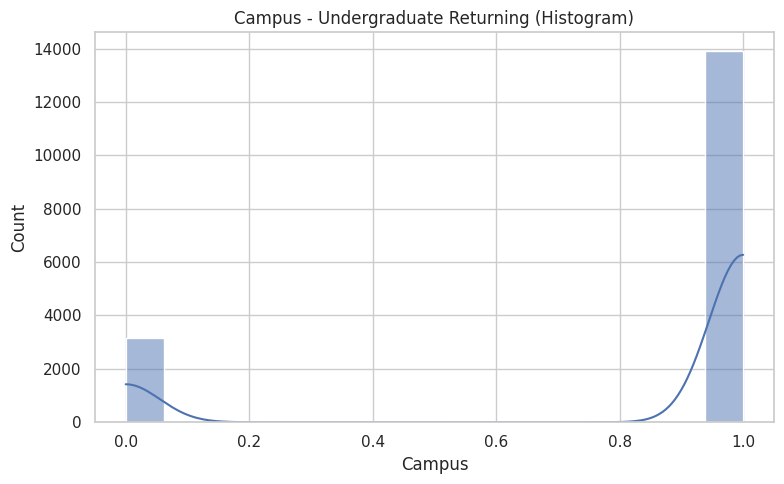

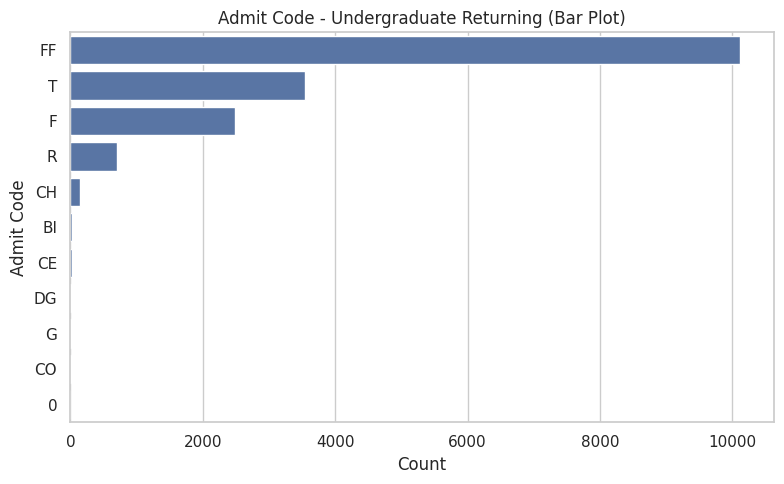

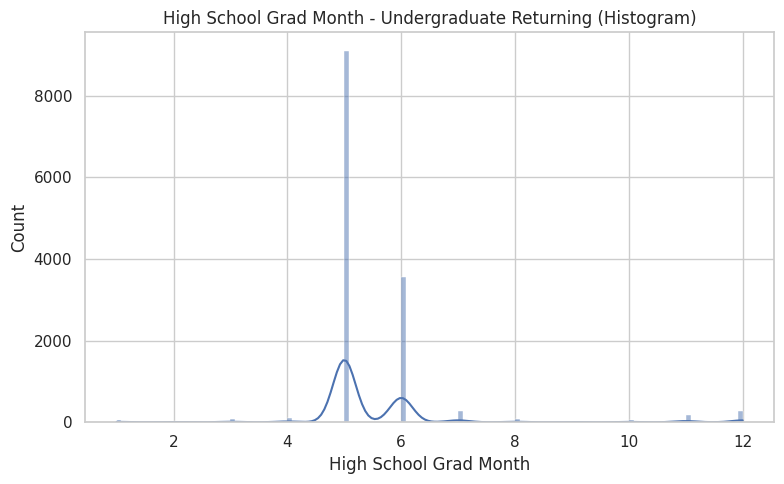

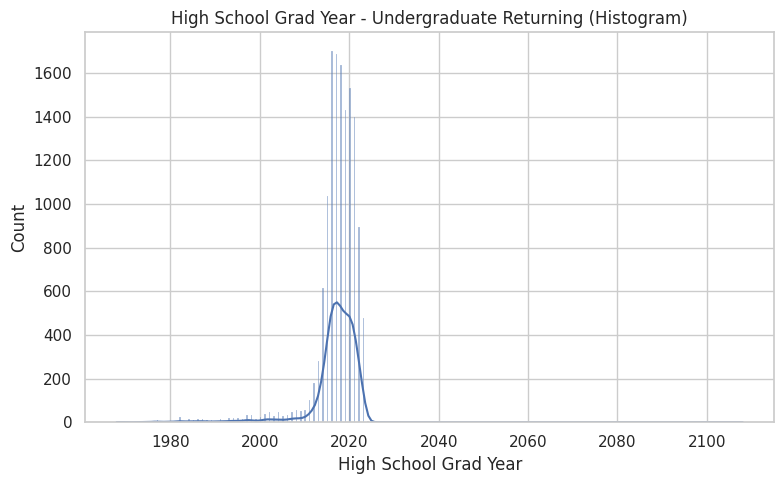

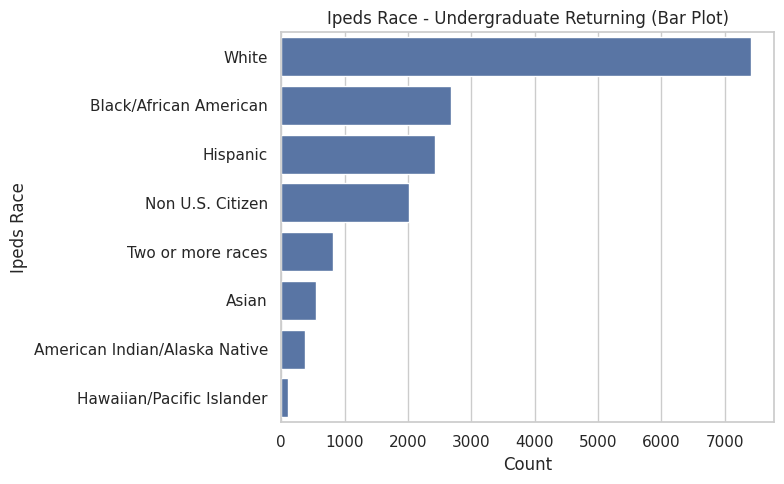

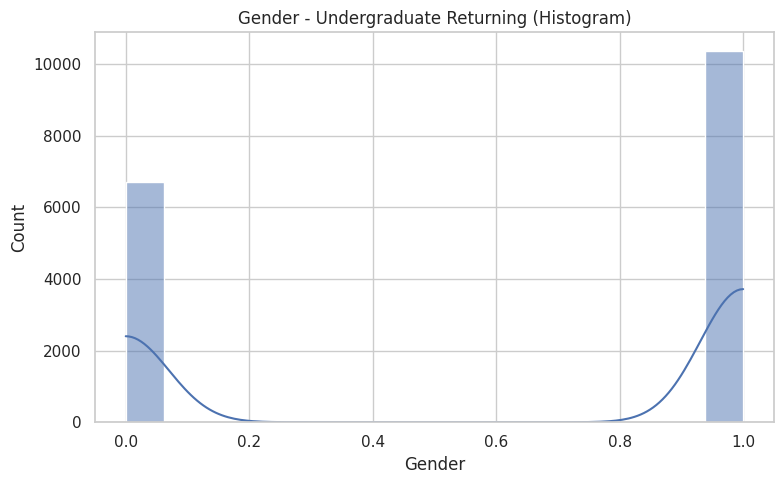

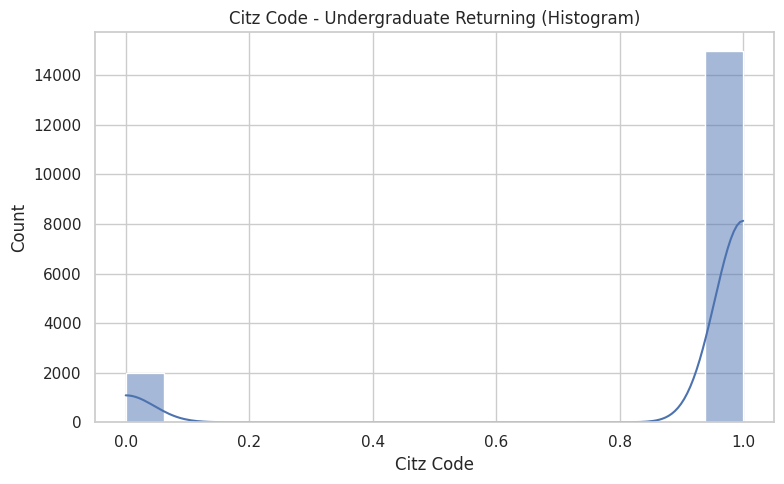

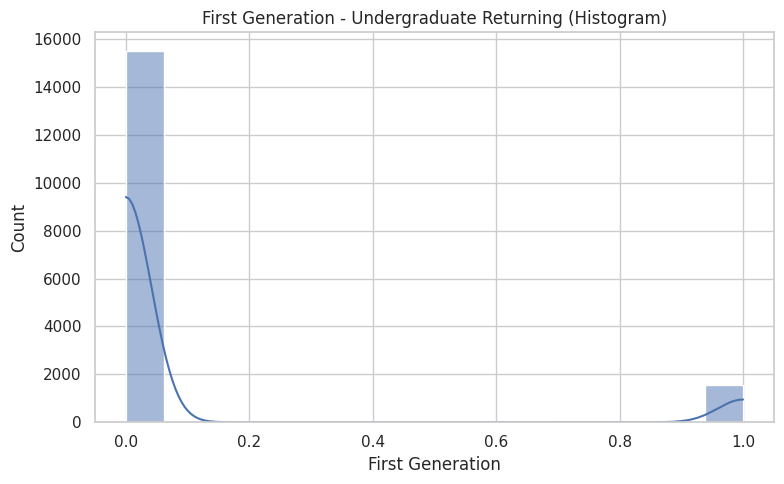

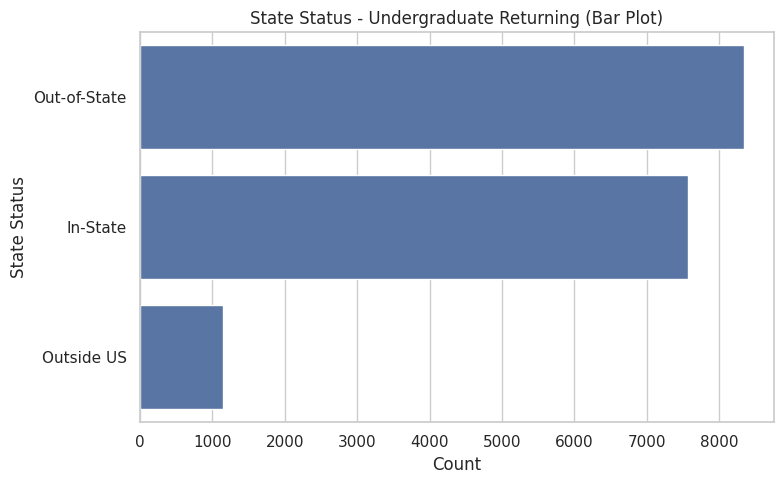

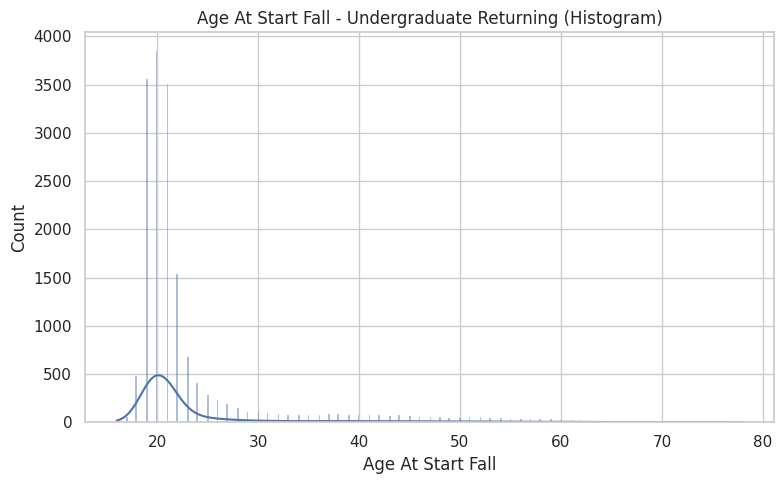

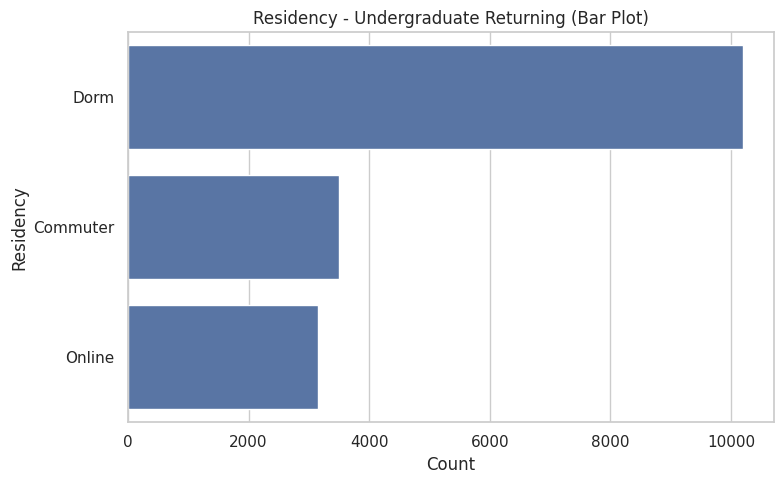

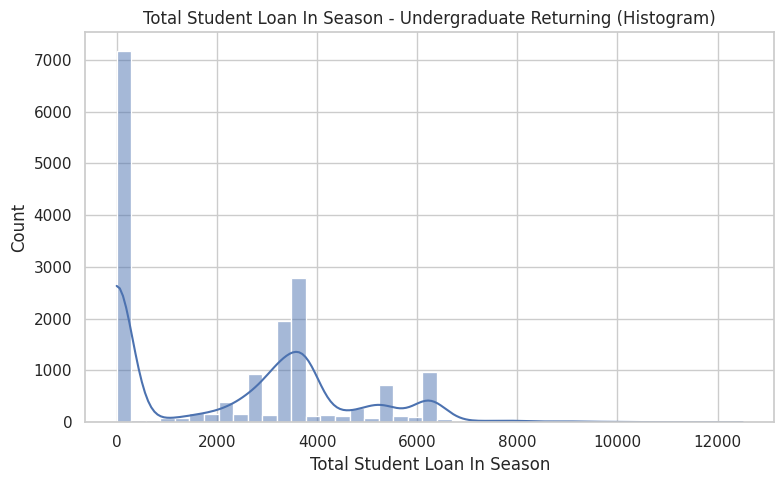

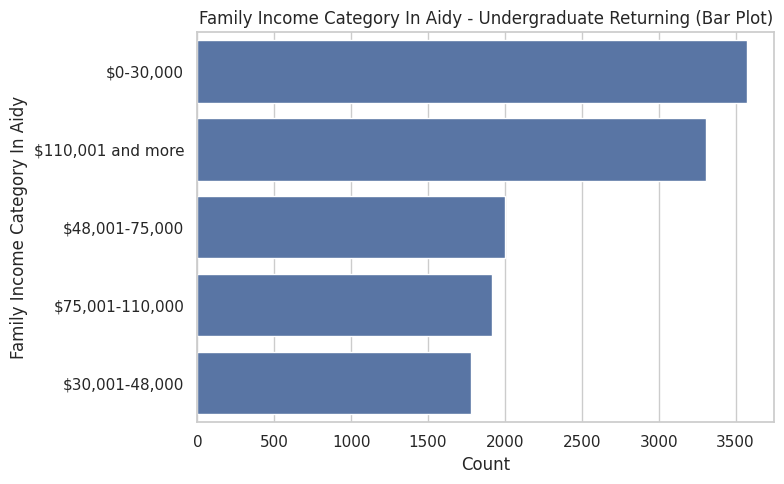

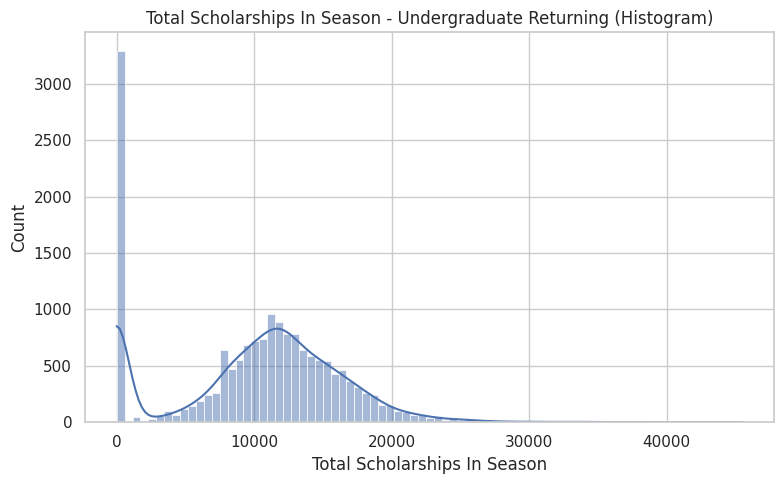

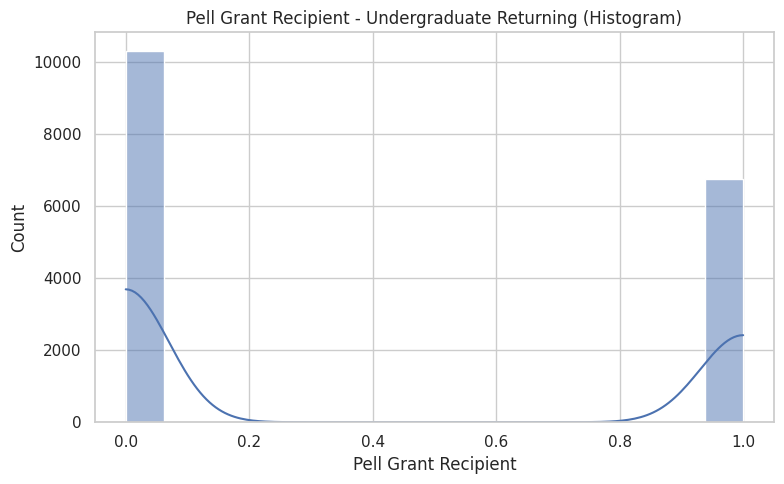

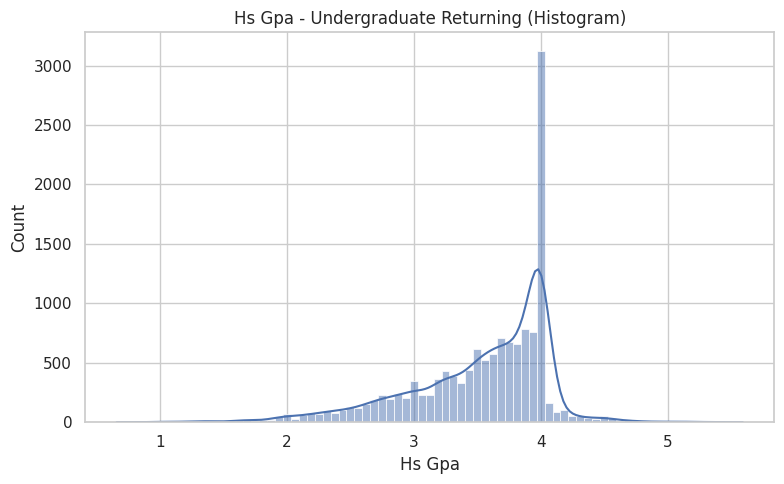

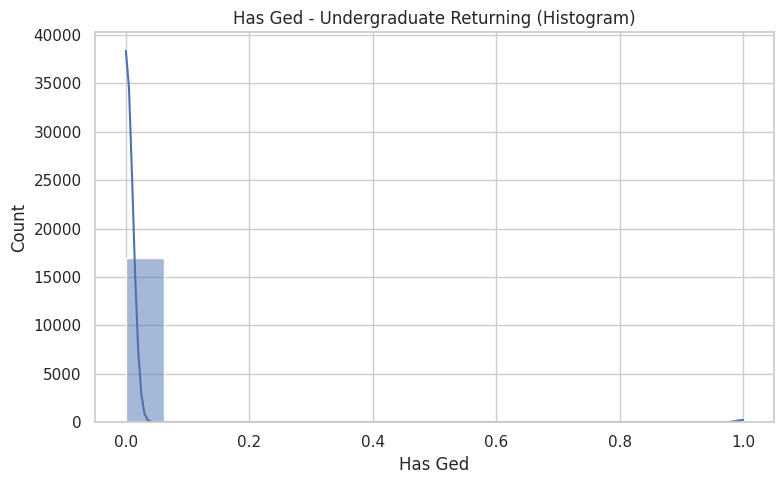

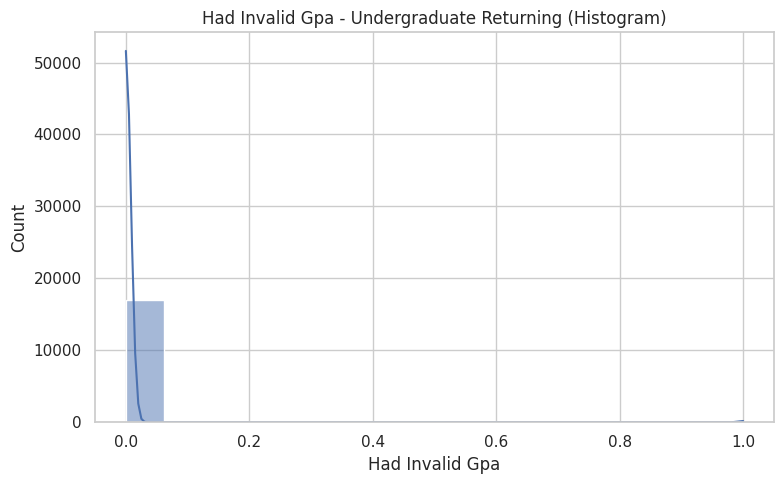

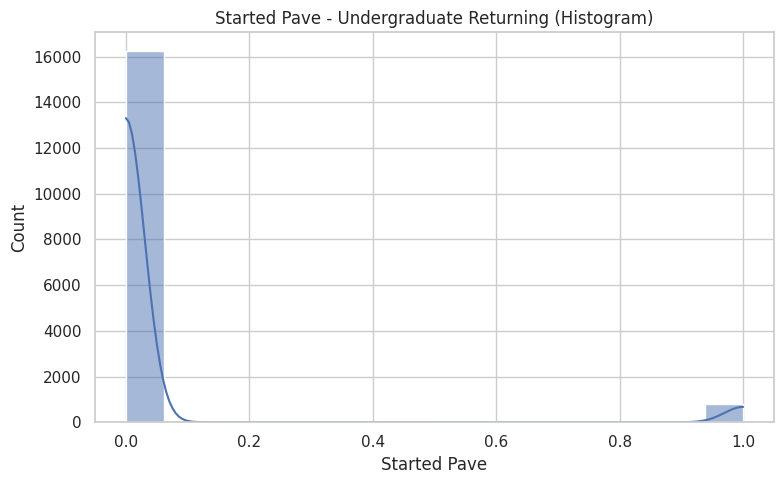

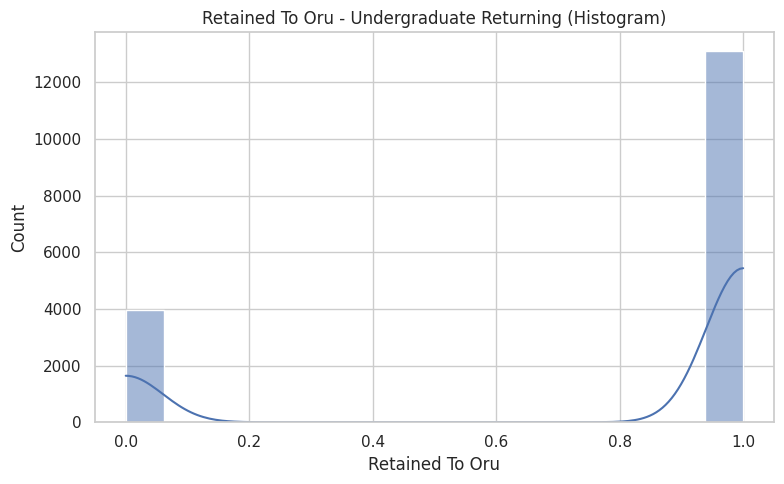

In [ ]:
# plot histograms for each feature
plot_individual_variable_distributions(groups)

###General Insights from Histograms
Target Variable Imbalance

* The retained_to_oru variable has a dominant majority class.

* Action: Oversampling or undersampling may be needed to avoid model bias.

Low Variance Columns

* started_pave: 1,236 positive values vs. 25,176 negative — little variance.

* invalid_gpa: 80 records

* has_ged: 147 records

* advantage_flag: 1,915 records

* These features may add noise and were considered for removal.

* Removed: has_ged, had_invalid_gpa

Credit Hour Velocity

* Bimodal distribution: peaks around 6 and 15 credit hours.

* Likely reflects a mix of graduate and undergraduate students.

Entering vs. Returning Students

* Fewer entering student records than returning ones.

* Action: Use cross-validation or bootstrapping for modeling entering students due to the smaller sample size.

Term Cumulative GPA (Same Level)

* Highly left-skewed distribution.

* Indicates students with lower GPAs are less likely to be retained.

### Insights from Faceted Histograms (by Level and Entry Status)
Graduate-Specific Variables

* started_pave and pell_grant are not applicable to graduate students.

* Action: Remove these columns before modeling to reduce noise.

Retention Rate Differences

* Returning undergraduate students show a much higher retention rate than entering students.

High School GPA Distribution

* Similar shape for entering and returning undergrads.

* ~26% of returning students have a GPA close to 4.0, compared to ~18% of entering students.

* Suggests students with higher HS GPAs may tend to stay (though this is not conclusive).

Pell Grant Observations

* More returning undergraduates did not receive Pell grants.

* Note: This doesn’t mean they never received one — it may reflect timing.

Scholarship Distributions

* Graduate students: Right-skewed — scholarships are less common.

* Undergraduate students: Roughly normal distribution, but with strong outliers near 0.

* May be better modeled as bimodal.

* Action: Consider a transformation before using in regression models sensitive to normality.

## Correlation Plots

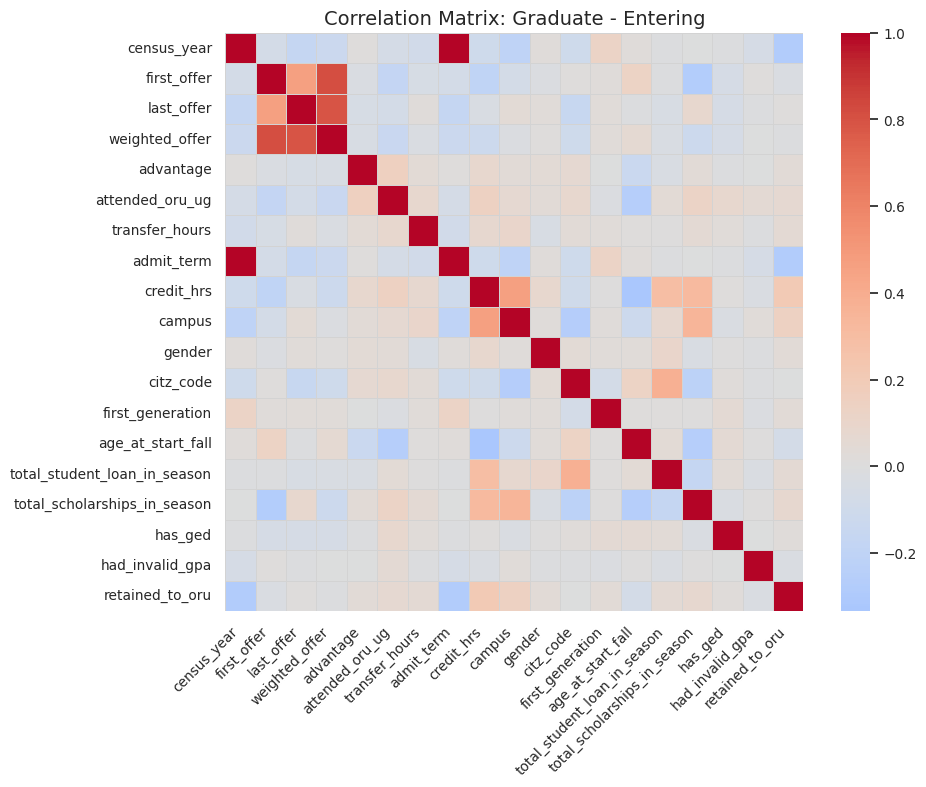

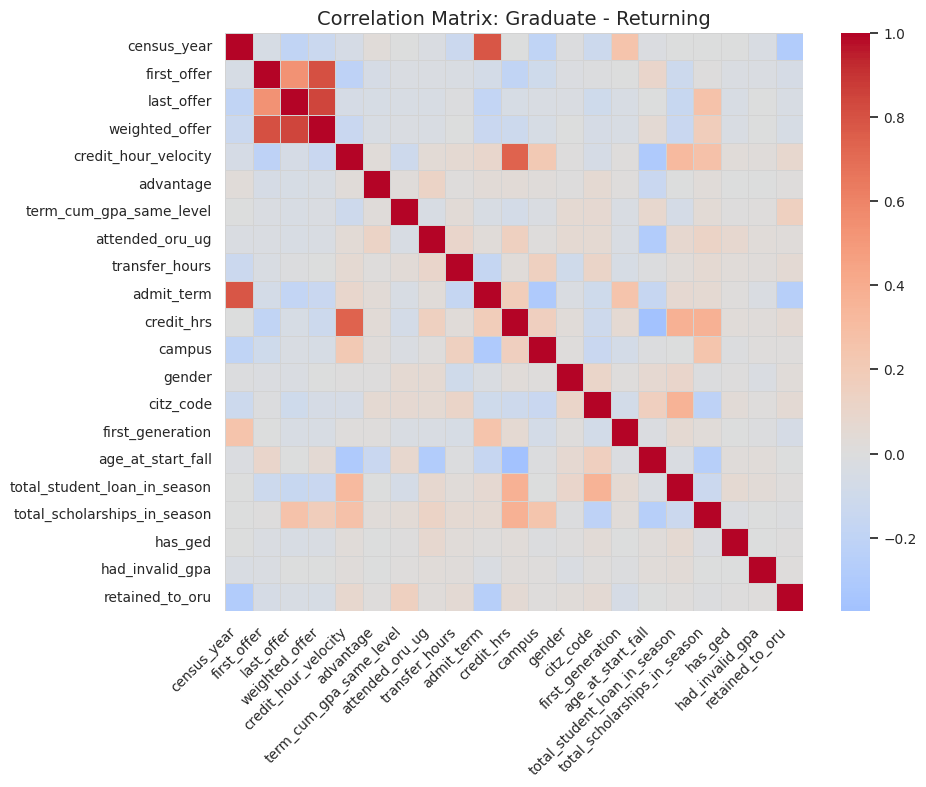

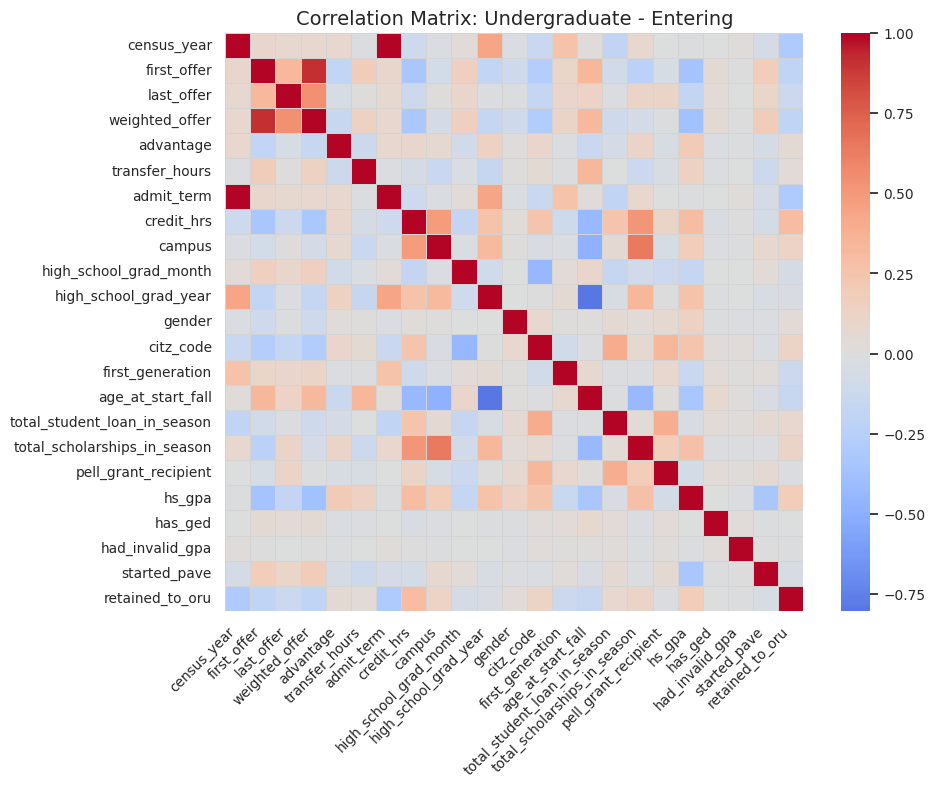

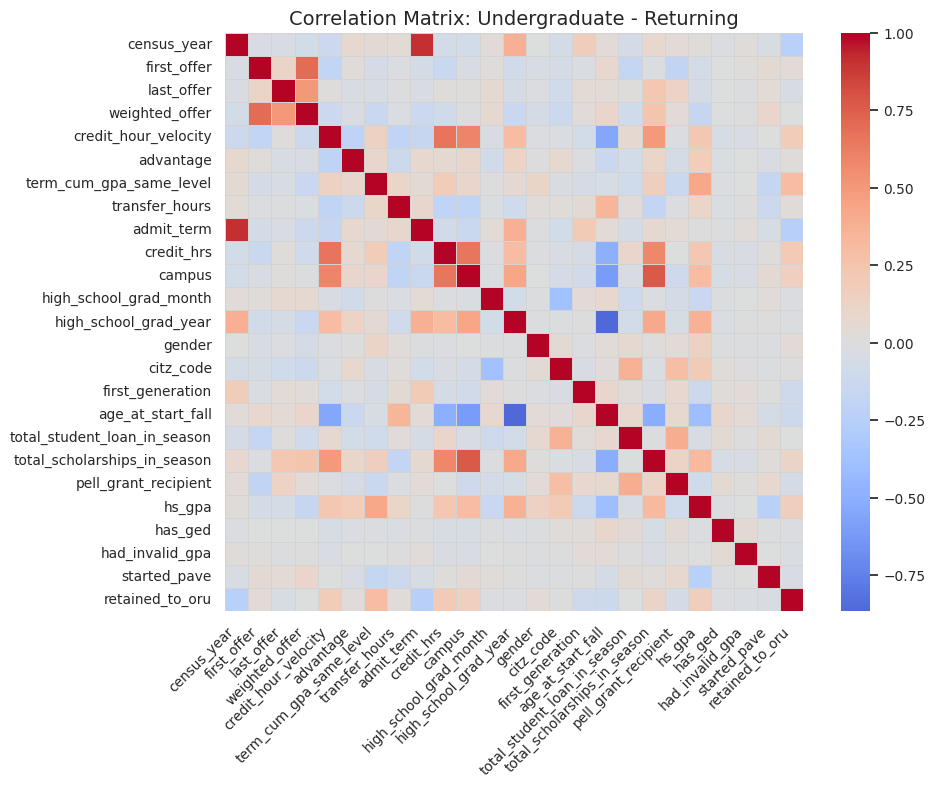

In [ ]:
# Correlation Plots
sns.set(style="white", font_scale=0.9)

for (levl, entering), df in groups.items():
    # Apply your filtering function first
    filtered_df = filter_relevant_columns(df, levl, entering)

    # Select numeric columns only
    numeric_df = filtered_df.select_dtypes(include=['number'])

    # Compute correlation matrix
    corr = numeric_df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=False, cmap="coolwarm", center=0, square=True,
                cbar=True, linewidths=0.5, linecolor='lightgray')
    plt.title(f"Correlation Matrix: {levl} - {entering}", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    filepath = os.path.join("/content/drive/MyDrive/", f"{levl}_{entering}_corrplot.png")
    plt.savefig(filepath)
    plt.show()

In [ ]:
# remove the columns that are not being kept for modeling
cols_to_drop = [
    'weighted_offer',
    'last_offer'
]

# Loop through each (levl, entering) group and drop them
for key, df in groups.items():
    groups[key] = df.drop(columns=cols_to_drop, errors='ignore').copy()

# add back in the scholarship offered feature
for key, df in groups.items():
    # Recreate scholarship_offered: 1 if offer exists, 0 if not
    df['scholarship_offered'] = df['first_offer'].notna().astype(int)
    groups[key] = df

Looking at the correlation plots across all four cohorts, first offer shows slight correlation with retention as compared to the other scholarship offer timing features. First offer is kept while others are dropped.

# Data Preparation

## Feature Engineering - Admit Term vs Admit Season

In [ ]:
# Because of the high correlation between admit term and census year in the model, I want to try
# to abstract the admit term to season and see if that has more predictive power


# First, create the new feature across the groups
# helper function to process the admit_terms in the dataset
def extract_admit_season(admit_term):
    # convert admit_term to string to safely extract character
    term_str = str(admit_term)
    # check for valid term entry
    if len(term_str) >= 5:
        # 5th digit in the term indicates season
        season_digit = term_str[4]
        return {"1": "Spring", "2": "Summer", "3": "Fall"}.get(season_digit, "Unknown")
    else:
        return "Unknown"


# apply to full dataset
for key, df in groups.items():
    df["admit_season"] = df["admit_term"].apply(extract_admit_season)

In [ ]:
# Testing out admit season predictive power versus admit term
# results list
results = []

# define features to compare
feature_sets = {"admit_term": ["admit_term"], "admit_season": ["admit_season"]}

# loop through each group
for (levl, entering), df_group in groups.items():
    # filter relevant columns
    df_group = filter_relevant_columns(df_group, levl, entering).copy()

    # set target variable
    y = df_group["retained_to_oru"]

    # for each feature
    for feature_name, cols in feature_sets.items():
        X = df_group[cols].copy()

        # build a pipeline, one-hot encoding for categorical input
        preprocessor = ColumnTransformer(
            transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), cols)],
            remainder="drop",
        )
        # make a model pipeline
        model = make_pipeline(
            preprocessor, RandomForestClassifier(n_estimators=100, random_state=42)
        )
        # create cv scoring
        scores = cross_validate(
            model,
            X,
            y,
            scoring={"roc_auc": "roc_auc", "f1": "f1", "accuracy": "accuracy"},
            cv=5,
            return_train_score=False,
        )
        # add the results
        results.append(
            {
                "levl": levl,
                "entering": entering,
                "feature": feature_name,
                "auc": np.mean(scores["test_roc_auc"]),
                "f1": np.mean(scores["test_f1"]),
                "accuracy": np.mean(scores["test_accuracy"]),
                "n": len(df_group),
            }
        )

In [ ]:
results_df = pd.DataFrame(results)

# Sort by F1, then AUC as tiebreaker
best_by_f1 = results_df.sort_values(by=['f1', 'auc'], ascending=False) \
    .groupby(['levl', 'entering']).first().reset_index()

print(best_by_f1[['levl', 'entering', 'feature', 'f1', 'auc', 'accuracy']])


            levl   entering     feature        f1       auc  accuracy
0       Graduate   Entering  admit_term  0.830354  0.710811  0.752603
1       Graduate  Returning  admit_term  0.883144  0.702112  0.806009
2  Undergraduate   Entering  admit_term  0.832282  0.716161  0.754893
3  Undergraduate  Returning  admit_term  0.884183  0.696585  0.803011


In [ ]:
# remove the admit season one-hot encoded values
for key, df in groups.items():
    groups[key] = df.drop(columns=cols_to_drop, errors='ignore').copy()

## Factor Reduction

In [ ]:
# loop through each dataset
for (level, entering), df in groups.items():
    # filter to relevant columns
    df = filter_relevant_columns(df, level, entering)
    # identify categorical columns
    cat_cols = df.select_dtypes(include=["object", "category"]).columns
    # apply the category reduction function
    df = reduce_categories(df, cat_cols, top_n=5, min_count=50)
    # update the group
    groups[(level, entering)] = df

## Eliminate Zero Variance Columns

In [ ]:
# loop through each dataset
for (level, entering), df in groups.items():
    # filter to relevant columns
    df = filter_relevant_columns(df, level, entering)
    # apply the drop constant columns function
    df, removed = drop_constant_columns(df)
    print(f"Removed constant columns: {removed}")
    # update the group
    groups[(level, entering)] = df

Removed constant columns: ['entering', 'levl', 'admit_season']
Removed constant columns: ['entering', 'levl']
Removed constant columns: ['entering', 'levl', 'admit_season']
Removed constant columns: ['entering', 'levl']


## Data Imputation

In [ ]:
# create a dict to hold the original data
original_groups = {}

# before implementing MICE, need to address the MNAR case
for key, df in groups.items():
    levl, entering = key
    # IPEDS race - replace any missing values with 'Unknown', which is a valid category
    if "ipeds_race" in df.columns:
        df["ipeds_race"] = df["ipeds_race"].fillna("Unknown")
    # family income category - replace missing values with a new category: 'Did not apply for need-based aid'
    if "family_income_category" in df.columns:
        df["family_income_category"] = df["family_income_category"].fillna(
            "Did not apply for aid"
        )

    # Filter out irrelevant columns
    df = filter_relevant_columns(df, levl, entering)

    # save a copy of the data before encoding & imputation
    original_groups[key] = df.copy()

    # separate data types
    cat_cols = df.select_dtypes(include=["object", "category"]).columns
    num_cols = df.select_dtypes(include=[np.number]).columns

    # encode categorical columns temporarily
    # create the encoder
    encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    # create a copy of the data for the encoding
    df_encoded = df.copy()
    # check if there are any categorical columns
    if len(cat_cols) > 0:
        # apply the integer encoder
        df_encoded[cat_cols] = encoder.fit_transform(df[cat_cols])

    # apply MICE via the IterativeImputer
    # create the imputer
    imputer = IterativeImputer(random_state=42)
    # apply the imputation to the dataset
    df_imputed = pd.DataFrame(
        imputer.fit_transform(df_encoded), columns=df_encoded.columns
    )

    # Decode the categorical variables
    if len(cat_cols) > 0:
        # loop through each categorical column
        for col in cat_cols:
            # make sure the type of the col is an integer
            df_imputed[col] = df_imputed[col].round().astype(int)

    # apply the reverse encoding to the dataset
    df_imputed[cat_cols] = encoder.inverse_transform(df_imputed[cat_cols])

    # update the group
    groups[key] = df_imputed

In [ ]:
# check to see that the imputation was successful:
# Print out columns with missing values and number and % of missing
print("Missing Values Summary (After Imputation):\n")
for key, sub in groups.items():
    level, entering = key
    # filter to only relevant columns
    sub = filter_relevant_columns(sub, level, entering)
    # printing out the keys for the group summary
    print(f"Group {key}:")
    # calculate the total rows per slice of data
    total_rows = len(sub)
    # count the number of missing values in the column
    missing_counts = sub.isnull().sum()
    # calculate the missing percentage for the column
    missing_pct = (missing_counts / total_rows * 100).round(1)
    # summarize the values in a data frame
    summary = pd.DataFrame({"Missing Count": missing_counts, "Missing %": missing_pct})
    # print the values
    print(summary)
    # print a separation line
    print("-" * 40)

Missing Values Summary (After Imputation):

Group ('Graduate', 'Entering'):
                              Missing Count  Missing %
census_year                               0        0.0
first_offer                               0        0.0
advantage                                 0        0.0
attended_oru_ug                           0        0.0
transfer_hours                            0        0.0
admit_term                                0        0.0
credit_hrs                                0        0.0
classification                            0        0.0
program                                   0        0.0
nation_of_citizenship                     0        0.0
campus                                    0        0.0
admit_code                                0        0.0
ipeds_race                                0        0.0
gender                                    0        0.0
citz_code                                 0        0.0
first_generation                          0 

## Further Preparation for Modeling

### Z-score Normalization, One-Hot Encoding, SMOTE, Training/Testing/Validation Split

This section not only performs the training, testing, and validation splits, but applies Z-score normalization to the numeric data, one-hot encoding to the categorical data, and Synthetic Minority Oversampling Technique (SMOTE) to the training data.

In [ ]:
# initialize a variable to hold results
processed_datasets = {}

# loop through each dataset
for (level, entering), df in groups.items():
    # filter to relevant columns
    df = filter_relevant_columns(df, level, entering)

    # separate out the test data set
    test_df = df[df["census_year"] == 2024]
    train_val_df = df[df["census_year"] < 2024]

    # separate the target variable from the data
    x = train_val_df.drop(columns=["retained_to_oru"])
    y = train_val_df["retained_to_oru"]
    x_test = test_df.drop(columns=["retained_to_oru"])
    y_test = test_df["retained_to_oru"]

    # identify categorical and numeric columns
    cat_cols = x.select_dtypes(include=["object", "category"]).columns
    num_cols = x.select_dtypes(include=[np.number]).columns

    # apply one hot encoding
    x = pd.get_dummies(x, columns=cat_cols, drop_first=True)
    x_test = pd.get_dummies(x_test, columns=cat_cols, drop_first=True)

    # align the columns of the train/test
    x, x_test = x.align(x_test, join="left", axis=1, fill_value=0)

    # apply Z-score normalization to numeric columns
    scaler = StandardScaler()
    x[num_cols] = scaler.fit_transform(x[num_cols])
    x_test[num_cols] = scaler.fit_transform(x_test[num_cols])

    # split the training set further into training and validation
    x_train, x_val, y_train, y_val = train_test_split(
        x, y, test_size=0.3, stratify=y, random_state=42
    )

    # Apply SMOTE to training data only
    smote = SMOTE(random_state=42, k_neighbors=3)
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

    # Check class distribution before and after SMOTE
    print(f"Before SMOTE for ({level}, {entering}): {Counter(y_train)}")
    print(f"After SMOTE for ({level}, {entering}): {Counter(y_train_resampled)}")

    """
  # Undersampling the majority class in the training data
  undersampler = RandomUnderSampler(random_state=42)
  x_train_resampled, y_train_resampled = undersampler.fit_resample(x_train, y_train)

  # Check class distribution before and after undersampling
  print(f"Before undersampling for ({level}, {entering}): {Counter(y_train)}")
  print(f"After undersampling for ({level}, {entering}): {Counter(y_train_resampled)}")
  """

    # Store everything for modeling
    processed_datasets[(level, entering)] = {
        "x_train": x_train_resampled,
        "y_train": y_train_resampled,
        "x_val": x_val,
        "y_val": y_val,
        "x_test": x_test,
        "y_test": y_test,
    }

Before SMOTE for (Graduate, Entering): Counter({1.0: 774, 0.0: 283})
After SMOTE for (Graduate, Entering): Counter({1.0: 774, 0.0: 774})
Before SMOTE for (Graduate, Returning): Counter({1.0: 1733, 0.0: 293})
After SMOTE for (Graduate, Returning): Counter({1.0: 1733, 0.0: 1733})
Before SMOTE for (Undergraduate, Entering): Counter({1.0: 3657, 0.0: 1364})
After SMOTE for (Undergraduate, Entering): Counter({1.0: 3657, 0.0: 3657})
Before SMOTE for (Undergraduate, Returning): Counter({1.0: 8662, 0.0: 1721})
After SMOTE for (Undergraduate, Returning): Counter({1.0: 8662, 0.0: 8662})


### Selecting Top K Features per Dataset

In [ ]:
def select_top_k_features(datasets, k=10):
    # initialize to store the new datasets
    selected_datasets = {}

    # loop through each dataset
    for group_key, data in datasets.items():
        # get the training data
        x_train = data["x_train"]
        y_train = data["y_train"]

        # make a copy of the training data
        df = x_train.copy()
        # add the labels to df
        df["target"] = y_train

        # detect binary columns
        binary_cols = [
            col for col in df.columns if df[col].nunique() == 2 and col != "target"
        ]
        # identify numeric columns
        numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
        # remove binary columns from numeric list
        numeric_cols = [
            col for col in numeric_cols if col not in binary_cols and col != "target"
        ]
        # identify categorical columns
        categorical_cols = df.select_dtypes(
            include=["object", "category", "bool"]
        ).columns.tolist()
        # remove target from the categorical columns list
        categorical_cols = [col for col in categorical_cols if col != "target"]
        # add binary cols to categorical treatment
        categorical_cols += binary_cols

        # set a list to hold the scores
        effect_size_scores = []

        # For numeric features: use effect size to determine the most important features
        for col in numeric_cols:
            try:
                # separate out group 0 for the target variable
                group0 = df[df["target"] == 0][col].dropna()
                # separate out group 1 for the target variable
                group1 = df[df["target"] == 1][col].dropna()
                # calculate the effect size
                effect_size = abs(group0.mean() - group1.mean()) / (
                    df[col].std() + 1e-6
                )
                # store the effect size for the column
                effect_size_scores.append((col, effect_size))
            except:
                # set to 0
                effect_size_scores.append((col, 0))
        # normalize the effect size scores
        scores = [score for _, score in effect_size_scores]
        # calculate the min max for min-max normalization
        es_min, es_max = min(scores), max(scores)
        # make all the scores normalized
        effect_size_scores_norm = [
            (col, (score - es_min) / (es_max - es_min + 1e-9))
            for col, score in effect_size_scores
        ]

        # for categorical columns, use mutual information to determine most important
        mi_scores = []
        for col in categorical_cols:
            try:
                encoded = LabelEncoder().fit_transform(df[col].astype(str))
                mi = mutual_info_classif(
                    encoded.reshape(-1, 1), y_train, discrete_features=True
                )[0]
                mi_scores.append((col, mi))
            except:
                mi_scores.append((col, 0))

        # normalize the mutual information scores
        scores = [score for _, score in mi_scores]
        # calculate the min max for min-max normalization
        mi_min, mi_max = min(scores), max(scores)
        # make all the scores normalized
        mi_scores_norm = [
            (col, (score - mi_min) / (mi_max - mi_min + 1e-9))
            for col, score in mi_scores
        ]

        # Combine and deduplicate scores by keeping the max score per feature
        combined_dict = {}

        for col, score in effect_size_scores_norm + mi_scores_norm:
            if col not in combined_dict:
                combined_dict[col] = score
            else:
                combined_dict[col] = max(combined_dict[col], score)

        # Now sort and select top k unique features
        combined_sorted = sorted(combined_dict.items(), key=lambda x: x[1], reverse=True)[:k]
        top_features = [col for col, score in combined_sorted]

        # Subset datasets with top features
        selected_datasets[group_key] = {
            "x_train": x_train[top_features],
            "x_val": data["x_val"][top_features],
            "x_test": data["x_test"][top_features],
            "y_train": y_train,
            "y_val": data["y_val"],
            "y_test": data["y_test"],
        }

    return selected_datasets


top_k_datasets = select_top_k_features(processed_datasets, k=10)

In [ ]:
# Print out the top features in each dataset
for group_key, dataset in top_k_datasets.items():
    selected_features = dataset['x_train'].columns.tolist()
    print(f"\nSelected features for group {group_key}:")
    for i, feat in enumerate(selected_features, 1):
        print(f"{i}. {feat}")


Selected features for group ('Graduate', 'Entering'):
1. credit_hrs
2. admit_code_X
3. state_status_Out-of-State
4. residency_Online
5. ipeds_race_Black/African American
6. program_Other
7. ipeds_race_Other
8. program_Master of Christian Ministry
9. scholarship_offered
10. first_offer

Selected features for group ('Graduate', 'Returning'):
1. term_cum_gpa_same_level
2. admit_season_Spring
3. credit_hrs
4. credit_hour_velocity
5. state_status_Out-of-State
6. ipeds_race_Black/African American
7. first_offer
8. program_Other
9. admit_code_X
10. classification_PR

Selected features for group ('Undergraduate', 'Entering'):
1. credit_hrs
2. residency_Dorm
3. first_offer
4. hs_gpa
5. total_scholarships_in_season
6. residency_Other
7. age_at_start_fall
8. high_school_grad_year
9. scholarship_offered
10. campus

Selected features for group ('Undergraduate', 'Returning'):
1. term_cum_gpa_same_level
2. residency_Online
3. admit_season_Spring
4. credit_hrs
5. hs_gpa
6. state_status_Out-of-State
7

# Modeling

### Random Forest

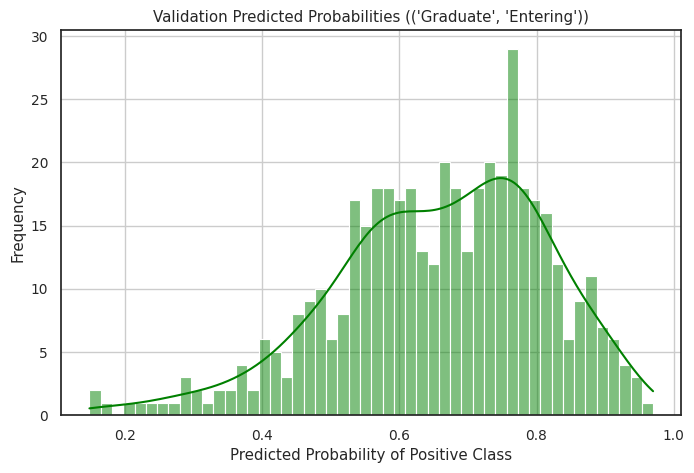

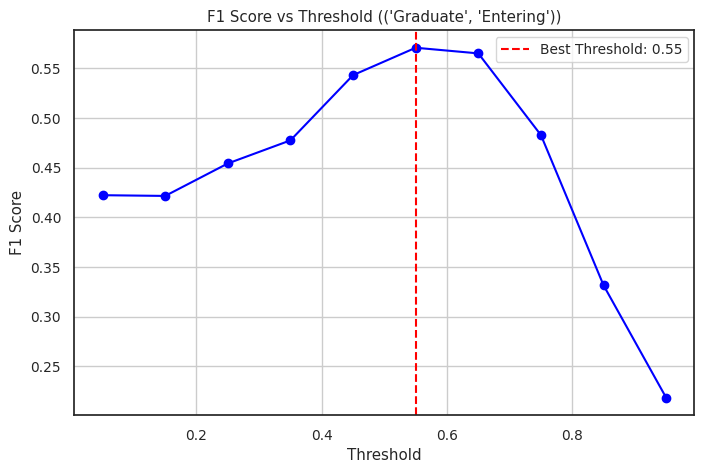

Classification Report (Best Threshold):
              precision    recall  f1-score   support

         0.0       0.38      0.34      0.36       122
         1.0       0.77      0.80      0.78       332

    accuracy                           0.68       454
   macro avg       0.57      0.57      0.57       454
weighted avg       0.66      0.68      0.67       454

Confusion Matrix (('Graduate', 'Entering')):
[[ 41  81]
 [ 66 266]]


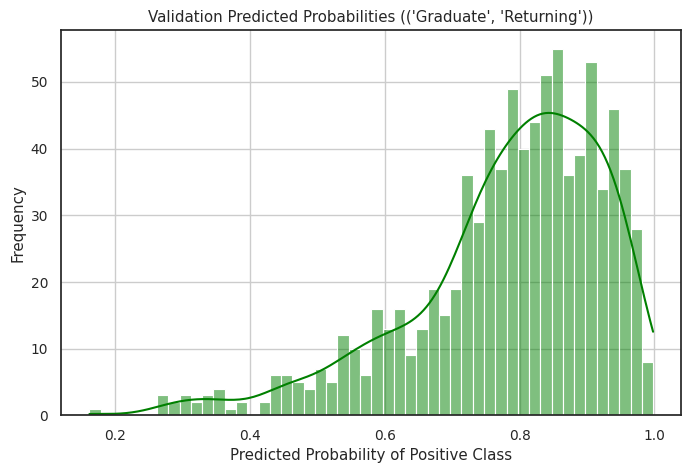

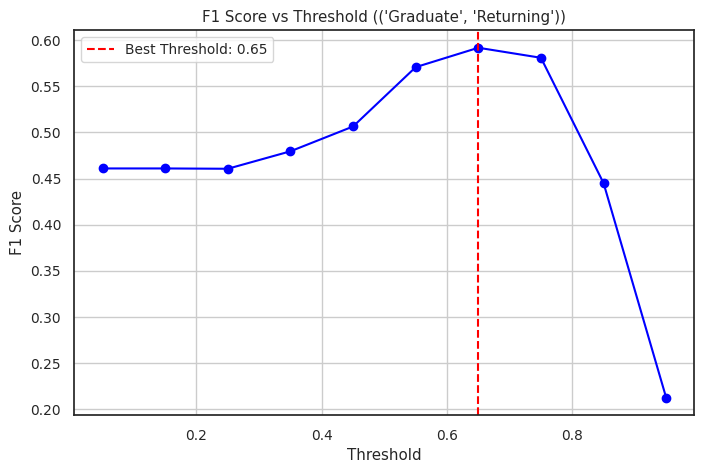

Classification Report (Best Threshold):
              precision    recall  f1-score   support

         0.0       0.29      0.33      0.31       126
         1.0       0.88      0.87      0.88       743

    accuracy                           0.79       869
   macro avg       0.59      0.60      0.59       869
weighted avg       0.80      0.79      0.79       869

Confusion Matrix (('Graduate', 'Returning')):
[[ 41  85]
 [ 99 644]]


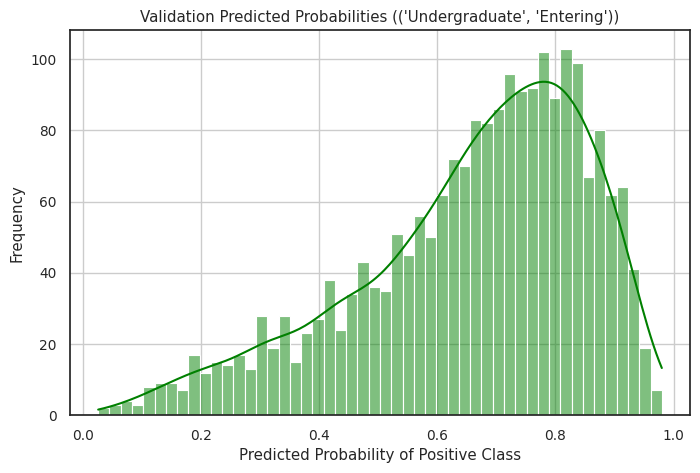

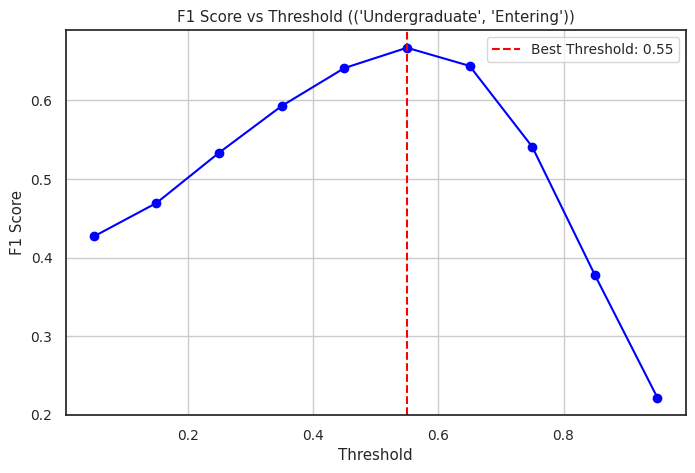

Classification Report (Best Threshold):
              precision    recall  f1-score   support

         0.0       0.52      0.50      0.51       584
         1.0       0.82      0.83      0.82      1568

    accuracy                           0.74      2152
   macro avg       0.67      0.66      0.67      2152
weighted avg       0.74      0.74      0.74      2152

Confusion Matrix (('Undergraduate', 'Entering')):
[[ 290  294]
 [ 263 1305]]


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


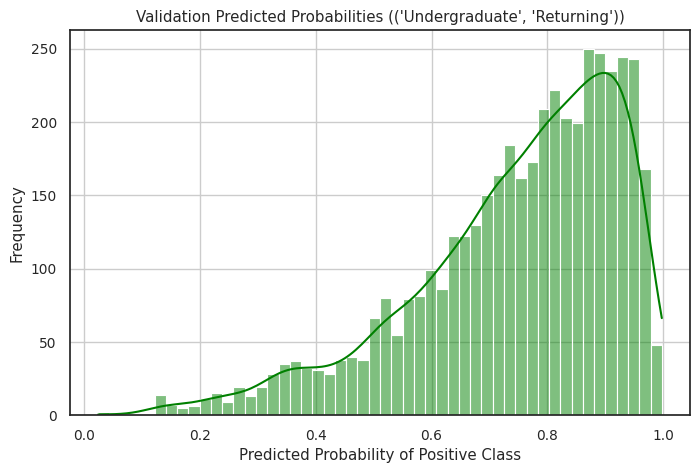

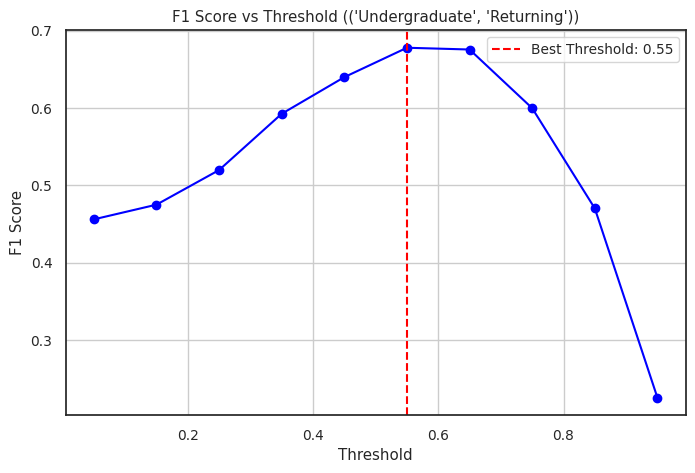

Classification Report (Best Threshold):
              precision    recall  f1-score   support

         0.0       0.49      0.43      0.46       738
         1.0       0.89      0.91      0.90      3712

    accuracy                           0.83      4450
   macro avg       0.69      0.67      0.68      4450
weighted avg       0.82      0.83      0.83      4450

Confusion Matrix (('Undergraduate', 'Returning')):
[[ 314  424]
 [ 327 3385]]


['/content/drive/MyDrive/rf_results.pkl']

In [ ]:
# define grid for hyperparameter tuning
param_dist = {
    # number of trees 100 - 300
    "n_estimators": [500],
    # maxixmum depth of each tree
    "max_depth": [None, 10, 20],
    # minimum number of rows of data that must be present for a split in the tree
    "min_samples_split": [2, 5],
    # minimum number of rows of data in a single leaf of the decision tree
    "min_samples_leaf": [1, 2],
    # maximum number of features to consider at each split
    "max_features": ["sqrt"],
}

# set up stratified k fold so that each fold has both classes
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# to store results of models
rf_results = {}

# loop through each dataset
for group_key, data in processed_datasets.items():
    x_train, y_train = data["x_train"], data["y_train"]
    x_val, y_val = data["x_val"], data["y_val"]
    x_test, y_test = data["x_test"], data["y_test"]

    # set up the model that we will hypertune
    base_model = RandomForestClassifier(
        random_state=42,
        # this argument adjusts the weights assigned to each class in the
        # target variable so that it's inversely proportional to the number
        # of samples
        # formula: n_samples / (n_classes * np.bincount(y))
        # penalizes mistakes in the minority classes more heavily
        class_weight="balanced",
        # use all available CPU cores
        n_jobs=-1,
    )

    # set up the randomized grid search for the model
    grid_search = RandomizedSearchCV(
        # pass the base model
        base_model,
        # pass the parameter grid
        param_distributions=param_dist,
        # set the number of model to train
        n_iter=10,
        # set crossfolds for hyperparameter tuning
        cv=cv,
        # set f1 as the tuning metric
        scoring="f1_macro",
        # set how much output the model will print during fitting
        verbose=0,
        # parallelize the model training
        n_jobs=-1,
        random_state=42,
    )

    # fit the grid search
    grid_search.fit(x_train, y_train)

    # extract the best model
    best_model = grid_search.best_estimator_

    # generate probabilities of class 1 on the validation set
    val_probs = best_model.predict_proba(x_val)[:, 1]

    # Visualize predicted probabilities
    plt.figure(figsize=(8, 5))
    sns.histplot(val_probs, bins=50, kde=True, color="green")
    plt.title(f"Validation Predicted Probabilities ({group_key})")
    plt.xlabel("Predicted Probability of Positive Class")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # define probability thresholds to test
    thresholds = np.arange(0.05, 1.01, 0.1)

    # calculate the f1 score for each threshold
    f1_scores = [f1_score(y_val, val_probs >= t, average="macro") for t in thresholds]

    # find the best threshold that produces the maximum f1 score
    # get the index of the best threshold
    best_idx = np.argmax(f1_scores)
    # get the value of the best threshold
    best_threshold = thresholds[best_idx]
    # get the best f1 score for the model based on the best threshold
    best_f1 = f1_scores[best_idx]

    # plot the F1 score versus the probability thresholds
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1_scores, marker="o", color="blue")
    plt.axvline(
        x=best_threshold,
        color="red",
        linestyle="--",
        label=f"Best Threshold: {best_threshold:.2f}",
    )
    plt.title(f"F1 Score vs Threshold ({group_key})")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)
    filepath = os.path.join("/content/drive/MyDrive/", f"{group_key}_RF_F1.png")
    plt.savefig(filepath)
    plt.show()

    # Convert probabilities to binary using best threshold
    val_preds_thresh = (val_probs >= best_threshold).astype(int)

    # Compute individual metrics
    f1_macro = f1_score(y_val, val_preds_thresh, average='macro')
    f1_class_0 = f1_score(y_val, val_preds_thresh, pos_label=0)
    f1_class_1 = f1_score(y_val, val_preds_thresh, pos_label=1)
    recall = recall_score(y_val, val_preds_thresh)
    accuracy = accuracy_score(y_val, val_preds_thresh)

    # Compute PR AUC
    prec, rec, _ = precision_recall_curve(y_val, val_probs)
    pr_auc = auc(rec, prec)

    # Evaluate
    print("Classification Report (Best Threshold):")
    print(classification_report(y_val, val_preds_thresh))

    # Confusion Matrix
    cm = confusion_matrix(y_val, val_preds_thresh)
    print(f"Confusion Matrix ({group_key}):")
    print(cm)

    # store the results of the model
    rf_results[group_key] = {
      'best_model': best_model,
      'best_threshold': best_threshold,
      'best_f1': best_f1,
      'f1_class_0': f1_class_0,
      'f1_class_1': f1_class_1,
      'recall': recall,
      'accuracy': accuracy,
      'pr_auc': pr_auc,
      'grid_search': grid_search.best_params_,
      'x_test': x_test,
      'y_test': y_test
  }
# save all models and metadata
joblib.dump(rf_results, "/content/drive/MyDrive/rf_results.pkl")

### Random Forest with Feature Selection

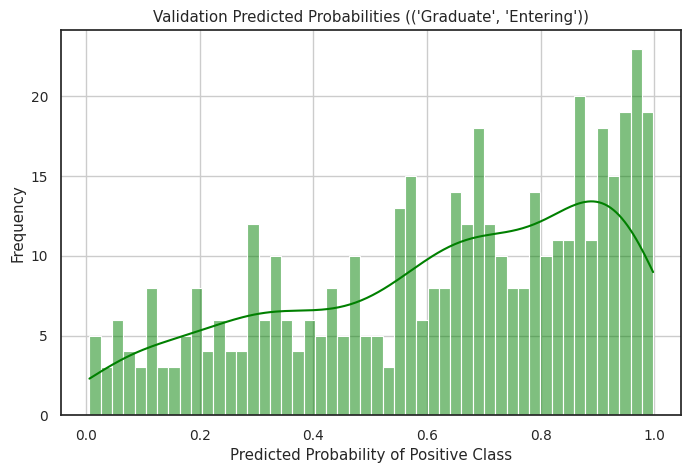

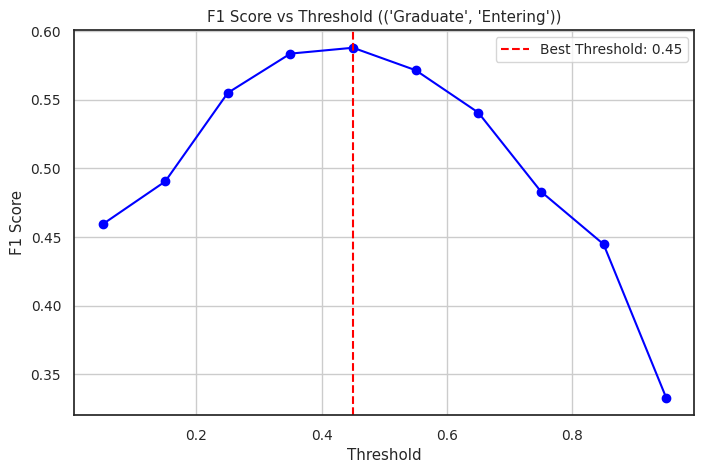

Classification Report (Best Threshold):
              precision    recall  f1-score   support

         0.0       0.39      0.41      0.40       122
         1.0       0.78      0.77      0.77       332

    accuracy                           0.67       454
   macro avg       0.59      0.59      0.59       454
weighted avg       0.68      0.67      0.67       454

Confusion Matrix (('Graduate', 'Entering')):
[[ 50  72]
 [ 77 255]]


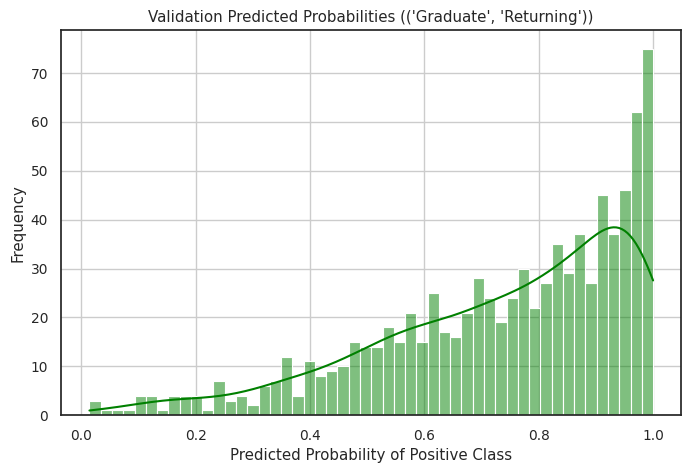

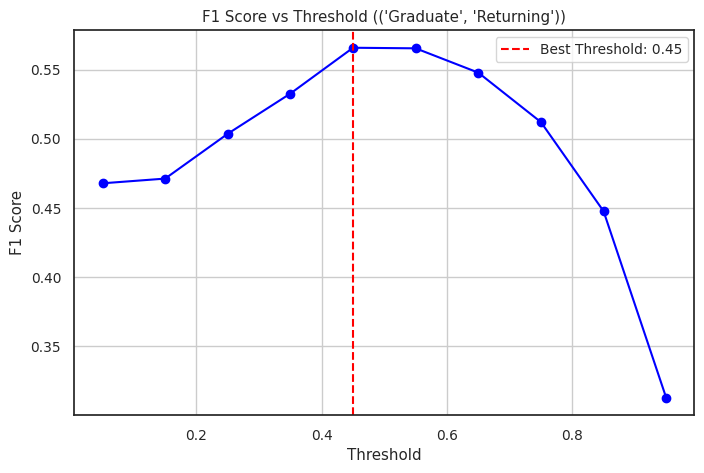

Classification Report (Best Threshold):
              precision    recall  f1-score   support

         0.0       0.27      0.22      0.25       126
         1.0       0.87      0.90      0.89       743

    accuracy                           0.80       869
   macro avg       0.57      0.56      0.57       869
weighted avg       0.79      0.80      0.79       869

Confusion Matrix (('Graduate', 'Returning')):
[[ 28  98]
 [ 74 669]]


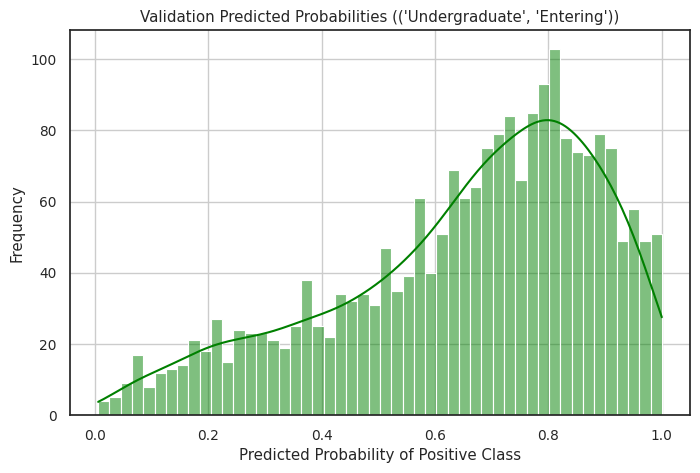

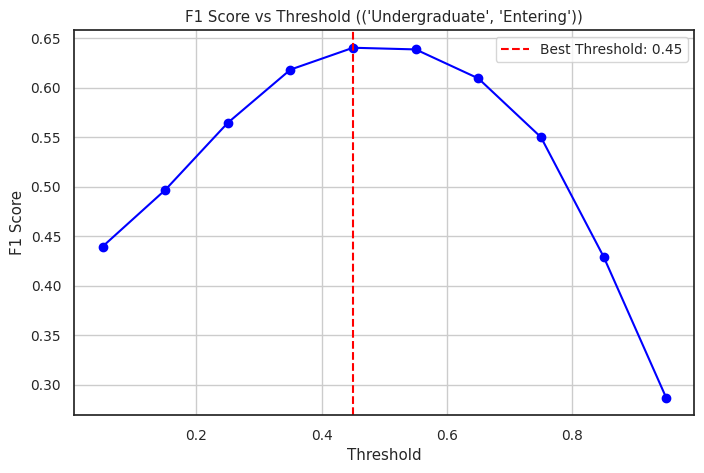

Classification Report (Best Threshold):
              precision    recall  f1-score   support

         0.0       0.53      0.39      0.45       584
         1.0       0.79      0.87      0.83      1568

    accuracy                           0.74      2152
   macro avg       0.66      0.63      0.64      2152
weighted avg       0.72      0.74      0.73      2152

Confusion Matrix (('Undergraduate', 'Entering')):
[[ 228  356]
 [ 201 1367]]


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


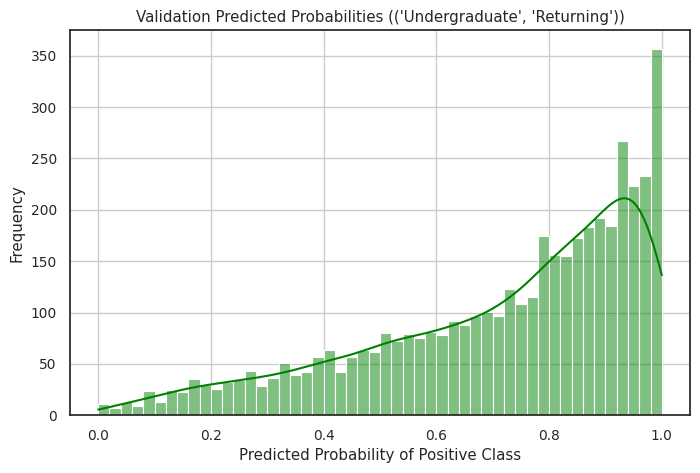

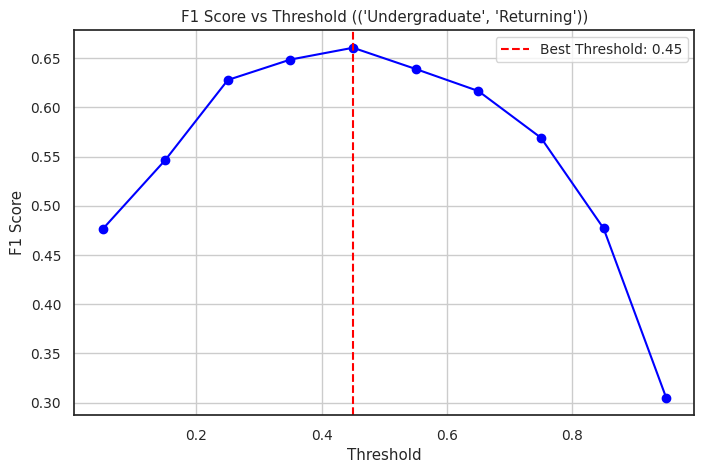

Classification Report (Best Threshold):
              precision    recall  f1-score   support

         0.0       0.44      0.43      0.43       738
         1.0       0.89      0.89      0.89      3712

    accuracy                           0.81      4450
   macro avg       0.66      0.66      0.66      4450
weighted avg       0.81      0.81      0.81      4450

Confusion Matrix (('Undergraduate', 'Returning')):
[[ 315  423]
 [ 405 3307]]


['/content/drive/MyDrive/rf_results_top_features.pkl']

In [ ]:
# define grid for hyperparameter tuning
param_dist = {
    # number of trees 100 - 300
    "n_estimators": [500],
    # maxixmum depth of each tree
    "max_depth": [None, 10, 20],
    # minimum number of rows of data that must be present for a split in the tree
    "min_samples_split": [2, 5],
    # minimum number of rows of data in a single leaf of the decision tree
    "min_samples_leaf": [1, 2],
    # maximum number of features to consider at each split
    "max_features": ["sqrt"],
}

# set up stratified k fold so that each fold has both classes
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# to store results of models
rf_results = {}

# loop through each dataset
for group_key, data in top_k_datasets.items():
    x_train, y_train = data["x_train"], data["y_train"]
    x_val, y_val = data["x_val"], data["y_val"]
    x_test, y_test = data["x_test"], data["y_test"]

    # set up the model that we will hypertune
    base_model = RandomForestClassifier(
        random_state=42,
        # this argument adjusts the weights assigned to each class in the
        # target variable so that it's inversely proportional to the number
        # of samples
        # formula: n_samples / (n_classes * np.bincount(y))
        # penalizes mistakes in the minority classes more heavily
        class_weight="balanced",
        # use all available CPU cores
        n_jobs=-1,
    )

    # set up the randomized grid search for the model
    grid_search = RandomizedSearchCV(
        # pass the base model
        base_model,
        # pass the parameter grid
        param_distributions=param_dist,
        # set the number of model to train
        n_iter=10,
        # set crossfolds for hyperparameter tuning
        cv=cv,
        # set f1 as the tuning metric
        scoring="f1_macro",
        # set how much output the model will print during fitting
        verbose=0,
        # parallelize the model training
        n_jobs=-1,
        random_state=42,
    )

    # fit the grid search
    grid_search.fit(x_train, y_train)

    # extract the best model
    best_model = grid_search.best_estimator_

    # generate probabilities of class 1 on the validation set
    val_probs = best_model.predict_proba(x_val)[:, 1]

    # Visualize predicted probabilities
    plt.figure(figsize=(8, 5))
    sns.histplot(val_probs, bins=50, kde=True, color="green")
    plt.title(f"Validation Predicted Probabilities ({group_key})")
    plt.xlabel("Predicted Probability of Positive Class")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # define probability thresholds to test
    thresholds = np.arange(0.05, 1.01, 0.1)

    # calculate the f1 score for each threshold
    f1_scores = [f1_score(y_val, val_probs >= t, average="macro") for t in thresholds]

    # find the best threshold that produces the maximum f1 score
    # get the index of the best threshold
    best_idx = np.argmax(f1_scores)
    # get the value of the best threshold
    best_threshold = thresholds[best_idx]
    # get the best f1 score for the model based on the best threshold
    best_f1 = f1_scores[best_idx]

    # plot the F1 score versus the probability thresholds
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1_scores, marker="o", color="blue")
    plt.axvline(
        x=best_threshold,
        color="red",
        linestyle="--",
        label=f"Best Threshold: {best_threshold:.2f}",
    )
    plt.title(f"F1 Score vs Threshold ({group_key})")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)
    filepath = os.path.join("/content/drive/MyDrive/", f"{group_key}_RF_F1.png")
    plt.savefig(filepath)
    plt.show()

    # Convert probabilities to binary using best threshold
    val_preds_thresh = (val_probs >= best_threshold).astype(int)

    # Compute individual metrics
    f1_macro = f1_score(y_val, val_preds_thresh, average='macro')
    f1_class_0 = f1_score(y_val, val_preds_thresh, pos_label=0)
    f1_class_1 = f1_score(y_val, val_preds_thresh, pos_label=1)
    recall = recall_score(y_val, val_preds_thresh)
    accuracy = accuracy_score(y_val, val_preds_thresh)

    # Compute PR AUC
    prec, rec, _ = precision_recall_curve(y_val, val_probs)
    pr_auc = auc(rec, prec)

    # Evaluate
    print("Classification Report (Best Threshold):")
    print(classification_report(y_val, val_preds_thresh))

    # Confusion Matrix
    cm = confusion_matrix(y_val, val_preds_thresh)
    print(f"Confusion Matrix ({group_key}):")
    print(cm)

    # store the results of the model
    rf_results[group_key] = {
      'best_model': best_model,
      'best_threshold': best_threshold,
      'best_f1': best_f1,
      'f1_class_0': f1_class_0,
      'f1_class_1': f1_class_1,
      'recall': recall,
      'accuracy': accuracy,
      'pr_auc': pr_auc,
      'grid_search': grid_search.best_params_,
      'x_test': x_test,
      'y_test': y_test
  }
# save all models and metadata
joblib.dump(rf_results, "/content/drive/MyDrive/rf_results_top_features.pkl")

### Regularized Regression - LASSO

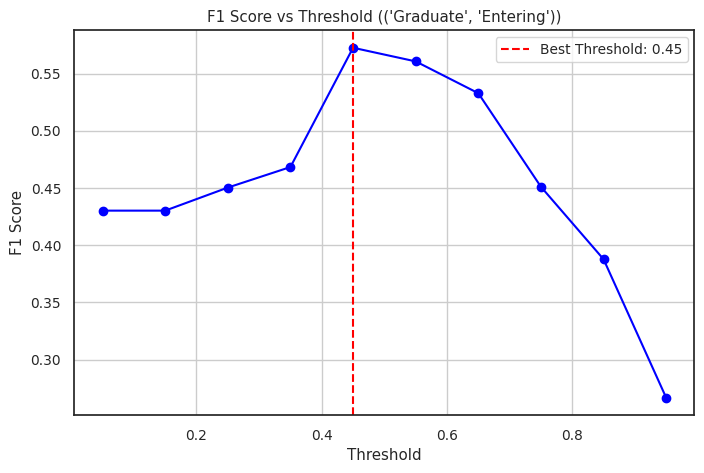

Classification Report (Best Threshold):
              precision    recall  f1-score   support

         0.0       0.41      0.30      0.34       122
         1.0       0.77      0.84      0.80       332

    accuracy                           0.70       454
   macro avg       0.59      0.57      0.57       454
weighted avg       0.67      0.70      0.68       454

Confusion Matrix (('Graduate', 'Entering')):
[[ 36  86]
 [ 52 280]]


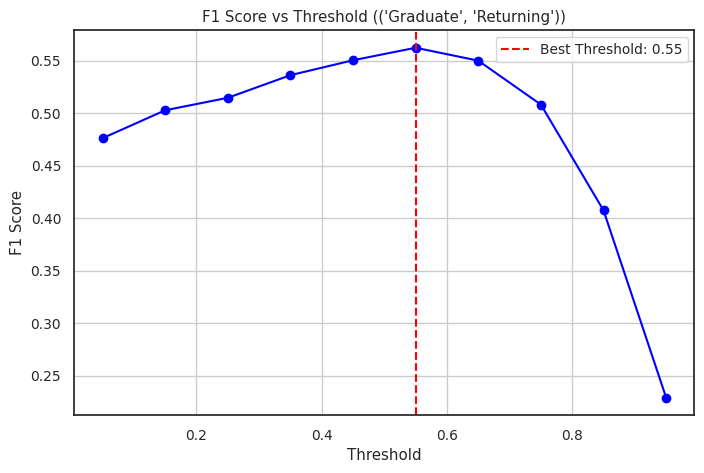

Classification Report (Best Threshold):
              precision    recall  f1-score   support

         0.0       0.24      0.29      0.27       126
         1.0       0.88      0.84      0.86       743

    accuracy                           0.76       869
   macro avg       0.56      0.57      0.56       869
weighted avg       0.78      0.76      0.77       869

Confusion Matrix (('Graduate', 'Returning')):
[[ 37  89]
 [116 627]]


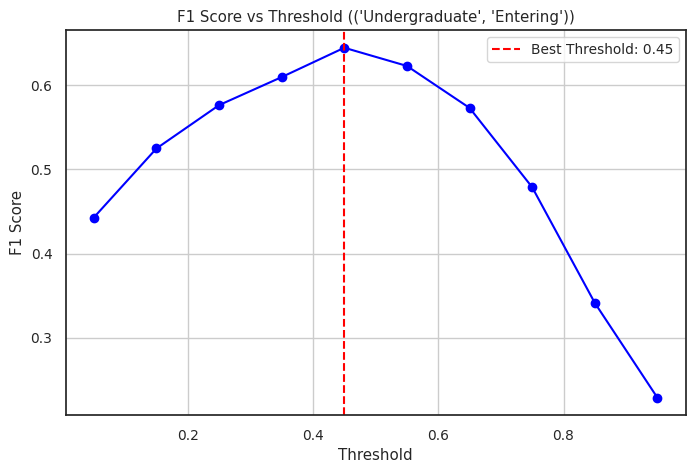

Classification Report (Best Threshold):
              precision    recall  f1-score   support

         0.0       0.51      0.42      0.46       584
         1.0       0.80      0.85      0.82      1568

    accuracy                           0.73      2152
   macro avg       0.66      0.64      0.64      2152
weighted avg       0.72      0.73      0.73      2152

Confusion Matrix (('Undergraduate', 'Entering')):
[[ 248  336]
 [ 235 1333]]


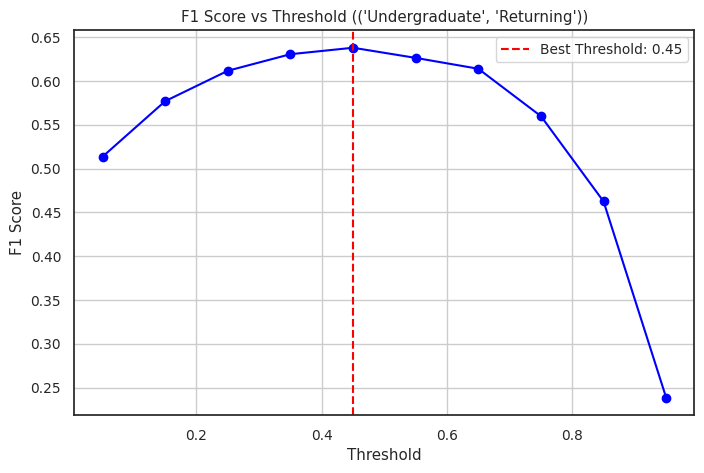

Classification Report (Best Threshold):
              precision    recall  f1-score   support

         0.0       0.41      0.37      0.39       738
         1.0       0.88      0.89      0.89      3712

    accuracy                           0.81      4450
   macro avg       0.64      0.63      0.64      4450
weighted avg       0.80      0.81      0.80      4450

Confusion Matrix (('Undergraduate', 'Returning')):
[[ 274  464]
 [ 392 3320]]


['/content/drive/MyDrive/lasso_results.pkl']

In [ ]:
# suppress convergence warnings
warnings.filterwarnings("ignore")

# define grid for hyperparameter tuning
param_dist = {
    # C is the inverse of lambda
    # smaller C means a stronger regulation
    "C": np.logspace(-4, 4, 100)
}

# use stratified folds so that both classes are represented in each fold
# shuffle the data for better folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# to store results of models
lasso_results = {}

# loop through each dataset
for group_key, data in processed_datasets.items():
    x_train, y_train = data["x_train"], data["y_train"]
    x_val, y_val = data["x_val"], data["y_val"]
    x_test, y_test = data["x_test"], data["y_test"]

    # set up the model that we will hypertune
    base_model = LogisticRegression(
        # setting the penalty to l1 causes the model to behave like LASSO
        penalty="l1",
        solver="liblinear",
        # set the maximum number of iterations for the model
        max_iter=500,
    )

    # Use Randomized grid search to speed up hyperparameter tuning
    grid_search = RandomizedSearchCV(
        # pass the base model
        base_model,
        # pass the parameter grid
        param_distributions=param_dist,
        # set crossfolds for hyperparameter tuning
        cv=cv,
        # limit the number of models trained
        n_iter=10,
        # set f1 as the tuning metric
        scoring="f1_macro",
        # set how much output the model will print during fitting
        verbose=0,
        # parallelize across cores
        n_jobs=-1,
        random_state=42,
    )

    # fit the grid search
    grid_search.fit(x_train, y_train)

    # extract the best model
    best_model = grid_search.best_estimator_

    # generate probabilities of class 1 on the validation set
    val_probs = best_model.predict_proba(x_val)[:, 1]

    # define probability thresholds to test
    thresholds = np.arange(0.05, 1.01, 0.1)

    # calculate the f1 score for each threshold
    f1_scores = [f1_score(y_val, val_probs >= t, average="macro") for t in thresholds]

    # find the best threshold that produces the maximum f1 score
    # get the index of the best threshold
    best_idx = np.argmax(f1_scores)
    # get the value of the best threshold
    best_threshold = thresholds[best_idx]
    # get the best f1 score for the model based on the best threshold
    best_f1 = f1_scores[best_idx]

    # plot the F1 score versus the probability thresholds
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1_scores, marker="o", color="blue")
    plt.axvline(
        x=best_threshold,
        color="red",
        linestyle="--",
        label=f"Best Threshold: {best_threshold:.2f}",
    )
    plt.title(f"F1 Score vs Threshold ({group_key})")
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid(True)
    filepath = os.path.join("/content/drive/MyDrive/", f"{group_key}_LASSO_F1.png")
    plt.savefig(filepath)
    plt.show()

    # Convert probabilities to binary using best threshold
    val_preds_thresh = (val_probs >= best_threshold).astype(int)

    # Compute individual metrics
    f1_macro = f1_score(y_val, val_preds_thresh, average='macro')
    f1_class_0 = f1_score(y_val, val_preds_thresh, pos_label=0)
    f1_class_1 = f1_score(y_val, val_preds_thresh, pos_label=1)
    recall = recall_score(y_val, val_preds_thresh)
    accuracy = accuracy_score(y_val, val_preds_thresh)

    # Compute PR AUC
    prec, rec, _ = precision_recall_curve(y_val, val_probs)
    pr_auc = auc(rec, prec)

    # Evaluate
    print("Classification Report (Best Threshold):")
    print(classification_report(y_val, val_preds_thresh))

    # Confusion Matrix
    cm = confusion_matrix(y_val, val_preds_thresh)
    print(f"Confusion Matrix ({group_key}):")
    print(cm)

    # store the results of the model
    lasso_results[group_key] = {
      'best_model': best_model,
      'best_threshold': best_threshold,
      'best_f1': best_f1,
      'f1_class_0': f1_class_0,
      'f1_class_1': f1_class_1,
      'recall': recall,
      'accuracy': accuracy,
      'pr_auc': pr_auc,
      'grid_search': grid_search.best_params_,
      'x_test': x_test,
      'y_test': y_test
  }

# Save the full dictionary
joblib.dump(lasso_results, "/content/drive/MyDrive/lasso_results.pkl")

### Neural Additive Models

#### Data Preparation for NAM

In [ ]:
## Prepping Data for NAM ##
# initialize a variable to hold results
processed_nam_datasets = {}

# the dnamite package does not require imputation or one-hot encoding, so we'll use
# the original_groups data
# loop through each dataset
for (level, entering), df in original_groups.items():

    # separate out the test data set
    test_df = df[df["census_year"] == 2024]
    train_val_df = df[df["census_year"] < 2024]

    # separate the target variable from the data
    x = train_val_df.drop(columns=["retained_to_oru"])
    y = train_val_df["retained_to_oru"]
    x_test = test_df.drop(columns=["retained_to_oru"])
    y_test = test_df["retained_to_oru"]

    # identify numeric columns
    num_cols = x.select_dtypes(include=[np.number]).columns

    # align the columns of the train/test
    x, x_test = x.align(x_test, join="left", axis=1, fill_value=0)

    # apply Z-score normalization to numeric columns
    scaler = StandardScaler()
    x[num_cols] = scaler.fit_transform(x[num_cols])
    x_test[num_cols] = scaler.transform(x_test[num_cols])

    # split the training set further into training and validation
    x_train, x_val, y_train, y_val = train_test_split(
        x, y, test_size=0.3, stratify=y, random_state=42
    )

    # Store everything for modeling
    processed_nam_datasets[(level, entering)] = {
        "x_train": x_train,
        "y_train": y_train,
        "x_val": x_val,
        "y_val": y_val,
        "x_test": x_test,
        "y_test": y_test,
    }

#### Classic Neural Additive Model

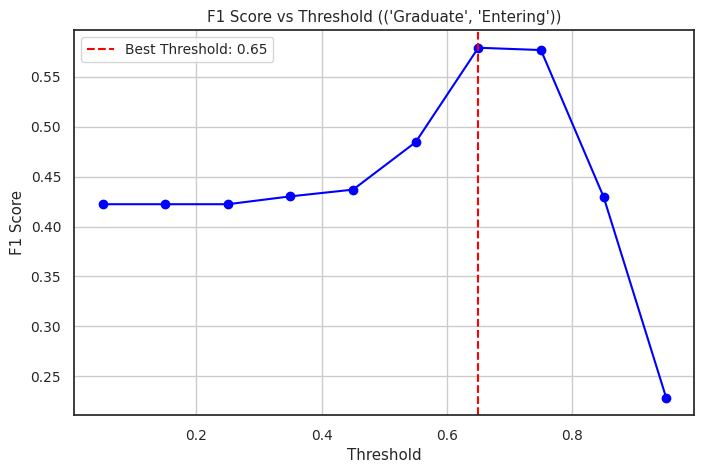

Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0       0.41      0.32      0.36       122
           1       0.77      0.83      0.80       332

    accuracy                           0.69       454
   macro avg       0.59      0.58      0.58       454
weighted avg       0.67      0.69      0.68       454

Confusion Matrix (('Graduate', 'Entering')):
[[ 39  83]
 [ 56 276]]


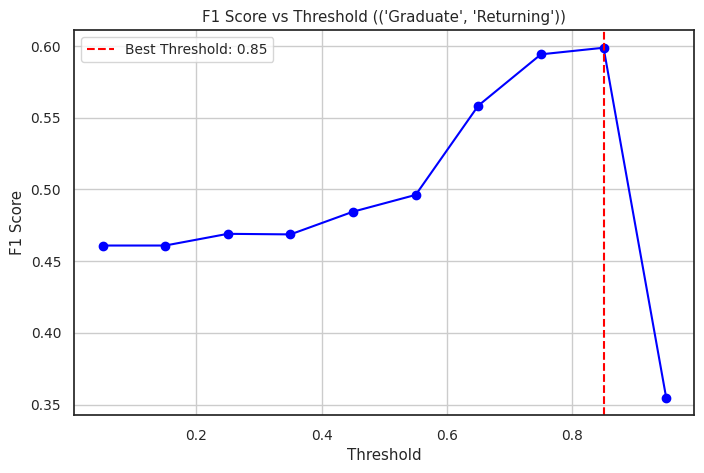

Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0       0.28      0.45      0.35       126
           1       0.90      0.81      0.85       743

    accuracy                           0.75       869
   macro avg       0.59      0.63      0.60       869
weighted avg       0.81      0.75      0.78       869

Confusion Matrix (('Graduate', 'Returning')):
[[ 57  69]
 [144 599]]


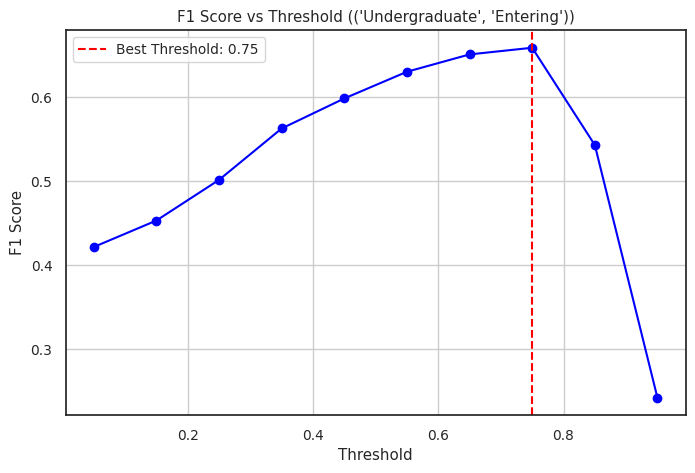

Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0       0.46      0.64      0.54       584
           1       0.84      0.72      0.78      1568

    accuracy                           0.70      2152
   macro avg       0.65      0.68      0.66      2152
weighted avg       0.74      0.70      0.71      2152

Confusion Matrix (('Undergraduate', 'Entering')):
[[ 374  210]
 [ 432 1136]]


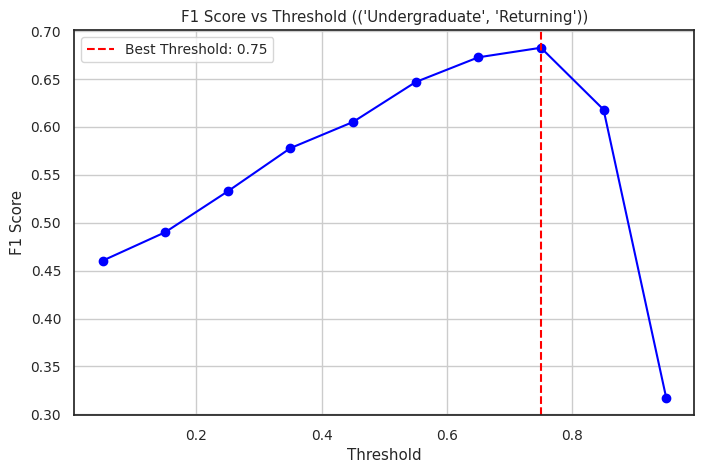

Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0       0.45      0.52      0.48       738
           1       0.90      0.87      0.89      3712

    accuracy                           0.81      4450
   macro avg       0.67      0.69      0.68      4450
weighted avg       0.83      0.81      0.82      4450

Confusion Matrix (('Undergraduate', 'Returning')):
[[ 382  356]
 [ 475 3237]]


['/content/drive/MyDrive/nam_results.pkl']

In [ ]:
# suppress potential convergence warnings
warnings.filterwarnings("ignore")

# to store results of models
nam_results = {}

# define grid for hyperparameter tuning
param_grid = {
    # the size of the embedding vector for categorical or
    # discretized continuous features
    "n_embed": [16, 32, 64],
    # the number of neurons in each hidden layer
    "n_hidden": [32, 64],
    # the number of hidden layers
    # deep models can learn more complex patterns but can be harder to train
    "n_layers": [1, 2],
    # the maximum number of bins for discretizing continuous variables
    "max_bins": [16],
    # controls how fast the model learns
    "learning_rate": [1e-3, 5e-4],
    # number of training samples processed before updating weights
    "batch_size": [64, 128],
    # size of the kernel used in convutional layers applied to single features
    # controls how much local smoothing or neighborhood interaction is applied
    "kernel_size": [3, 5],
}

# make a sklearn parameter grid using 10 random grid sample
grid = sampled_grid = list(ParameterSampler(param_grid, n_iter=10, random_state=42))


# function to train the models in parallel
def train_and_score(params, x_train, y_train, x_val, y_val):
    # initialize the model
    model = DNAMiteBinaryClassifier(random_state=42, validation_size=0.2, **params)
    # fit the model
    model.fit(x_train, y_train)
    # get probability predictions from the model
    val_probs = model.predict_proba(x_val)
    # convert the probabilities to class predictions using basic 0.5 threshold
    val_preds = (val_probs >= 0.5).astype(int)
    # calculate the f1 score of this model
    score = f1_score(y_val, val_preds, average="binary")
    # return the results
    return (score, params, model)


# loop through each dataset
for group_key, data in processed_nam_datasets.items():
    x_train, y_train = data["x_train"], data["y_train"]
    x_val, y_val = data["x_val"], data["y_val"]
    x_test, y_test = data["x_test"], data["y_test"]

    # run the model training in parallel
    results = Parallel(n_jobs=-1)(
        delayed(train_and_score)(params, x_train, y_train, x_val, y_val)
        for params in sampled_grid
    )

    # extract the best model
    best_score, best_params, best_model = max(results, key=lambda x: x[0])

    # Already trained best_model — now tune threshold
    val_probs = best_model.predict_proba(x_val)

    # define probability thresholds to test
    thresholds = np.arange(0.05, 1.01, 0.1)

    # calculate the f1 score for each threshold
    f1_scores = [f1_score(y_val, val_probs >= t, average="macro") for t in thresholds]

    # find the best threshold that produces the maximum f1 score
    # get the index of the best threshold
    best_idx = np.argmax(f1_scores)
    # get the value of the best threshold
    best_threshold = thresholds[best_idx]
    # get the best f1 score for the model based on the best threshold
    best_f1 = f1_scores[best_idx]

    # plot the F1 score versus the probability thresholds
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1_scores, marker='o', color='blue')
    plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
    plt.title(f'F1 Score vs Threshold ({group_key})')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    filepath = os.path.join("/content/drive/MyDrive/", f"{group_key}_NAM_F1.png")
    plt.savefig(filepath)
    plt.show()

    # Convert probabilities to binary using best threshold
    val_preds_thresh = (val_probs >= best_threshold).astype(int)

    # Compute individual metrics
    f1_macro = f1_score(y_val, val_preds_thresh, average='macro')
    f1_class_0 = f1_score(y_val, val_preds_thresh, pos_label=0)
    f1_class_1 = f1_score(y_val, val_preds_thresh, pos_label=1)
    recall = recall_score(y_val, val_preds_thresh)
    accuracy = accuracy_score(y_val, val_preds_thresh)

    # Compute PR AUC
    prec, rec, _ = precision_recall_curve(y_val, val_probs)
    pr_auc = auc(rec, prec)

    # Evaluate
    print("Classification Report (Best Threshold):")
    print(classification_report(y_val, val_preds_thresh))

    # Confusion Matrix
    cm = confusion_matrix(y_val, val_preds_thresh)
    print(f"Confusion Matrix ({group_key}):")
    print(cm)

    # store the results of the model
    nam_results[group_key] = {
        'best_model': best_model,
        'best_threshold': best_threshold,
        'best_f1': best_f1,
        'f1_class_0': f1_class_0,
        'f1_class_1': f1_class_1,
        'recall': recall,
        'accuracy': accuracy,
        'pr_auc': pr_auc,
        'grid_search': best_params,
        'x_test': x_test,
        'y_test': y_test
    }

# save the models to drive to use later
joblib.dump(nam_results, '/content/drive/MyDrive/nam_results.pkl')

#### Neural Additive Model With DNAMite Feature Selection

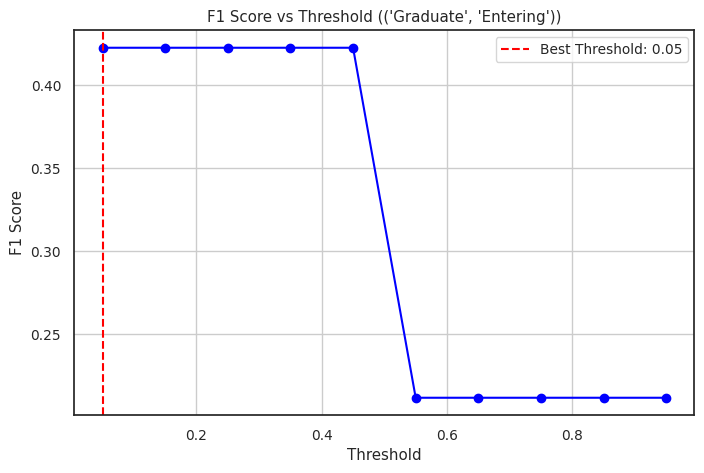

Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       122
           1       0.73      1.00      0.84       332

    accuracy                           0.73       454
   macro avg       0.37      0.50      0.42       454
weighted avg       0.53      0.73      0.62       454

Confusion Matrix (('Graduate', 'Entering')):
[[  0 122]
 [  0 332]]


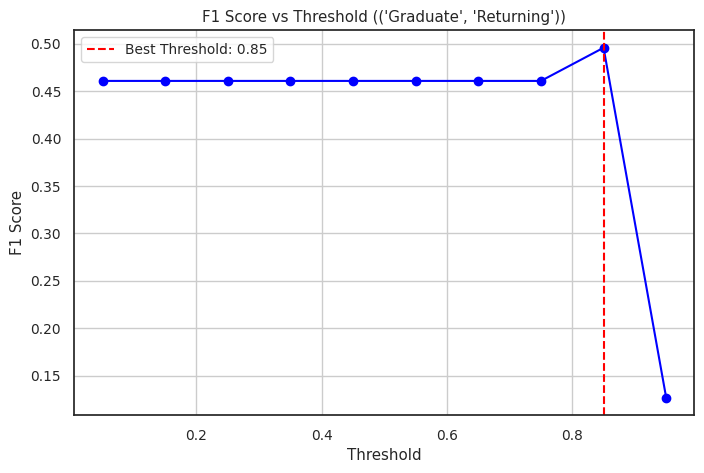

Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0       0.16      0.36      0.22       126
           1       0.86      0.69      0.77       743

    accuracy                           0.64       869
   macro avg       0.51      0.52      0.50       869
weighted avg       0.76      0.64      0.69       869

Confusion Matrix (('Graduate', 'Returning')):
[[ 45  81]
 [230 513]]


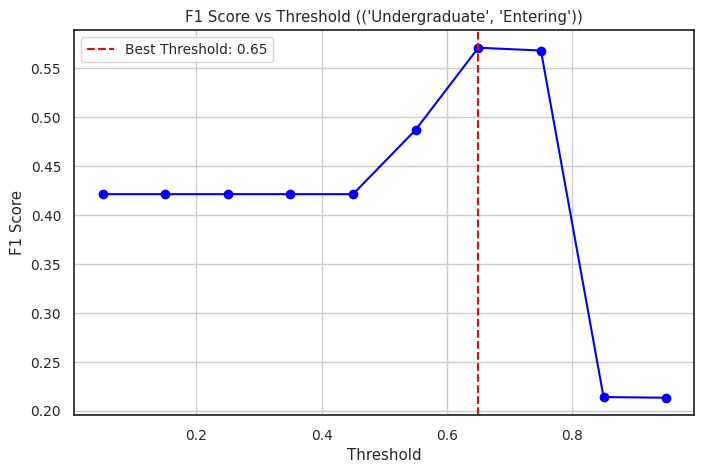

Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0       0.37      0.38      0.38       584
           1       0.77      0.76      0.76      1568

    accuracy                           0.66      2152
   macro avg       0.57      0.57      0.57      2152
weighted avg       0.66      0.66      0.66      2152

Confusion Matrix (('Undergraduate', 'Entering')):
[[ 223  361]
 [ 374 1194]]


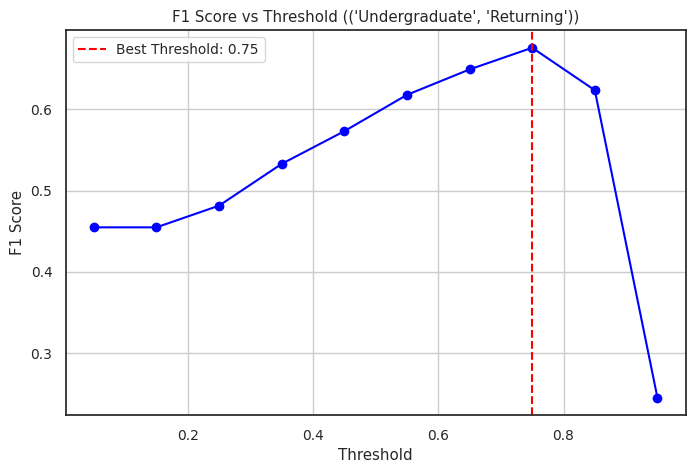

Classification Report (Best Threshold):
              precision    recall  f1-score   support

           0       0.47      0.44      0.46       738
           1       0.89      0.90      0.90      3712

    accuracy                           0.83      4450
   macro avg       0.68      0.67      0.68      4450
weighted avg       0.82      0.83      0.82      4450

Confusion Matrix (('Undergraduate', 'Returning')):
[[ 326  412]
 [ 366 3346]]


['/content/drive/MyDrive/nam_results_top_features.pkl']

In [ ]:
# suppress potential convergence warnings
warnings.filterwarnings("ignore")

# to store results of models
nam_results_top_features = {}

# define grid for hyperparameter tuning
param_grid = {
    # the size of the embedding vector for categorical or
    # discretized continuous features
    "n_embed": [16, 32, 64],
    # the number of neurons in each hidden layer
    "n_hidden": [32, 64],
    # the number of hidden layers
    # deep models can learn more complex patterns but can be harder to train
    "n_layers": [1, 2],
    # the maximum number of bins for discretizing continuous variables
    "max_bins": [16, 32],
    # controls how fast the model learns
    "learning_rate": [1e-3, 5e-4],
    # number of training samples processed before updating weights
    "batch_size": [64, 128],
    # size of the kernel used in convutional layers applied to single features
    # controls how much local smoothing or neighborhood interaction is applied
    "kernel_size": [3, 5],
}

# make a sklearn parameter grid using 10 random grid sample
grid = sampled_grid = list(ParameterSampler(param_grid, n_iter=5, random_state=42))


# function to train the models in parallel
def train_and_score(params, x_train, y_train, x_val, y_val):
    # initialize the model
    model = DNAMiteBinaryClassifier(random_state=42, validation_size=0.2, **params)
    # use feature selection from the DNAMite package
    model.select_features(x_train, y_train, reg_param = 0.2, select_pairs = False)
    # fit the model
    model.fit(x_train, y_train)
    # get probability predictions from the model
    val_probs = model.predict_proba(x_val)
    # convert the probabilities to class predictions using basic 0.5 threshold
    val_preds = (val_probs >= 0.5).astype(int)
    # calculate the f1 score of this model
    score = f1_score(y_val, val_preds, average="binary")
    # return the results
    return (score, params, model)


# loop through each dataset
for group_key, data in processed_nam_datasets.items():
    x_train, y_train = data["x_train"], data["y_train"]
    x_val, y_val = data["x_val"], data["y_val"]
    x_test, y_test = data["x_test"], data["y_test"]

    # run the model training in parallel
    results = Parallel(n_jobs=-1)(
        delayed(train_and_score)(params, x_train, y_train, x_val, y_val)
        for params in sampled_grid
    )

    # extract the best model
    best_score, best_params, best_model = max(results, key=lambda x: x[0])

    # Already trained best_model — now tune threshold
    val_probs = best_model.predict_proba(x_val)

    # define probability thresholds to test
    thresholds = np.arange(0.05, 1.01, 0.1)

    # calculate the f1 score for each threshold
    f1_scores = [f1_score(y_val, val_probs >= t, average="macro") for t in thresholds]

    # find the best threshold that produces the maximum f1 score
    # get the index of the best threshold
    best_idx = np.argmax(f1_scores)
    # get the value of the best threshold
    best_threshold = thresholds[best_idx]
    # get the best f1 score for the model based on the best threshold
    best_f1 = f1_scores[best_idx]

    # plot the F1 score versus the probability thresholds
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1_scores, marker='o', color='blue')
    plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
    plt.title(f'F1 Score vs Threshold ({group_key})')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    filepath = os.path.join("/content/drive/MyDrive/", f"{group_key}_NAM_F1.png")
    plt.savefig(filepath)
    plt.show()

    # Convert probabilities to binary using best threshold
    val_preds_thresh = (val_probs >= best_threshold).astype(int)

    # Compute individual metrics
    f1_macro = f1_score(y_val, val_preds_thresh, average='macro')
    f1_class_0 = f1_score(y_val, val_preds_thresh, pos_label=0)
    f1_class_1 = f1_score(y_val, val_preds_thresh, pos_label=1)
    recall = recall_score(y_val, val_preds_thresh)
    accuracy = accuracy_score(y_val, val_preds_thresh)

    # Compute PR AUC
    prec, rec, _ = precision_recall_curve(y_val, val_probs)
    pr_auc = auc(rec, prec)

    # Evaluate
    print("Classification Report (Best Threshold):")
    print(classification_report(y_val, val_preds_thresh))

    # Confusion Matrix
    cm = confusion_matrix(y_val, val_preds_thresh)
    print(f"Confusion Matrix ({group_key}):")
    print(cm)

    # store the results of the model
    nam_results_top_features[group_key] = {
      'best_model': best_model,
      'best_threshold': best_threshold,
      'best_f1': best_f1,
      'f1_class_0': f1_class_0,
      'f1_class_1': f1_class_1,
      'recall': recall,
      'accuracy': accuracy,
      'pr_auc': pr_auc,
      'grid_search': best_params,
      'x_test': x_test,
      'y_test': y_test
  }

# save the models to drive to use later
joblib.dump(nam_results_top_features, '/content/drive/MyDrive/nam_results_top_features.pkl')

# Model Evaluation

In [ ]:
# Load the model results
from google.colab import drive
drive.mount('/content/drive')
nam_results = joblib.load('/content/drive/MyDrive/nam_results.pkl')
rf_results = joblib.load('/content/drive/MyDrive/rf_results.pkl')
rf_results_top_features = joblib.load('/content/drive/MyDrive/rf_results_top_features.pkl')
lasso_results = joblib.load('/content/drive/MyDrive/lasso_results.pkl')
nam_results_top_features = joblib.load('/content/drive/MyDrive/nam_results_top_features.pkl')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Model Evaluation Metrics

In [ ]:
# combine the model results
all_results = {
    'rf': rf_results,
    'lasso': lasso_results,
    'nam': nam_results,
    'rf_top': rf_results_top_features,
    'nam_top': nam_results_top_features
}

# Dictionary to store the best model and its F1 score for each dataset
best_models_per_dataset = {}

# Initialize a list to collect all metric rows
metrics_list = []

# Loop over each dataset key.
# use next(iter(...)) to get the dataset keys from any one of the model results dicts.
for dataset in next(iter(all_results.values())).keys():
    # Initialize with a low value (since F1 scores are >= 0)
    best_f1 = -1
    # Will store the name of the best model
    best_model = None
    # Will store the full result dict for the best model
    best_info = None

    # Loop through each model's results
    for model_name, results in all_results.items():
        # Extract F1 score for current model on current dataset
        f1 = results[dataset]['best_f1']

        model_metrics = results[dataset]

        # Extract individual metrics
        avg_f1 = model_metrics.get('best_f1', None)
        f1_0 = model_metrics.get('f1_class_0', None)
        f1_1 = model_metrics.get('f1_class_1', None)
        recall = model_metrics.get('recall', None)
        accuracy = model_metrics.get('accuracy', None)
        pr_auc = model_metrics.get('pr_auc', None)
         # Extract additional info
        threshold = model_metrics.get('best_threshold', None)
        best_params = model_metrics.get('grid_search', {})

        # Add a row to the metrics list
        metrics_list.append({
            'dataset': dataset,
            'model': model_name,
            'avg_f1': avg_f1,
            'f1_class_0': f1_0,
            'f1_class_1': f1_1,
            'recall': recall,
            'accuracy': accuracy,
            'pr_auc': pr_auc,
            'threshold': threshold,
            'best_params': str(best_params)
        })

        # Check if this model has a better F1 than the current best
        if f1 > best_f1:
            # Update the best F1
            best_f1 = f1
            # Update the best model name
            best_model = model_name
            # Save the full result dict for reference
            best_info = results[dataset]

    # After checking all models, store the best info for this dataset
    best_models_per_dataset[dataset] = {
        # e.g., 'nam'
        'model': best_model,
        # the best F1 score
        'best_f1': best_f1,
        # the associated model info
        'info': best_info
    }

# Manually override best model selection for a specific dataset
override_dataset = ('Graduate', 'Entering')
override_model = 'nam'

# Check if dataset exists and override
if override_dataset in best_models_per_dataset:
    overridden_info = all_results[override_model][override_dataset]
    best_models_per_dataset[override_dataset] = {
        'model': override_model,
        'best_f1': overridden_info['best_f1'],
        'info': overridden_info
    }
    # print(f"Note: Manually selected '{override_model}' as the best model for {override_dataset} (F1 = {overridden_info['best_f1']:.3f})")


# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(metrics_list)

# export to csv
metrics_df.to_csv('/content/drive/MyDrive/model_metrics_summary_2.csv', index=False)

# Print out the best model and F1 score per dataset
for dataset, result in best_models_per_dataset.items():
    print(f"{dataset}: Best model = {result['model']} with F1 = {result['best_f1']:.3f}")

('Graduate', 'Entering'): Best model = nam with F1 = 0.579
('Graduate', 'Returning'): Best model = nam with F1 = 0.599
('Undergraduate', 'Entering'): Best model = rf with F1 = 0.667
('Undergraduate', 'Returning'): Best model = nam with F1 = 0.683


## Area Under Precision-Recall Curve

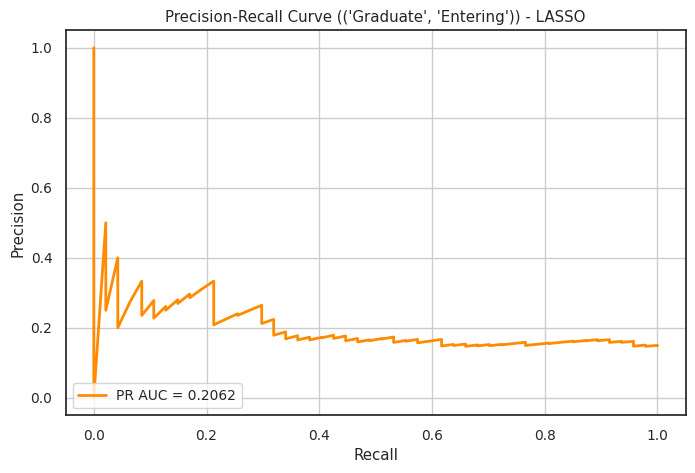

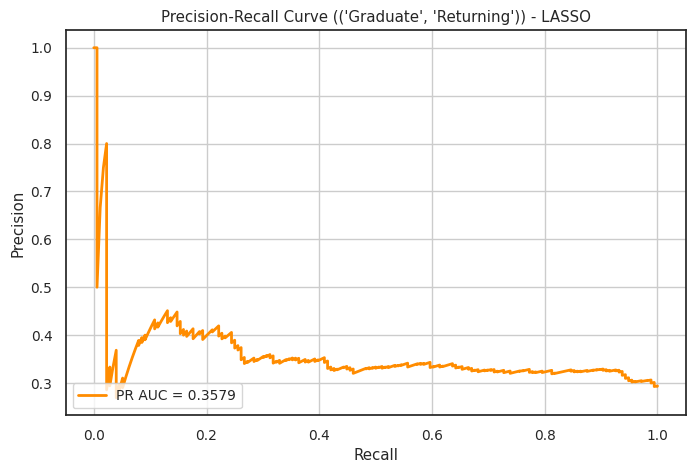

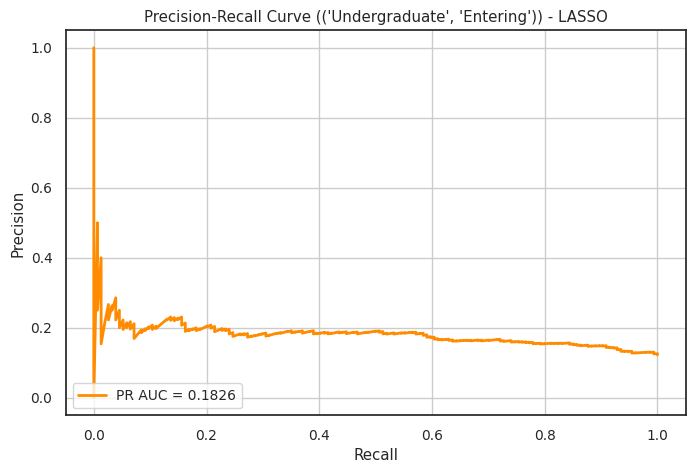

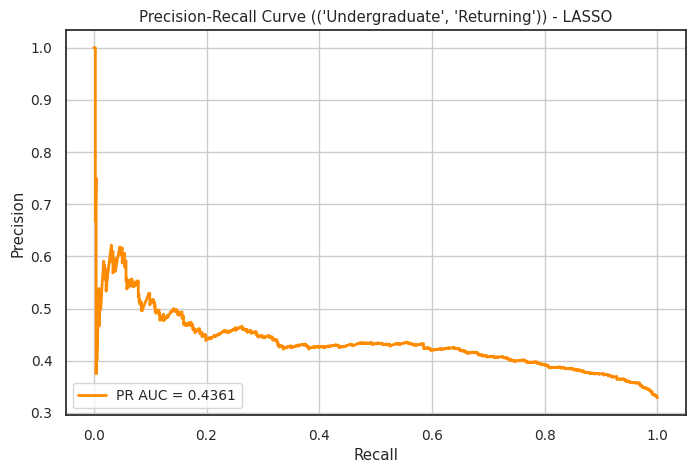

In [ ]:
## Plot the PR AUC Curve for LASSO ##
for group_key, result in lasso_results.items():
    model = result['best_model']
    threshold = result['best_threshold']

    # Get test data
    x_test = processed_datasets[group_key]['x_test']
    y_test = processed_datasets[group_key]['y_test']

    # Predict probabilities
    test_probs = model.predict_proba(x_test)[:,1]
    # Calculate PR curve
    precision, recall, thresholds = precision_recall_curve(y_test, test_probs)
    pr_auc = average_precision_score(y_test, test_probs)

    # Plot the PR curve
    plt.figure(figsize=(8, 5))
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({group_key}) - LASSO')
    plt.legend(loc="lower left")
    plt.grid(True)
    filepath = os.path.join("/content/drive/MyDrive/", f"{group_key}_LASSO_PR_AUC.png")
    plt.savefig(filepath)
    plt.show()

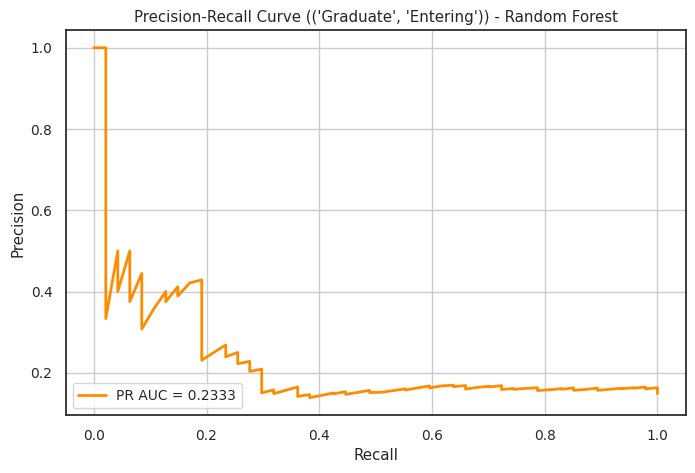

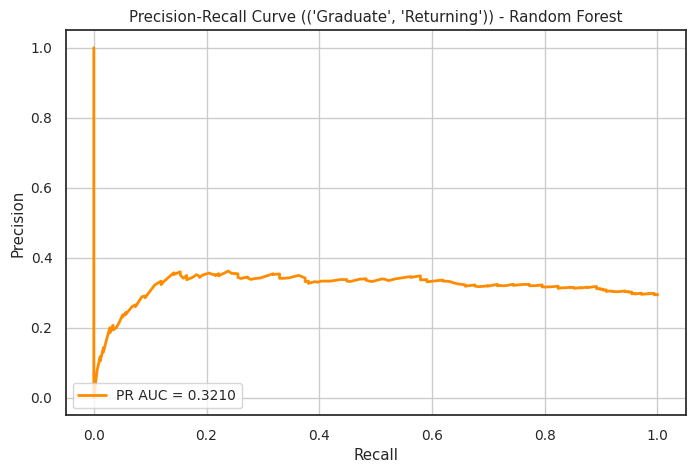

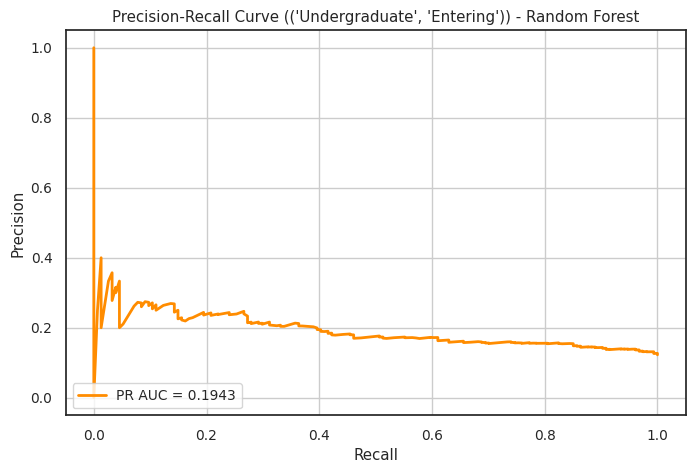

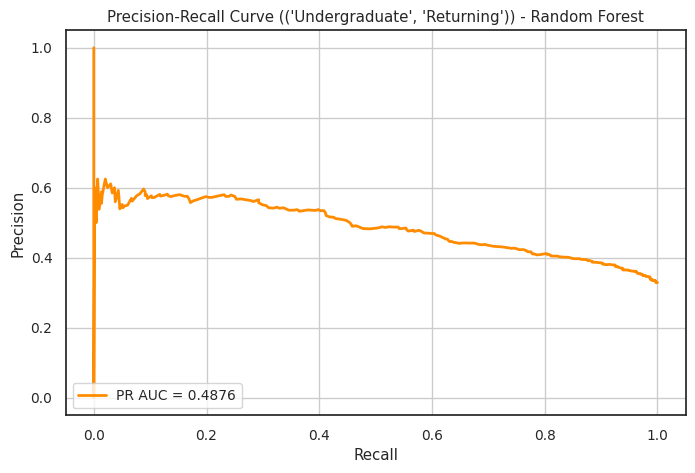

In [ ]:
## Plot the PR AUC Curve for Random Forest ##
for group_key, result in rf_results.items():
    model = result['best_model']
    threshold = result['best_threshold']

    # Get test data
    x_test = processed_datasets[group_key]['x_test']
    y_test = processed_datasets[group_key]['y_test']

    # Predict probabilities
    test_probs = model.predict_proba(x_test)[:,1]

    # Calculate PR curve
    precision, recall, thresholds = precision_recall_curve(y_test, test_probs)
    pr_auc = average_precision_score(y_test, test_probs)

    # Plot the PR curve
    plt.figure(figsize=(8, 5))
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({group_key}) - Random Forest')
    plt.legend(loc="lower left")
    plt.grid(True)
    filepath = os.path.join("/content/drive/MyDrive/", f"{group_key}_RF_PR_AUC.png")
    plt.savefig(filepath)
    plt.show()

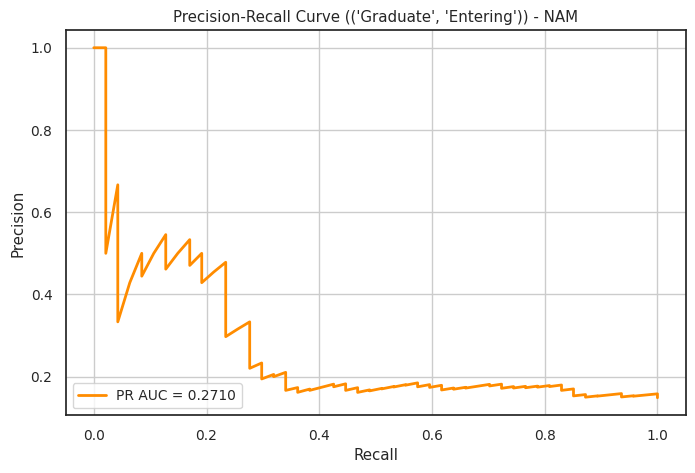

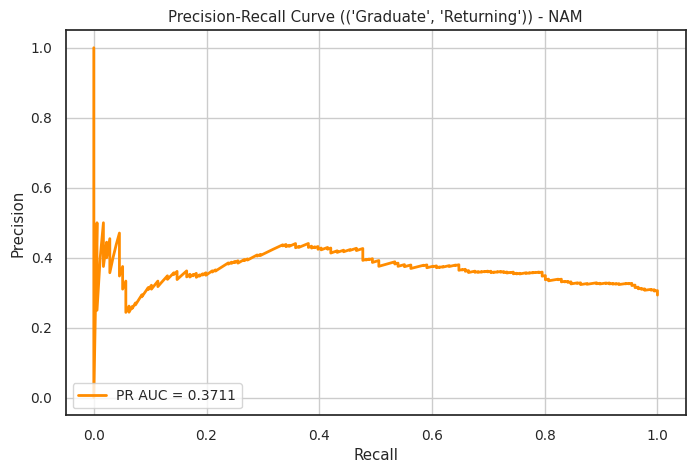

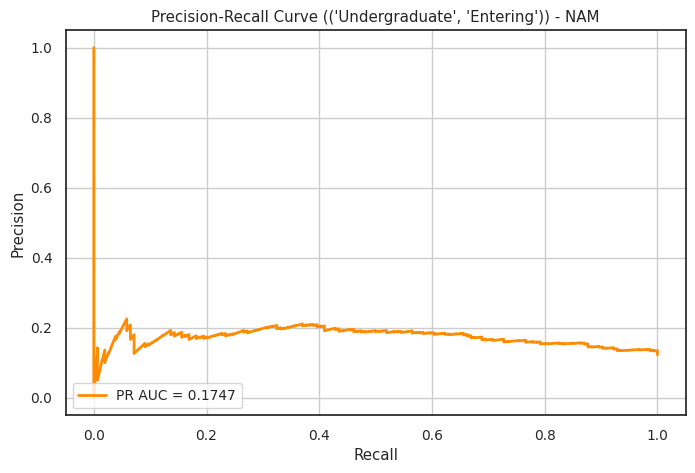

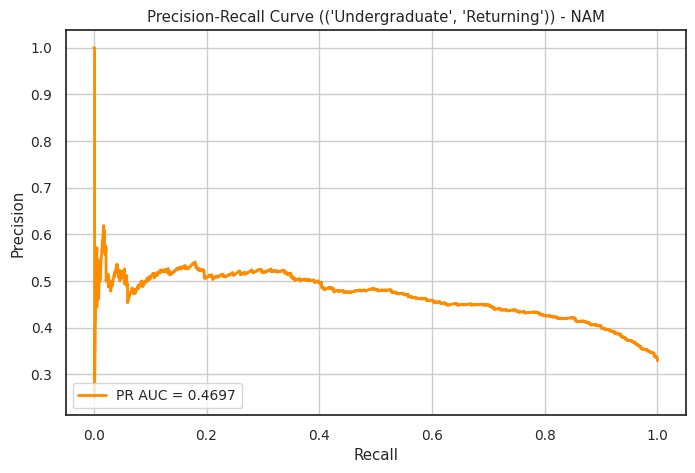

In [ ]:
## Plot the PR AUC curve ##
for group_key, result in nam_results.items():
    model = result['best_model']
    threshold = result['best_threshold']

    # Get test data
    x_test = processed_nam_datasets[group_key]['x_test']
    y_test = processed_nam_datasets[group_key]['y_test']

    # Predict probabilities
    test_probs = model.predict_proba(x_test)

    # Calculate PR curve
    precision, recall, thresholds = precision_recall_curve(y_test, test_probs)
    pr_auc = average_precision_score(y_test, test_probs)

    # Plot the PR curve
    plt.figure(figsize=(8, 5))
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR AUC = {pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({group_key}) - NAM')
    plt.legend(loc="lower left")
    plt.grid(True)
    filepath = os.path.join("/content/drive/MyDrive/", f"{group_key}_NAM_PR_AUC.png")
    plt.savefig(filepath)
    plt.show()

## Confusion Matrices for Predictions on 2024 Cohorts

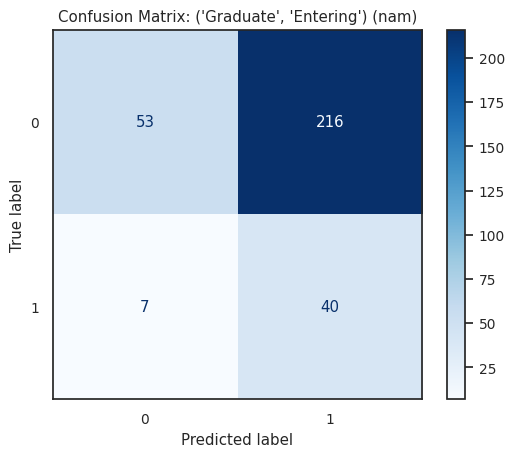

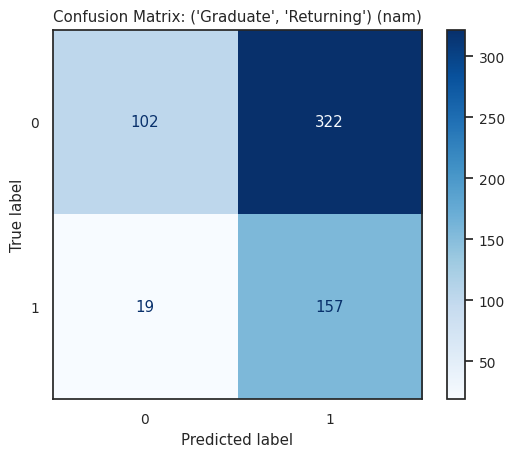

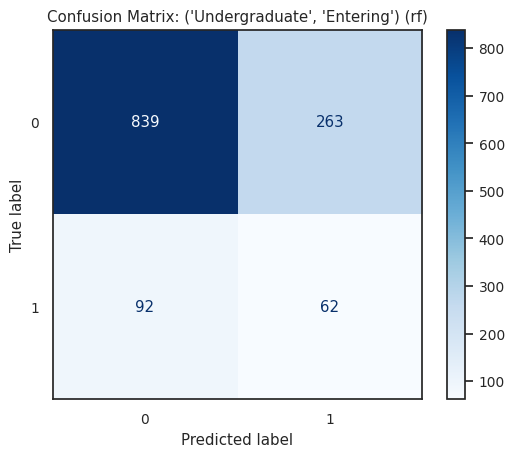

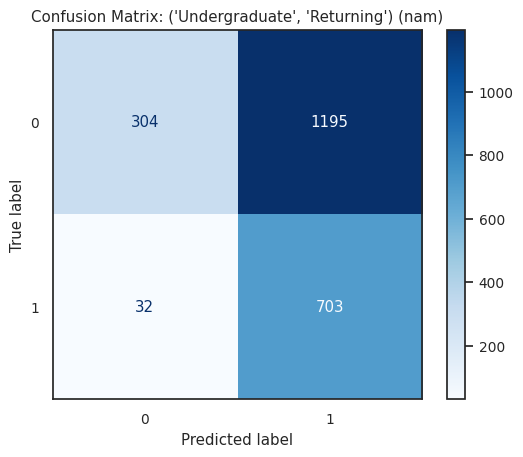

In [ ]:
# Iterate through each dataset and its best model info
for dataset, result in best_models_per_dataset.items():
  # grab the info from the dict
  model_name = result['model']
  model_info = result['info']
  model = model_info['best_model']
  threshold = model_info['best_threshold']
  x_test = model_info['x_test']
  y_test = model_info['y_test']

  # Print confusion matrix for the best model
  # first, get the predicted probabilities for the 2024 cohort - i.e. test
  y_proba = model.predict_proba(x_test)
  if y_proba.ndim == 2:
    y_proba = y_proba[:, 1]
  # convert to binary classifications using the best threshold
  y_pred = (y_proba >= threshold).astype(int)
  # compute the confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  # display the confusion matrix
  disp = ConfusionMatrixDisplay(confusion_matrix = cm)
  disp.plot(cmap = 'Blues')
  plt.title(f"Confusion Matrix: {dataset} ({model_name})")
  plt.show()

## Feature Importance of Best Models

<Figure size 800x500 with 0 Axes>

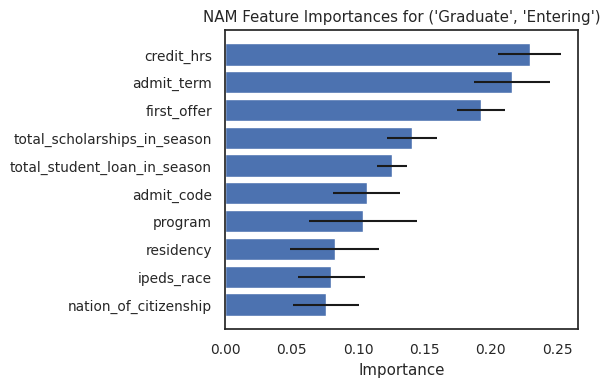

ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 640x480 with 0 Axes>

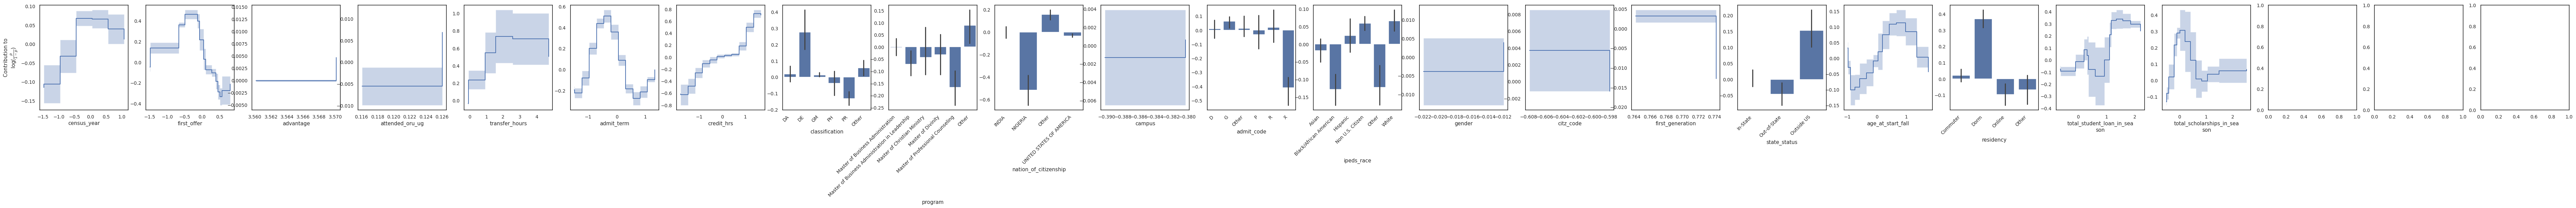

In [ ]:
# create output directory
output_dir = "/content/drive/MyDrive/feature_importance_plots"
os.makedirs(output_dir, exist_ok=True)


# Loop through each dataset and its corresponding best model
for dataset, result in best_models_per_dataset.items():
  # grab the info from the dict
  model_name = result['model']
  if model_name == 'rf':
    model_name = 'Random Forest'
  model_info = result['info']
  model = model_info['best_model']
  x_test = model_info['x_test']
  y_test = model_info['y_test']

  # feature importance plot
  plt.figure(figsize = (8, 5))

  # check the best model to see if it has feature importances (random forest does)
  if hasattr(model, 'feature_importances_'):
    # collect the importances from the model
    importances = model.feature_importances_
    # collect the feature names (doesn't matter that it's from the test data, column names should be the same)
    feature_names = x_test.columns
    # get the indexes to sort the importances
    sorted_idx = abs(importances).argsort()[::-1][:10] # keep only the top 10
    # initialize a seaborn barplot
    sns.barplot(x = importances[sorted_idx], y = feature_names[sorted_idx])
    # title the plot
    plt.title(f"Top 10 Feature Importances: {dataset} ({model_name})")
    plt.xlabel("Importance")
  elif hasattr(model, 'coef_'):
      # For lasso
      importances = model.coef_.flatten()
      feature_names = model_info.get('feature_names', x_test.columns)

      # Sort by absolute value of coefficients
      sorted_idx = abs(importances).argsort()[::-1][:10]  # Top 10
      top_features = [feature_names[i] for i in sorted_idx]

      sns.barplot(x=importances[sorted_idx], y=top_features)
      plt.title(f"Top 10 Coefficients: {dataset} ({model_name})")
      plt.xlabel("Coefficient")

  elif model_name == 'nam' or model_name == 'nam_top':
    # use the dnamite built in plotting function
    model.plot_feature_importances()

    # Set a custom title
    plt.title(f"NAM Feature Importances for {dataset}")
    plt.show()
    plt.close()

## Shape Plots for NAMs

ValueError: could not convert string to float: 'census_year'

# Conclusions & Insights